# Design CTP-14 human brain promoter-enhancer DNA-MERFISH library 

by Pu Zheng

2022.11.08


# Table of contents


> 0. [Minimum required packages and settings](#0)
>>
>> 0.1: [load required packages](#0.1)
>>
>> 0.2 [Genome reference information](#0.2)
>
> 1. [Extract region sequences](#1)
>>
>> 1.1 [select Gene TSS](#1.1)
>>
>> 1.2 [load gene TSS sequences](#1.2)


<a id='0'></a>
# 0 Minimum required packages and settings

<a id='0.1'></a>
## 0.1 load required packages

In [2]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

#from ImageAnalysis3 import *
print(os.getpid())

# library design specific tools
from ImageAnalysis3.library_tools import LibraryDesigner as ld
from ImageAnalysis3.library_tools import LibraryTools as lt
# biopython imports
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
#from Bio.Blast.Applications import NcbiblastnCommandline
#from Bio.Blast import NCBIXML

21312


<a id='0.2'></a>
## 0.2 Genome reference information

In [3]:
## Some folders
# human genome
reference_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\human\hg38'
genome_folder = os.path.join(reference_folder, 'Genome')

print(f"-- reference_folder: {reference_folder}")

-- reference_folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\human\hg38


In [4]:
# Library directories
pool_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain'
if not os.path.exists(pool_folder):
    print(f"Create pool_folder: {pool_folder}")
    os.makedirs(pool_folder)
else:
    print(f"Use pool_folder: {pool_folder}")
    
# folder for sub-pool
library_folder = os.path.join(pool_folder, f'human_brain_promoter_enhancer_v2')
if not os.path.exists(library_folder):
    print(f"create library folder: {library_folder}")
    os.makedirs(library_folder)
# folder for fasta sequences
sequence_folder = os.path.join(library_folder, 'sequences')
if not os.path.exists(sequence_folder):
    print(f"create sequence folder: {sequence_folder}")
    os.makedirs(sequence_folder)
# folder to save result probes
report_folder = os.path.join(library_folder, 'reports')
if not os.path.exists(report_folder):
    print(f"create report folder: {report_folder}")
    os.makedirs(report_folder)
    
print(f"-- library_folder: {library_folder}")
print(f"-- sequence_folder: {sequence_folder}")
print(f"-- report_folder: {report_folder}")

Use pool_folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain
-- library_folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2
-- sequence_folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences
-- report_folder: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\reports


In [ ]:
#resolution = 0
#flanking = 10000

<a id='1'></a>
# 1 Extract region sequences

In [55]:
from ImageAnalysis3.structure_tools.distance import sort_chr

In [85]:
chrom_size_df = pd.read_csv( os.path.join(reference_folder, 'hg38.chrom.sizes'), names=['name','length'],
                            delimiter='\t', header=None)
chrom_size_dict = {_n.split('chr')[1]:int(_l) for _n, _l in zip(chrom_size_df['name'], chrom_size_df['length']) if _l > 1e7}

chrom_size_df

name     length
0                chr1  248956422
1                chr2  242193529
2                chr3  198295559
3                chr4  190214555
4                chr5  181538259
..                ...        ...
450  chrUn_KI270539v1        993
451  chrUn_KI270385v1        990
452  chrUn_KI270423v1        981
453  chrUn_KI270392v1        971
454  chrUn_KI270394v1        970

[455 rows x 2 columns]

In [93]:
final_region_dicts = []
overlap_fraction_th = 0.25

# create overlap ref dict
overlap_refer_dict = {_c:np.zeros(_l, dtype=np.int32) for _c,_l in chrom_size_dict.items()}

<a id='1.1'></a>
## 1.1 select Gene TSS

### 1.1.1 load gene reference

In [22]:
from ImageAnalysis3 import library_tools
reload(library_tools.references)
reload(library_tools.sequences)
gff3_ref_filename = os.path.join(reference_folder, 'Transcriptome', 'Homo_sapiens.GRCh38.106.gff3')

In [29]:
with library_tools.references.gff3_reader(gff3_ref_filename, auto_read=False, load_savefile=True) as ref_rd:
    ## example commands
    infos = ref_rd._load_all()
    ref_rd._load_headers()
    #gene_infos = ref_rd.load_gene_by_id('ENSMUSG00000064842')
    #gene_dict = ref_rd.parse_gene_info(gene_infos)
    gene_info_dict = ref_rd._batch_parse_gene_info()
    ref_save_dict = ref_rd._save_to_file(overwrite=False)

- loading from save_file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\human\hg38\Transcriptome\Homo_sapiens.GRCh38.106.pkl
opening ref_file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\human\hg38\Transcriptome\Homo_sapiens.GRCh38.106.gff3
parsing all gene information
gene:ENSG00000223972
gene:ENSG00000227232
gene:ENSG00000278267
gene:ENSG00000243485
gene:ENSG00000284332
gene:ENSG00000237613
gene:ENSG00000268020
gene:ENSG00000240361
gene:ENSG00000186092
gene:ENSG00000238009
gene:ENSG00000239945
gene:ENSG00000233750
gene:ENSG00000268903
gene:ENSG00000269981
gene:ENSG00000239906
gene:ENSG00000241860
gene:ENSG00000222623
gene:ENSG00000241599
gene:ENSG00000279928
gene:ENSG00000279457
gene:ENSG00000273874
gene:ENSG00000228463
gene:ENSG00000286448
gene:ENSG00000236679
gene:ENSG00000236601
gene:ENSG00000237094
gene:ENSG00000269732
gene:ENSG00000284733
gene:ENSG00000233653
gene:ENSG00000250575
gene:ENSG00000278757
gene:ENSG00000230021
gene:ENSG00000235146
gene:EN

gene:ENSG00000226476
gene:ENSG00000231252
gene:ENSG00000162599
gene:ENSG00000237928
gene:ENSG00000237853
gene:ENSG00000284808
gene:ENSG00000287224
gene:ENSG00000223920
gene:ENSG00000162604
gene:ENSG00000271200
gene:ENSG00000132849
gene:ENSG00000200575
gene:ENSG00000212360
gene:ENSG00000236646
gene:ENSG00000242860
gene:ENSG00000263908
gene:ENSG00000283690
gene:ENSG00000234204
gene:ENSG00000234088
gene:ENSG00000240563
gene:ENSG00000237227
gene:ENSG00000200174
gene:ENSG00000132854
gene:ENSG00000201153
gene:ENSG00000162607
gene:ENSG00000116641
gene:ENSG00000270549
gene:ENSG00000132855
gene:ENSG00000278967
gene:ENSG00000213703
gene:ENSG00000235545
gene:ENSG00000125703
gene:ENSG00000234318
gene:ENSG00000237163
gene:ENSG00000229537
gene:ENSG00000286455
gene:ENSG00000227485
gene:ENSG00000229225
gene:ENSG00000203605
gene:ENSG00000224209
gene:ENSG00000252259
gene:ENSG00000228734
gene:ENSG00000223683
gene:ENSG00000230798
gene:ENSG00000187140
gene:ENSG00000275836
gene:ENSG00000252784
gene:ENSG0000

gene:ENSG00000275801
gene:ENSG00000274562
gene:ENSG00000122224
gene:ENSG00000122223
gene:ENSG00000226003
gene:ENSG00000179914
gene:ENSG00000213080
gene:ENSG00000232188
gene:ENSG00000198358
gene:ENSG00000233691
gene:ENSG00000158764
gene:ENSG00000158769
gene:ENSG00000270149
gene:ENSG00000232879
gene:ENSG00000215845
gene:ENSG00000158773
gene:ENSG00000289121
gene:ENSG00000186517
gene:ENSG00000143217
gene:ENSG00000228917
gene:ENSG00000162755
gene:ENSG00000143256
gene:ENSG00000158793
gene:ENSG00000158796
gene:ENSG00000238934
gene:ENSG00000143222
gene:ENSG00000224985
gene:ENSG00000143258
gene:ENSG00000143224
gene:ENSG00000158850
gene:ENSG00000158859
gene:ENSG00000158864
gene:ENSG00000158869
gene:ENSG00000158874
gene:ENSG00000158882
gene:ENSG00000284035
gene:ENSG00000143257
gene:ENSG00000248485
gene:ENSG00000158887
gene:ENSG00000143252
gene:ENSG00000289106
gene:ENSG00000188931
gene:ENSG00000288670
gene:ENSG00000236484
gene:ENSG00000289141
gene:ENSG00000283696
gene:ENSG00000288093
gene:ENSG0000

gene:ENSG00000236495
gene:ENSG00000201766
gene:ENSG00000237032
gene:ENSG00000185267
gene:ENSG00000284024
gene:ENSG00000187522
gene:ENSG00000272853
gene:ENSG00000152455
gene:ENSG00000152457
gene:ENSG00000197889
gene:ENSG00000235623
gene:ENSG00000228547
gene:ENSG00000182531
gene:ENSG00000237470
gene:ENSG00000152463
gene:ENSG00000176244
gene:ENSG00000228312
gene:ENSG00000176236
gene:ENSG00000152464
gene:ENSG00000152465
gene:ENSG00000206448
gene:ENSG00000228181
gene:ENSG00000148468
gene:ENSG00000232739
gene:ENSG00000077943
gene:ENSG00000148481
gene:ENSG00000252537
gene:ENSG00000237913
gene:ENSG00000201260
gene:ENSG00000226140
gene:ENSG00000165983
gene:ENSG00000223156
gene:ENSG00000165985
gene:ENSG00000287925
gene:ENSG00000148484
gene:ENSG00000225213
gene:ENSG00000275001
gene:ENSG00000286958
gene:ENSG00000107611
gene:ENSG00000273153
gene:ENSG00000107614
gene:ENSG00000229124
gene:ENSG00000026025
gene:ENSG00000234961
gene:ENSG00000148488
gene:ENSG00000204832
gene:ENSG00000251803
gene:ENSG0000

gene:ENSG00000239152
gene:ENSG00000264217
gene:ENSG00000265354
gene:ENSG00000265733
gene:ENSG00000266412
gene:ENSG00000289092
gene:ENSG00000263639
gene:ENSG00000280012
gene:ENSG00000289636
gene:ENSG00000264204
gene:ENSG00000263482
gene:ENSG00000274209
gene:ENSG00000279058
gene:ENSG00000273225
gene:ENSG00000279458
gene:ENSG00000264230
gene:ENSG00000285402
gene:ENSG00000285294
gene:ENSG00000213412
gene:ENSG00000204174
gene:ENSG00000204175
gene:ENSG00000204176
gene:ENSG00000231187
gene:ENSG00000229227
gene:ENSG00000165874
gene:ENSG00000272430
gene:ENSG00000229927
gene:ENSG00000274186
gene:ENSG00000285662
gene:ENSG00000280913
gene:ENSG00000265366
gene:ENSG00000215097
gene:ENSG00000204177
gene:ENSG00000238405
gene:ENSG00000243289
gene:ENSG00000150175
gene:ENSG00000204179
gene:ENSG00000289299
gene:ENSG00000266524
gene:ENSG00000263761
gene:ENSG00000265203
gene:ENSG00000265763
gene:ENSG00000265190
gene:ENSG00000270369
gene:ENSG00000189090
gene:ENSG00000224919
gene:ENSG00000204172
gene:ENSG0000

gene:ENSG00000254864
gene:ENSG00000166394
gene:ENSG00000183378
gene:ENSG00000275612
gene:ENSG00000276668
gene:ENSG00000271758
gene:ENSG00000254707
gene:ENSG00000176716
gene:ENSG00000227892
gene:ENSG00000254951
gene:ENSG00000166408
gene:ENSG00000241008
gene:ENSG00000183303
gene:ENSG00000182334
gene:ENSG00000170688
gene:ENSG00000252769
gene:ENSG00000279000
gene:ENSG00000170683
gene:ENSG00000289714
gene:ENSG00000182261
gene:ENSG00000175390
gene:ENSG00000254642
gene:ENSG00000255420
gene:ENSG00000166402
gene:ENSG00000254921
gene:ENSG00000248332
gene:ENSG00000279391
gene:ENSG00000166405
gene:ENSG00000246820
gene:ENSG00000166407
gene:ENSG00000130413
gene:ENSG00000252778
gene:ENSG00000166436
gene:ENSG00000254900
gene:ENSG00000166441
gene:ENSG00000200983
gene:ENSG00000212607
gene:ENSG00000166444
gene:ENSG00000254665
gene:ENSG00000255159
gene:ENSG00000252905
gene:ENSG00000202276
gene:ENSG00000166452
gene:ENSG00000176029
gene:ENSG00000176009
gene:ENSG00000223080
gene:ENSG00000175348
gene:ENSG0000

gene:ENSG00000255460
gene:ENSG00000261594
gene:ENSG00000137486
gene:ENSG00000254429
gene:ENSG00000279117
gene:ENSG00000254963
gene:ENSG00000199090
gene:ENSG00000149273
gene:ENSG00000206941
gene:ENSG00000207445
gene:ENSG00000149243
gene:ENSG00000158555
gene:ENSG00000254460
gene:ENSG00000149257
gene:ENSG00000255326
gene:ENSG00000171533
gene:ENSG00000255434
gene:ENSG00000254630
gene:ENSG00000255280
gene:ENSG00000166391
gene:ENSG00000263993
gene:ENSG00000247867
gene:ENSG00000062282
gene:ENSG00000254826
gene:ENSG00000254814
gene:ENSG00000255507
gene:ENSG00000198382
gene:ENSG00000200256
gene:ENSG00000199362
gene:ENSG00000255255
gene:ENSG00000255081
gene:ENSG00000223013
gene:ENSG00000254915
gene:ENSG00000255421
gene:ENSG00000085741
gene:ENSG00000254933
gene:ENSG00000255362
gene:ENSG00000137492
gene:ENSG00000179240
gene:ENSG00000201756
gene:ENSG00000255135
gene:ENSG00000158636
gene:ENSG00000254755
gene:ENSG00000255363
gene:ENSG00000255479
gene:ENSG00000254810
gene:ENSG00000236304
gene:ENSG0000

gene:ENSG00000111790
gene:ENSG00000064115
gene:ENSG00000247903
gene:ENSG00000152944
gene:ENSG00000275764
gene:ENSG00000214700
gene:ENSG00000271418
gene:ENSG00000256226
gene:ENSG00000256625
gene:ENSG00000211455
gene:ENSG00000029153
gene:ENSG00000245311
gene:ENSG00000288971
gene:ENSG00000165935
gene:ENSG00000257037
gene:ENSG00000110841
gene:ENSG00000248100
gene:ENSG00000256056
gene:ENSG00000256557
gene:ENSG00000256377
gene:ENSG00000174236
gene:ENSG00000276261
gene:ENSG00000230519
gene:ENSG00000256504
gene:ENSG00000061794
gene:ENSG00000252585
gene:ENSG00000205693
gene:ENSG00000256747
gene:ENSG00000087448
gene:ENSG00000256512
gene:ENSG00000201612
gene:ENSG00000274075
gene:ENSG00000256378
gene:ENSG00000087494
gene:ENSG00000257042
gene:ENSG00000123106
gene:ENSG00000247934
gene:ENSG00000255951
gene:ENSG00000278733
gene:ENSG00000273989
gene:ENSG00000252237
gene:ENSG00000202187
gene:ENSG00000244712
gene:ENSG00000256513
gene:ENSG00000278687
gene:ENSG00000257258
gene:ENSG00000064763
gene:ENSG0000

gene:ENSG00000255692
gene:ENSG00000283768
gene:ENSG00000226729
gene:ENSG00000135127
gene:ENSG00000278250
gene:ENSG00000255575
gene:ENSG00000111737
gene:ENSG00000277283
gene:ENSG00000089154
gene:ENSG00000266704
gene:ENSG00000089157
gene:ENSG00000255857
gene:ENSG00000089159
gene:ENSG00000286067
gene:ENSG00000275936
gene:ENSG00000240925
gene:ENSG00000123009
gene:ENSG00000202538
gene:ENSG00000200795
gene:ENSG00000089163
gene:ENSG00000252659
gene:ENSG00000170890
gene:ENSG00000135097
gene:ENSG00000239881
gene:ENSG00000256695
gene:ENSG00000111775
gene:ENSG00000111780
gene:ENSG00000170855
gene:ENSG00000257218
gene:ENSG00000219355
gene:ENSG00000111786
gene:ENSG00000088986
gene:ENSG00000248008
gene:ENSG00000278344
gene:ENSG00000110871
gene:ENSG00000222601
gene:ENSG00000241030
gene:ENSG00000022840
gene:ENSG00000288623
gene:ENSG00000289401
gene:ENSG00000167272
gene:ENSG00000242137
gene:ENSG00000256008
gene:ENSG00000157782
gene:ENSG00000110917
gene:ENSG00000256364
gene:ENSG00000277423
gene:ENSG0000

gene:ENSG00000276240
gene:ENSG00000256350
gene:ENSG00000211776
gene:ENSG00000248358
gene:ENSG00000211777
gene:ENSG00000211778
gene:ENSG00000211779
gene:ENSG00000240954
gene:ENSG00000211780
gene:ENSG00000211781
gene:ENSG00000211782
gene:ENSG00000211783
gene:ENSG00000211784
gene:ENSG00000256474
gene:ENSG00000211785
gene:ENSG00000211786
gene:ENSG00000211787
gene:ENSG00000211788
gene:ENSG00000211789
gene:ENSG00000211790
gene:ENSG00000256379
gene:ENSG00000211791
gene:ENSG00000211792
gene:ENSG00000211793
gene:ENSG00000258482
gene:ENSG00000258557
gene:ENSG00000211794
gene:ENSG00000211795
gene:ENSG00000211796
gene:ENSG00000211797
gene:ENSG00000211798
gene:ENSG00000211799
gene:ENSG00000258705
gene:ENSG00000211800
gene:ENSG00000211801
gene:ENSG00000276428
gene:ENSG00000211802
gene:ENSG00000211803
gene:ENSG00000211804
gene:ENSG00000211805
gene:ENSG00000211806
gene:ENSG00000211807
gene:ENSG00000211808
gene:ENSG00000211809
gene:ENSG00000258835
gene:ENSG00000211810
gene:ENSG00000259092
gene:ENSG0000

gene:ENSG00000258855
gene:ENSG00000258494
gene:ENSG00000270824
gene:ENSG00000270451
gene:ENSG00000282089
gene:ENSG00000282268
gene:ENSG00000270185
gene:ENSG00000259698
gene:ENSG00000259025
gene:ENSG00000258771
gene:ENSG00000243059
gene:ENSG00000260986
gene:ENSG00000279595
gene:ENSG00000258684
gene:ENSG00000258883
gene:ENSG00000237161
gene:ENSG00000247765
gene:ENSG00000207289
gene:ENSG00000280881
gene:ENSG00000280703
gene:ENSG00000258415
gene:ENSG00000268531
gene:ENSG00000258712
gene:ENSG00000258767
gene:ENSG00000258848
gene:ENSG00000278522
gene:ENSG00000277243
gene:ENSG00000275174
gene:ENSG00000281347
gene:ENSG00000277841
gene:ENSG00000287345
gene:ENSG00000284834
gene:ENSG00000284788
gene:ENSG00000280709
gene:ENSG00000284988
gene:ENSG00000279639
gene:ENSG00000259324
gene:ENSG00000285491
gene:ENSG00000285116
gene:ENSG00000182974
gene:ENSG00000279408
gene:ENSG00000279445
gene:ENSG00000281113
gene:ENSG00000281087
gene:ENSG00000281179
gene:ENSG00000281550
gene:ENSG00000278263
gene:ENSG0000

gene:ENSG00000259707
gene:ENSG00000228141
gene:ENSG00000259315
gene:ENSG00000279758
gene:ENSG00000259442
gene:ENSG00000286817
gene:ENSG00000250988
gene:ENSG00000252690
gene:ENSG00000186628
gene:ENSG00000277864
gene:ENSG00000156232
gene:ENSG00000103942
gene:ENSG00000259805
gene:ENSG00000169612
gene:ENSG00000169609
gene:ENSG00000288850
gene:ENSG00000260608
gene:ENSG00000064726
gene:ENSG00000273747
gene:ENSG00000259767
gene:ENSG00000260351
gene:ENSG00000259308
gene:ENSG00000263643
gene:ENSG00000286872
gene:ENSG00000136404
gene:ENSG00000166503
gene:ENSG00000260579
gene:ENSG00000259986
gene:ENSG00000169594
gene:ENSG00000140600
gene:ENSG00000156218
gene:ENSG00000212374
gene:ENSG00000261665
gene:ENSG00000200444
gene:ENSG00000274128
gene:ENSG00000259609
gene:ENSG00000259404
gene:ENSG00000280038
gene:ENSG00000259694
gene:ENSG00000259511
gene:ENSG00000259726
gene:ENSG00000225151
gene:ENSG00000278422
gene:ENSG00000184206
gene:ENSG00000259633
gene:ENSG00000259683
gene:ENSG00000244056
gene:ENSG0000

gene:ENSG00000280189
gene:ENSG00000166152
gene:ENSG00000262950
gene:ENSG00000263110
gene:ENSG00000261623
gene:ENSG00000102935
gene:ENSG00000260089
gene:ENSG00000260024
gene:ENSG00000280131
gene:ENSG00000259978
gene:ENSG00000275155
gene:ENSG00000279842
gene:ENSG00000261751
gene:ENSG00000244551
gene:ENSG00000283365
gene:ENSG00000205423
gene:ENSG00000259843
gene:ENSG00000261835
gene:ENSG00000273829
gene:ENSG00000260298
gene:ENSG00000155393
gene:ENSG00000279356
gene:ENSG00000202124
gene:ENSG00000260381
gene:ENSG00000287444
gene:ENSG00000260031
gene:ENSG00000252526
gene:ENSG00000121274
gene:ENSG00000121281
gene:ENSG00000274969
gene:ENSG00000166164
gene:ENSG00000261393
gene:ENSG00000261092
gene:ENSG00000260573
gene:ENSG00000140807
gene:ENSG00000260029
gene:ENSG00000278909
gene:ENSG00000205414
gene:ENSG00000260249
gene:ENSG00000167208
gene:ENSG00000167207
gene:ENSG00000270120
gene:ENSG00000261644
gene:ENSG00000083799
gene:ENSG00000264947
gene:ENSG00000260616
gene:ENSG00000261703
gene:ENSG0000

gene:ENSG00000284117
gene:ENSG00000263620
gene:ENSG00000220205
gene:ENSG00000179029
gene:ENSG00000200463
gene:ENSG00000266824
gene:ENSG00000283160
gene:ENSG00000196544
gene:ENSG00000279152
gene:ENSG00000271002
gene:ENSG00000178999
gene:ENSG00000178977
gene:ENSG00000178971
gene:ENSG00000178921
gene:ENSG00000269947
gene:ENSG00000125434
gene:ENSG00000108961
gene:ENSG00000271029
gene:ENSG00000198844
gene:ENSG00000226871
gene:ENSG00000212206
gene:ENSG00000266279
gene:ENSG00000184650
gene:ENSG00000184619
gene:ENSG00000265749
gene:ENSG00000263809
gene:ENSG00000161970
gene:ENSG00000288750
gene:ENSG00000189051
gene:ENSG00000166579
gene:ENSG00000133026
gene:ENSG00000252363
gene:ENSG00000270606
gene:ENSG00000244604
gene:ENSG00000161973
gene:ENSG00000183318
gene:ENSG00000185156
gene:ENSG00000276231
gene:ENSG00000141506
gene:ENSG00000266389
gene:ENSG00000265975
gene:ENSG00000065320
gene:ENSG00000262966
gene:ENSG00000273816
gene:ENSG00000170310
gene:ENSG00000263708
gene:ENSG00000225751
gene:ENSG0000

gene:ENSG00000239246
gene:ENSG00000264546
gene:ENSG00000277463
gene:ENSG00000274565
gene:ENSG00000011028
gene:ENSG00000207382
gene:ENSG00000279713
gene:ENSG00000199697
gene:ENSG00000265702
gene:ENSG00000173838
gene:ENSG00000287457
gene:ENSG00000265000
gene:ENSG00000264907
gene:ENSG00000283538
gene:ENSG00000207552
gene:ENSG00000265262
gene:ENSG00000170921
gene:ENSG00000270324
gene:ENSG00000272164
gene:ENSG00000272383
gene:ENSG00000264513
gene:ENSG00000264529
gene:ENSG00000233635
gene:ENSG00000263501
gene:ENSG00000271919
gene:ENSG00000226797
gene:ENSG00000263644
gene:ENSG00000271749
gene:ENSG00000265282
gene:ENSG00000008283
gene:ENSG00000265971
gene:ENSG00000228979
gene:ENSG00000159640
gene:ENSG00000264813
gene:ENSG00000224353
gene:ENSG00000173826
gene:ENSG00000136485
gene:ENSG00000288894
gene:ENSG00000200560
gene:ENSG00000136463
gene:ENSG00000270587
gene:ENSG00000198909
gene:ENSG00000263883
gene:ENSG00000266173
gene:ENSG00000136490
gene:ENSG00000279369
gene:ENSG00000125695
gene:ENSG0000

gene:ENSG00000267000
gene:ENSG00000267061
gene:ENSG00000267269
gene:ENSG00000267774
gene:ENSG00000273664
gene:ENSG00000224161
gene:ENSG00000267486
gene:ENSG00000267669
gene:ENSG00000141682
gene:ENSG00000267066
gene:ENSG00000267497
gene:ENSG00000239398
gene:ENSG00000256704
gene:ENSG00000267462
gene:ENSG00000267742
gene:ENSG00000252555
gene:ENSG00000267686
gene:ENSG00000242060
gene:ENSG00000202468
gene:ENSG00000267620
gene:ENSG00000267401
gene:ENSG00000285681
gene:ENSG00000166603
gene:ENSG00000267400
gene:ENSG00000266915
gene:ENSG00000267687
gene:ENSG00000267382
gene:ENSG00000267098
gene:ENSG00000267153
gene:ENSG00000267513
gene:ENSG00000101542
gene:ENSG00000206769
gene:ENSG00000243256
gene:ENSG00000288800
gene:ENSG00000267316
gene:ENSG00000267279
gene:ENSG00000267175
gene:ENSG00000267038
gene:ENSG00000260440
gene:ENSG00000176641
gene:ENSG00000197563
gene:ENSG00000267597
gene:ENSG00000134444
gene:ENSG00000266900
gene:ENSG00000267560
gene:ENSG00000141655
gene:ENSG00000199867
gene:ENSG0000

gene:ENSG00000197808
gene:ENSG00000276071
gene:ENSG00000225975
gene:ENSG00000189042
gene:ENSG00000267041
gene:ENSG00000267260
gene:ENSG00000267353
gene:ENSG00000267254
gene:ENSG00000197863
gene:ENSG00000251247
gene:ENSG00000206669
gene:ENSG00000185869
gene:ENSG00000243297
gene:ENSG00000198453
gene:ENSG00000197050
gene:ENSG00000275547
gene:ENSG00000267345
gene:ENSG00000267672
gene:ENSG00000267360
gene:ENSG00000196967
gene:ENSG00000267437
gene:ENSG00000245680
gene:ENSG00000188283
gene:ENSG00000267605
gene:ENSG00000226686
gene:ENSG00000286449
gene:ENSG00000181666
gene:ENSG00000276846
gene:ENSG00000267682
gene:ENSG00000189164
gene:ENSG00000279936
gene:ENSG00000196437
gene:ENSG00000171827
gene:ENSG00000266916
gene:ENSG00000267115
gene:ENSG00000188227
gene:ENSG00000180458
gene:ENSG00000267470
gene:ENSG00000171817
gene:ENSG00000180479
gene:ENSG00000120784
gene:ENSG00000196381
gene:ENSG00000267552
gene:ENSG00000267319
gene:ENSG00000198182
gene:ENSG00000267152
gene:ENSG00000287496
gene:ENSG0000

gene:ENSG00000213639
gene:ENSG00000163806
gene:ENSG00000273233
gene:ENSG00000171103
gene:ENSG00000163811
gene:ENSG00000264994
gene:ENSG00000265145
gene:ENSG00000222224
gene:ENSG00000265706
gene:ENSG00000189350
gene:ENSG00000200283
gene:ENSG00000179270
gene:ENSG00000229224
gene:ENSG00000115295
gene:ENSG00000171094
gene:ENSG00000286963
gene:ENSG00000242699
gene:ENSG00000288553
gene:ENSG00000230737
gene:ENSG00000197644
gene:ENSG00000233862
gene:ENSG00000225943
gene:ENSG00000119801
gene:ENSG00000207187
gene:ENSG00000231712
gene:ENSG00000213626
gene:ENSG00000287658
gene:ENSG00000235997
gene:ENSG00000280154
gene:ENSG00000172954
gene:ENSG00000278908
gene:ENSG00000162949
gene:ENSG00000230118
gene:ENSG00000285984
gene:ENSG00000158089
gene:ENSG00000234579
gene:ENSG00000214711
gene:ENSG00000201671
gene:ENSG00000013016
gene:ENSG00000213620
gene:ENSG00000158125
gene:ENSG00000277893
gene:ENSG00000228563
gene:ENSG00000270422
gene:ENSG00000223647
gene:ENSG00000237007
gene:ENSG00000242272
gene:ENSG0000

gene:ENSG00000236847
gene:ENSG00000270748
gene:ENSG00000271402
gene:ENSG00000204670
gene:ENSG00000188383
gene:ENSG00000144199
gene:ENSG00000279791
gene:ENSG00000275655
gene:ENSG00000135976
gene:ENSG00000277701
gene:ENSG00000237837
gene:ENSG00000271351
gene:ENSG00000276050
gene:ENSG00000271015
gene:ENSG00000270252
gene:ENSG00000271569
gene:ENSG00000270450
gene:ENSG00000278537
gene:ENSG00000270187
gene:ENSG00000230606
gene:ENSG00000278766
gene:ENSG00000196912
gene:ENSG00000235833
gene:ENSG00000286036
gene:ENSG00000228970
gene:ENSG00000135940
gene:ENSG00000115073
gene:ENSG00000228486
gene:ENSG00000201806
gene:ENSG00000115085
gene:ENSG00000075568
gene:ENSG00000235734
gene:ENSG00000238719
gene:ENSG00000168658
gene:ENSG00000231635
gene:ENSG00000222000
gene:ENSG00000144191
gene:ENSG00000227987
gene:ENSG00000040933
gene:ENSG00000183513
gene:ENSG00000115446
gene:ENSG00000071073
gene:ENSG00000236564
gene:ENSG00000226791
gene:ENSG00000201070
gene:ENSG00000196872
gene:ENSG00000238830
gene:ENSG0000

gene:ENSG00000079246
gene:ENSG00000232970
gene:ENSG00000236478
gene:ENSG00000279348
gene:ENSG00000260804
gene:ENSG00000144583
gene:ENSG00000231092
gene:ENSG00000233581
gene:ENSG00000207303
gene:ENSG00000235042
gene:ENSG00000138375
gene:ENSG00000232485
gene:ENSG00000241520
gene:ENSG00000197756
gene:ENSG00000224391
gene:ENSG00000225794
gene:ENSG00000235444
gene:ENSG00000115457
gene:ENSG00000115461
gene:ENSG00000233143
gene:ENSG00000237930
gene:ENSG00000222832
gene:ENSG00000234588
gene:ENSG00000231597
gene:ENSG00000118245
gene:ENSG00000223874
gene:ENSG00000237479
gene:ENSG00000236295
gene:ENSG00000287498
gene:ENSG00000251982
gene:ENSG00000278004
gene:ENSG00000231672
gene:ENSG00000224414
gene:ENSG00000231035
gene:ENSG00000079308
gene:ENSG00000275458
gene:ENSG00000223923
gene:ENSG00000188282
gene:ENSG00000229754
gene:ENSG00000180871
gene:ENSG00000163464
gene:ENSG00000224159
gene:ENSG00000163466
gene:ENSG00000261338
gene:ENSG00000179921
gene:ENSG00000127837
gene:ENSG00000127838
gene:ENSG0000

gene:ENSG00000252021
gene:ENSG00000124134
gene:ENSG00000175121
gene:ENSG00000168703
gene:ENSG00000283142
gene:ENSG00000124102
gene:ENSG00000289172
gene:ENSG00000124233
gene:ENSG00000124157
gene:ENSG00000233352
gene:ENSG00000243995
gene:ENSG00000124107
gene:ENSG00000124159
gene:ENSG00000124232
gene:ENSG00000124145
gene:ENSG00000275894
gene:ENSG00000204070
gene:ENSG00000254806
gene:ENSG00000124251
gene:ENSG00000232880
gene:ENSG00000244274
gene:ENSG00000124155
gene:ENSG00000273555
gene:ENSG00000277022
gene:ENSG00000101443
gene:ENSG00000237464
gene:ENSG00000237068
gene:ENSG00000101446
gene:ENSG00000243543
gene:ENSG00000249139
gene:ENSG00000232135
gene:ENSG00000229900
gene:ENSG00000101448
gene:ENSG00000158901
gene:ENSG00000201923
gene:ENSG00000230860
gene:ENSG00000180205
gene:ENSG00000180305
gene:ENSG00000235508
gene:ENSG00000180083
gene:ENSG00000182931
gene:ENSG00000168634
gene:ENSG00000266071
gene:ENSG00000149651
gene:ENSG00000226188
gene:ENSG00000124116
gene:ENSG00000168630
gene:ENSG0000

gene:ENSG00000214161
gene:ENSG00000133488
gene:ENSG00000214491
gene:ENSG00000225774
gene:ENSG00000128242
gene:ENSG00000100029
gene:ENSG00000223831
gene:ENSG00000185339
gene:ENSG00000100036
gene:ENSG00000167065
gene:ENSG00000250318
gene:ENSG00000288153
gene:ENSG00000184792
gene:ENSG00000264661
gene:ENSG00000237977
gene:ENSG00000235989
gene:ENSG00000133422
gene:ENSG00000253352
gene:ENSG00000276664
gene:ENSG00000276057
gene:ENSG00000276965
gene:ENSG00000275307
gene:ENSG00000269987
gene:ENSG00000269972
gene:ENSG00000278920
gene:ENSG00000240186
gene:ENSG00000183963
gene:ENSG00000273387
gene:ENSG00000198832
gene:ENSG00000235573
gene:ENSG00000185133
gene:ENSG00000100078
gene:ENSG00000214125
gene:ENSG00000264141
gene:ENSG00000138942
gene:ENSG00000254835
gene:ENSG00000182541
gene:ENSG00000199695
gene:ENSG00000202019
gene:ENSG00000100100
gene:ENSG00000228839
gene:ENSG00000212542
gene:ENSG00000100105
gene:ENSG00000213888
gene:ENSG00000206615
gene:ENSG00000185721
gene:ENSG00000184708
gene:ENSG0000

gene:ENSG00000275334
gene:ENSG00000213600
gene:ENSG00000230454
gene:ENSG00000232352
gene:ENSG00000012171
gene:ENSG00000283848
gene:ENSG00000179564
gene:ENSG00000214706
gene:ENSG00000186792
gene:ENSG00000243477
gene:ENSG00000114378
gene:ENSG00000068001
gene:ENSG00000114383
gene:ENSG00000068028
gene:ENSG00000281358
gene:ENSG00000235058
gene:ENSG00000004838
gene:ENSG00000114388
gene:ENSG00000114395
gene:ENSG00000272104
gene:ENSG00000126062
gene:ENSG00000007402
gene:ENSG00000271858
gene:ENSG00000202322
gene:ENSG00000088543
gene:ENSG00000114735
gene:ENSG00000280382
gene:ENSG00000114737
gene:ENSG00000114738
gene:ENSG00000289504
gene:ENSG00000273356
gene:ENSG00000088538
gene:ENSG00000272543
gene:ENSG00000228337
gene:ENSG00000213587
gene:ENSG00000235278
gene:ENSG00000240959
gene:ENSG00000288988
gene:ENSG00000145050
gene:ENSG00000259956
gene:ENSG00000145041
gene:ENSG00000164080
gene:ENSG00000221015
gene:ENSG00000164081
gene:ENSG00000288063
gene:ENSG00000201595
gene:ENSG00000164082
gene:ENSG0000

gene:ENSG00000181804
gene:ENSG00000240888
gene:ENSG00000240012
gene:ENSG00000244493
gene:ENSG00000243033
gene:ENSG00000243759
gene:ENSG00000248374
gene:ENSG00000235110
gene:ENSG00000181744
gene:ENSG00000222778
gene:ENSG00000280397
gene:ENSG00000244024
gene:ENSG00000241695
gene:ENSG00000239797
gene:ENSG00000244358
gene:ENSG00000240095
gene:ENSG00000261051
gene:ENSG00000243415
gene:ENSG00000240032
gene:ENSG00000152952
gene:ENSG00000114698
gene:ENSG00000243596
gene:ENSG00000241358
gene:ENSG00000163746
gene:ENSG00000279320
gene:ENSG00000188313
gene:ENSG00000199812
gene:ENSG00000231213
gene:ENSG00000241457
gene:ENSG00000243620
gene:ENSG00000242671
gene:ENSG00000207156
gene:ENSG00000239412
gene:ENSG00000174963
gene:ENSG00000241202
gene:ENSG00000152977
gene:ENSG00000240804
gene:ENSG00000289451
gene:ENSG00000239661
gene:ENSG00000239922
gene:ENSG00000285798
gene:ENSG00000241131
gene:ENSG00000285660
gene:ENSG00000241792
gene:ENSG00000244650
gene:ENSG00000205412
gene:ENSG00000243347
gene:ENSG0000

gene:ENSG00000250375
gene:ENSG00000286097
gene:ENSG00000249111
gene:ENSG00000199780
gene:ENSG00000249392
gene:ENSG00000249892
gene:ENSG00000201676
gene:ENSG00000201775
gene:ENSG00000287174
gene:ENSG00000283043
gene:ENSG00000249066
gene:ENSG00000248237
gene:ENSG00000265829
gene:ENSG00000240152
gene:ENSG00000150471
gene:ENSG00000241261
gene:ENSG00000205682
gene:ENSG00000289308
gene:ENSG00000226439
gene:ENSG00000202169
gene:ENSG00000248692
gene:ENSG00000225405
gene:ENSG00000288659
gene:ENSG00000241344
gene:ENSG00000250249
gene:ENSG00000288567
gene:ENSG00000248847
gene:ENSG00000248336
gene:ENSG00000180673
gene:ENSG00000251055
gene:ENSG00000231442
gene:ENSG00000250775
gene:ENSG00000205678
gene:ENSG00000252104
gene:ENSG00000250768
gene:ENSG00000251430
gene:ENSG00000251385
gene:ENSG00000249893
gene:ENSG00000250169
gene:ENSG00000248259
gene:ENSG00000249045
gene:ENSG00000248328
gene:ENSG00000244669
gene:ENSG00000286664
gene:ENSG00000250125
gene:ENSG00000248447
gene:ENSG00000248998
gene:ENSG0000

gene:ENSG00000253013
gene:ENSG00000250327
gene:ENSG00000251008
gene:ENSG00000279943
gene:ENSG00000145476
gene:ENSG00000164344
gene:ENSG00000088926
gene:ENSG00000251165
gene:ENSG00000287667
gene:ENSG00000213332
gene:ENSG00000272297
gene:ENSG00000212387
gene:ENSG00000168412
gene:ENSG00000083857
gene:ENSG00000287169
gene:ENSG00000250829
gene:ENSG00000272218
gene:ENSG00000249539
gene:ENSG00000249742
gene:ENSG00000250971
gene:ENSG00000287571
gene:ENSG00000249747
gene:ENSG00000250658
gene:ENSG00000250042
gene:ENSG00000250620
gene:ENSG00000251643
gene:ENSG00000251490
gene:ENSG00000250590
gene:ENSG00000249642
gene:ENSG00000249162
gene:ENSG00000286641
gene:ENSG00000213331
gene:ENSG00000179059
gene:ENSG00000179046
gene:ENSG00000241011
gene:ENSG00000201085
gene:ENSG00000184108
gene:ENSG00000247130
gene:ENSG00000248370
gene:ENSG00000242169
gene:ENSG00000248880
gene:ENSG00000249378
gene:ENSG00000250523
gene:ENSG00000275826
gene:ENSG00000252275
gene:ENSG00000180015
gene:ENSG00000278974
gene:ENSG0000

gene:ENSG00000248634
gene:ENSG00000288697
gene:ENSG00000066583
gene:ENSG00000264563
gene:ENSG00000286274
gene:ENSG00000265691
gene:ENSG00000249421
gene:ENSG00000145808
gene:ENSG00000251680
gene:ENSG00000186367
gene:ENSG00000198108
gene:ENSG00000221562
gene:ENSG00000199455
gene:ENSG00000248610
gene:ENSG00000252514
gene:ENSG00000249312
gene:ENSG00000249418
gene:ENSG00000287390
gene:ENSG00000244192
gene:ENSG00000250405
gene:ENSG00000248955
gene:ENSG00000169567
gene:ENSG00000186687
gene:ENSG00000158985
gene:ENSG00000279370
gene:ENSG00000158987
gene:ENSG00000273217
gene:ENSG00000275939
gene:ENSG00000217128
gene:ENSG00000286676
gene:ENSG00000279584
gene:ENSG00000239642
gene:ENSG00000281938
gene:ENSG00000234758
gene:ENSG00000164398
gene:ENSG00000223548
gene:ENSG00000231585
gene:ENSG00000164399
gene:ENSG00000164400
gene:ENSG00000253067
gene:ENSG00000227616
gene:ENSG00000235775
gene:ENSG00000224015
gene:ENSG00000237714
gene:ENSG00000072682
gene:ENSG00000224431
gene:ENSG00000283678
gene:ENSG0000

gene:ENSG00000204428
gene:ENSG00000204427
gene:ENSG00000204422
gene:ENSG00000266776
gene:ENSG00000204424
gene:ENSG00000250641
gene:ENSG00000255552
gene:ENSG00000244355
gene:ENSG00000204420
gene:ENSG00000204421
gene:ENSG00000213722
gene:ENSG00000213719
gene:ENSG00000204410
gene:ENSG00000255152
gene:ENSG00000252743
gene:ENSG00000228727
gene:ENSG00000235663
gene:ENSG00000204396
gene:ENSG00000204394
gene:ENSG00000201555
gene:ENSG00000204392
gene:ENSG00000204390
gene:ENSG00000204389
gene:ENSG00000289637
gene:ENSG00000204388
gene:ENSG00000285565
gene:ENSG00000204387
gene:ENSG00000201823
gene:ENSG00000201754
gene:ENSG00000204386
gene:ENSG00000204385
gene:ENSG00000237080
gene:ENSG00000204371
gene:ENSG00000166278
gene:ENSG00000204366
gene:ENSG00000244255
gene:ENSG00000281756
gene:ENSG00000243649
gene:ENSG00000204356
gene:ENSG00000284446
gene:ENSG00000204351
gene:ENSG00000204348
gene:ENSG00000204344
gene:ENSG00000244731
gene:ENSG00000233627
gene:ENSG00000204338
gene:ENSG00000248290
gene:ENSG0000

gene:ENSG00000283608
gene:ENSG00000241391
gene:ENSG00000216265
gene:ENSG00000177688
gene:ENSG00000178199
gene:ENSG00000219553
gene:ENSG00000289045
gene:ENSG00000131013
gene:ENSG00000252244
gene:ENSG00000235168
gene:ENSG00000055211
gene:ENSG00000281021
gene:ENSG00000233330
gene:ENSG00000220848
gene:ENSG00000202343
gene:ENSG00000186625
gene:ENSG00000207292
gene:ENSG00000131023
gene:ENSG00000278899
gene:ENSG00000120253
gene:ENSG00000120265
gene:ENSG00000219433
gene:ENSG00000231760
gene:ENSG00000285889
gene:ENSG00000285991
gene:ENSG00000120256
gene:ENSG00000273132
gene:ENSG00000268592
gene:ENSG00000217733
gene:ENSG00000164520
gene:ENSG00000223701
gene:ENSG00000216906
gene:ENSG00000203722
gene:ENSG00000216621
gene:ENSG00000131015
gene:ENSG00000215094
gene:ENSG00000111981
gene:ENSG00000219298
gene:ENSG00000231120
gene:ENSG00000218358
gene:ENSG00000155918
gene:ENSG00000216444
gene:ENSG00000235972
gene:ENSG00000213091
gene:ENSG00000131019
gene:ENSG00000198729
gene:ENSG00000238594
gene:ENSG0000

gene:ENSG00000223665
gene:ENSG00000127989
gene:ENSG00000287672
gene:ENSG00000127914
gene:ENSG00000001630
gene:ENSG00000285772
gene:ENSG00000289027
gene:ENSG00000188693
gene:ENSG00000240720
gene:ENSG00000285953
gene:ENSG00000001631
gene:ENSG00000243107
gene:ENSG00000200769
gene:ENSG00000221520
gene:ENSG00000001629
gene:ENSG00000230927
gene:ENSG00000270453
gene:ENSG00000157259
gene:ENSG00000244055
gene:ENSG00000242950
gene:ENSG00000127980
gene:ENSG00000127993
gene:ENSG00000278819
gene:ENSG00000234545
gene:ENSG00000105810
gene:ENSG00000287932
gene:ENSG00000286742
gene:ENSG00000206763
gene:ENSG00000237819
gene:ENSG00000266794
gene:ENSG00000205413
gene:ENSG00000177409
gene:ENSG00000188175
gene:ENSG00000004766
gene:ENSG00000004948
gene:ENSG00000208014
gene:ENSG00000207656
gene:ENSG00000127928
gene:ENSG00000237729
gene:ENSG00000265423
gene:ENSG00000225898
gene:ENSG00000213483
gene:ENSG00000105825
gene:ENSG00000234695
gene:ENSG00000278388
gene:ENSG00000127920
gene:ENSG00000278959
gene:ENSG0000

gene:ENSG00000248235
gene:ENSG00000241852
gene:ENSG00000158941
gene:ENSG00000253200
gene:ENSG00000147439
gene:ENSG00000261026
gene:ENSG00000179388
gene:ENSG00000253125
gene:ENSG00000289521
gene:ENSG00000287812
gene:ENSG00000134020
gene:ENSG00000248738
gene:ENSG00000253142
gene:ENSG00000240116
gene:ENSG00000245025
gene:ENSG00000008853
gene:ENSG00000120889
gene:ENSG00000246130
gene:ENSG00000253616
gene:ENSG00000284948
gene:ENSG00000284956
gene:ENSG00000173535
gene:ENSG00000173530
gene:ENSG00000253930
gene:ENSG00000104689
gene:ENSG00000243265
gene:ENSG00000246582
gene:ENSG00000250714
gene:ENSG00000147457
gene:ENSG00000289584
gene:ENSG00000104679
gene:ENSG00000134013
gene:ENSG00000253837
gene:ENSG00000197217
gene:ENSG00000253390
gene:ENSG00000253483
gene:ENSG00000287166
gene:ENSG00000253986
gene:ENSG00000289461
gene:ENSG00000147454
gene:ENSG00000252067
gene:ENSG00000253488
gene:ENSG00000167034
gene:ENSG00000180053
gene:ENSG00000253471
gene:ENSG00000254002
gene:ENSG00000271118
gene:ENSG0000

gene:ENSG00000253210
gene:ENSG00000022567
gene:ENSG00000280035
gene:ENSG00000253307
gene:ENSG00000254019
gene:ENSG00000254197
gene:ENSG00000254291
gene:ENSG00000253595
gene:ENSG00000261655
gene:ENSG00000204882
gene:ENSG00000289263
gene:ENSG00000244998
gene:ENSG00000184489
gene:ENSG00000226807
gene:ENSG00000271959
gene:ENSG00000238854
gene:ENSG00000253605
gene:ENSG00000287325
gene:ENSG00000226490
gene:ENSG00000287677
gene:ENSG00000221768
gene:ENSG00000254183
gene:ENSG00000261710
gene:ENSG00000287332
gene:ENSG00000265247
gene:ENSG00000289338
gene:ENSG00000254008
gene:ENSG00000171045
gene:ENSG00000253602
gene:ENSG00000261693
gene:ENSG00000181790
gene:ENSG00000232722
gene:ENSG00000289477
gene:ENSG00000198576
gene:ENSG00000289411
gene:ENSG00000277332
gene:ENSG00000261044
gene:ENSG00000234616
gene:ENSG00000167653
gene:ENSG00000160886
gene:ENSG00000253741
gene:ENSG00000130193
gene:ENSG00000253806
gene:ENSG00000126233
gene:ENSG00000197353
gene:ENSG00000253196
gene:ENSG00000284505
gene:ENSG0000

gene:ENSG00000279571
gene:ENSG00000187024
gene:ENSG00000283874
gene:ENSG00000160401
gene:ENSG00000167094
gene:ENSG00000160404
gene:ENSG00000095370
gene:ENSG00000286196
gene:ENSG00000136807
gene:ENSG00000283863
gene:ENSG00000284547
gene:ENSG00000136877
gene:ENSG00000106991
gene:ENSG00000225032
gene:ENSG00000222421
gene:ENSG00000222455
gene:ENSG00000106992
gene:ENSG00000257524
gene:ENSG00000263979
gene:ENSG00000160408
gene:ENSG00000136840
gene:ENSG00000167103
gene:ENSG00000227218
gene:ENSG00000136908
gene:ENSG00000167106
gene:ENSG00000230848
gene:ENSG00000171169
gene:ENSG00000148339
gene:ENSG00000230536
gene:ENSG00000234771
gene:ENSG00000148334
gene:ENSG00000232850
gene:ENSG00000148346
gene:ENSG00000171159
gene:ENSG00000148337
gene:ENSG00000106976
gene:ENSG00000207581
gene:ENSG00000264823
gene:ENSG00000167110
gene:ENSG00000175854
gene:ENSG00000167112
gene:ENSG00000272696
gene:ENSG00000167113
gene:ENSG00000167114
gene:ENSG00000223551
gene:ENSG00000167118
gene:ENSG00000207955
gene:ENSG0000

gene:ENSG00000221710
gene:ENSG00000222715
gene:ENSG00000224773
gene:ENSG00000199001
gene:ENSG00000270413
gene:ENSG00000123496
gene:ENSG00000222122
gene:ENSG00000238223
gene:ENSG00000236080
gene:ENSG00000130224
gene:ENSG00000271907
gene:ENSG00000212241
gene:ENSG00000175718
gene:ENSG00000235656
gene:ENSG00000102021
gene:ENSG00000274374
gene:ENSG00000271021
gene:ENSG00000271826
gene:ENSG00000252441
gene:ENSG00000102024
gene:ENSG00000270431
gene:ENSG00000227881
gene:ENSG00000235244
gene:ENSG00000234785
gene:ENSG00000228532
gene:ENSG00000229335
gene:ENSG00000266828
gene:ENSG00000231371
gene:ENSG00000234558
gene:ENSG00000180772
gene:ENSG00000207033
gene:ENSG00000268104
gene:ENSG00000204019
gene:ENSG00000236077
gene:ENSG00000237860
gene:ENSG00000230159
gene:ENSG00000224217
gene:ENSG00000206752
gene:ENSG00000213526
gene:ENSG00000238066
gene:ENSG00000224314
gene:ENSG00000279587
gene:ENSG00000003096
gene:ENSG00000200291
gene:ENSG00000237458
gene:ENSG00000234524
gene:ENSG00000270619
gene:ENSG0000

- save_filename:\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\human\hg38\Transcriptome\Homo_sapiens.GRCh38.106.pkl, skip saving.


In [30]:
ref_save_dict = ref_rd._save_to_file(overwrite=True)

- saving to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\human\hg38\Transcriptome\Homo_sapiens.GRCh38.106.pkl.
field_names <class 'str'>
gene_info_dict <class 'str'>
gene_lines <class 'str'>
genebuild_last_updated <class 'str'>
genome_build <class 'str'>
genome_build_accession <class 'str'>
genome_date <class 'str'>
genome_version <class 'str'>
header_lines <class 'str'>
info_lines <class 'str'>
maintext_pt <class 'str'>
ref_filename <class 'str'>
ref_type <class 'str'>
save <class 'str'>
save_filename <class 'str'>
sequence_region <class 'str'>
verbose <class 'str'>
version <class 'str'>


### 1.1.2 load gene list

In [13]:
import pandas as pd
gene_info_filename = os.path.join(library_folder, 'hM1_marker_genes_selected_for_DNA.csv')
gene_info_df = pd.read_csv(gene_info_filename).rename(columns={'Unnamed: 0': 'gene'})

In [15]:
gene_info_df

gene Expression_change          Groupby Compared_groups     Scores  \
0     FGFR3       upregulated  class_label_new     Astro; rest  83.592674   
1      GFAP       upregulated  class_label_new     Astro; rest  53.056461   
2      AQP4       upregulated  class_label_new     Astro; rest  45.909134   
3    BMPR1B       upregulated  class_label_new     Astro; rest  36.147923   
4     SPON1       upregulated  class_label_new     Astro; rest  30.963251   
..      ...               ...              ...             ...        ...   
478   VIPR2               NaN              NaN             NaN        NaN   
479     VTN               NaN              NaN             NaN        NaN   
480   WIPF3               NaN              NaN             NaN        NaN   
481   WNT7B               NaN              NaN             NaN        NaN   
482   ZFHX3               NaN              NaN             NaN        NaN   

     Pts: Astro  Pts: rest  Pts: Endo  Pts: GABA  Pts: Gluta  Pts: Micro  \
0      0.960373   0.017328        NaN        NaN         NaN         NaN   
1      0.629371   0.033118        NaN        NaN         NaN         NaN   
2      0.843823   0.117707        NaN        NaN         NaN         NaN   
3      0.466200   0.045319        NaN        NaN         NaN         NaN   
4      0.435897   0.055265        NaN        NaN         NaN         NaN   
..          ...        ...        ...        ...         ...         ...   
478         NaN        NaN        NaN        NaN         NaN         NaN   
479         NaN        NaN        NaN        NaN         NaN         NaN   
480         NaN        NaN        NaN        NaN         NaN         NaN   
481         NaN        NaN        NaN        NaN         NaN         NaN   
482         NaN        NaN        NaN        NaN         NaN         NaN   

     Pts: Oligo  Pts: VLMC  hM1_rna_library hM1_rna_seq_marker  
0           NaN        NaN             True               True  
1           NaN        NaN             True               True  
2           NaN        NaN             True               True  
3           NaN        NaN             True               True  
4           NaN        NaN             True               True  
..          ...        ...              ...                ...  
478         NaN        NaN             True                NaN  
479         NaN        NaN             True                NaN  
480         NaN        NaN             True                NaN  
481         NaN        NaN             True                NaN  
482         NaN        NaN             True                NaN  

[483 rows x 15 columns]

### 1.1.3 load genes

In [31]:
gene_alter_name_dict = {
    'LINC00982': 'PRDM16',
    #'FLJ46906':'ENSG00000225177',
    'MRVI1': 'IRAG1',
    'C1orf64': 'SRARP',
    'MKL2': 'MRTFB',
    'FYB': 'FYB1',
    'SEPP1': 'SELENOP',
    'MIR143HG': 'CARMN',
    'DSPA2D': 'IFITM3P2',
    'ATHL1': 'PGGHG',
    'FAM84B': 'LRATD2',
}

In [32]:
from tqdm import tqdm
gene_dicts = []
for _gene in tqdm(gene_info_df['gene']):
    if _gene in gene_alter_name_dict:
        _gene = gene_alter_name_dict[_gene]
    #if _gene == 'Fam84b': # there is one gene that has different name
    #    _gene = "Lratd2" 
    _gds = ref_rd._search_gene_by_name(_gene)
    if len(_gds) == 1:
        gene_dicts.append(_gds[0])
    else:
        print(_gene)

  6%|█████▏                                                                           | 31/483 [00:05<01:11,  6.28it/s]

LOC105376917


  7%|█████▌                                                                           | 33/483 [00:05<01:11,  6.25it/s]

FLJ46906


  8%|██████▋                                                                          | 40/483 [00:06<01:10,  6.27it/s]

LOC645321


  9%|███████                                                                          | 42/483 [00:06<01:11,  6.21it/s]

LOC440792


 15%|████████████                                                                     | 72/483 [00:11<01:05,  6.27it/s]

LOC105374203


 17%|██████████████                                                                   | 84/483 [00:13<01:03,  6.29it/s]

LOC442309
LOC728048


 31%|████████████████████████▋                                                       | 149/483 [00:23<00:53,  6.25it/s]

LOC105372768


 49%|███████████████████████████████████████▎                                        | 237/483 [00:37<00:39,  6.24it/s]

LOC105372984


 55%|████████████████████████████████████████████▍                                   | 268/483 [00:42<00:34,  6.28it/s]

LOC101929249


 65%|███████████████████████████████████████████████████▋                            | 312/483 [00:49<00:27,  6.24it/s]

LOC442017


 66%|████████████████████████████████████████████████████▊                           | 319/483 [00:51<00:26,  6.27it/s]

LOC442309


 67%|█████████████████████████████████████████████████████▍                          | 323/483 [00:51<00:25,  6.26it/s]

LOC402076


 67%|█████████████████████████████████████████████████████▉                          | 326/483 [00:52<00:25,  6.26it/s]

LOC105377344


 69%|██████████████████████████████████████████████████████▊                         | 331/483 [00:52<00:24,  6.24it/s]

LOC728048


100%|████████████████████████████████████████████████████████████████████████████████| 483/483 [01:17<00:00,  6.21it/s]


In [33]:
len(gene_dicts)

468

In [37]:
reload(library_tools.sequences)

<module 'ImageAnalysis3.library_tools.sequences' from 'E:\\Users\\puzheng_new\\Documents\\Chromatin_Analysis_Scripts\\Library_design\\CTP-14-human_brain_genome\\..\\..\\..\\..\\Documents\\ImageAnalysis3\\library_tools\\sequences.py'>

In [41]:
# convert reg_dict into reg_start_dict
tss_reg_size = 25000 # 25kb

reg_dicts = [library_tools.sequences.gene_dict_2_reg_dict(_gd) for _gd in gene_dicts]
# convert region_dict into tss_dicts
tss_dicts = [library_tools.sequences.reg_dict_2_tss_dict(_rd, tss_reg_size) for _rd in reg_dicts]
print(tss_dicts[0])

{'Chr': '4', 'Start': 1780793, 'End': 1805793, 'Name': 'gene:ENSG00000068078-FGFR3-TSS-25000', 'Gene': 'FGFR3', 'Region': '4:1780793-1805793', 'Strand': '+'}


In [42]:
# save TSS region dict
tss_dicts_filename = os.path.join(library_folder, 'gene_TSS_dicts.pkl')
overwrite = False

if not os.path.exists(tss_dicts_filename) or overwrite:
    print(f"Saving to file: {tss_dicts_filename}")
    pickle.dump(tss_dicts, open(tss_dicts_filename, 'wb'))
else:
    print(f"File: {tss_dicts_filename} already exists, skip.")

Saving to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\gene_TSS_dicts.pkl


In [89]:
final_region_dicts = []
overlap_fraction_th = 0.25

# create overlap ref dict
overlap_refer_dict = {_c:np.zeros(_l, dtype=np.int32) for _c,_l in chrom_size_dict.items()}

In [94]:
# add to final list
for _dict in tss_dicts:
    _target = overlap_refer_dict[_dict['Chr']][_dict['Start']:_dict['End']]
    if np.mean(_target) < overlap_fraction_th:
        final_region_dicts.append(_dict)
        overlap_refer_dict[_dict['Chr']][_dict['Start']:_dict['End']] += 1
    else:
        print(np.mean(_target))
        print(_dict)
        #break
    


1.0
{'Chr': '2', 'Start': 172414854, 'End': 172439854, 'Name': 'gene:ENSG00000091409-ITGA6-TSS-25000', 'Gene': 'ITGA6', 'Region': '2:172414854-172439854', 'Strand': '+'}
0.6586
{'Chr': '7', 'Start': 96993053, 'End': 97018053, 'Name': 'gene:ENSG00000006377-DLX6-TSS-25000', 'Gene': 'DLX6', 'Region': '7:96993053-97018053', 'Strand': '+'}
1.0
{'Chr': '11', 'Start': 75088063, 'End': 75113063, 'Name': 'gene:ENSG00000137491-SLCO2B1-TSS-25000', 'Gene': 'SLCO2B1', 'Region': '11:75088063-75113063', 'Strand': '+'}
1.0
{'Chr': '11', 'Start': 128674035, 'End': 128699035, 'Name': 'gene:ENSG00000151702-FLI1-TSS-25000', 'Gene': 'FLI1', 'Region': '11:128674035-128699035', 'Strand': '+'}
1.0
{'Chr': '6', 'Start': 31354567, 'End': 31379567, 'Name': 'gene:ENSG00000234745-HLA-B-TSS-25000', 'Gene': 'HLA-B', 'Region': '6:31354567-31379567', 'Strand': '-'}
0.61008
{'Chr': '1', 'Start': 22640262, 'End': 22665262, 'Name': 'gene:ENSG00000173369-C1QB-TSS-25000', 'Gene': 'C1QB', 'Region': '1:22640262-22665262', 'S

In [95]:
len(final_region_dicts)

450

<a id='1.2'></a>
## 1.2 load enhancers

[back to top](#top)

In [96]:
import pandas as pd
enhancer_info_filename = os.path.join(library_folder, 'merged_human_brain_cell_type_specific_element_v2.csv')
enhancer_info_df = pd.read_csv(enhancer_info_filename)#.rename(columns={'Unnamed: 0': 'gene'})

In [105]:
enhancer_dicts = []
for _i, _row in enhancer_info_df.iterrows():
    _chr, _start,_end, _size = _row[['peak_chr', 'merged_peak_start', 'merged_peak_stop', 'merged_peak_size']]
    print(_row['peak_chr'], _size)
    _dict = {
        'Chr': _chr.split('chr')[1],
        'Start': int(_start),
        'End': int(_end),
        'Name': _row['merged_gene']+f'-enhancer-{_i}-type-'+_row['merged_peak_correlated_cell_type'],
        'Gene': _row['merged_gene']+f'-enhancer-{_i}',
        'Region': f"{_chr.split('chr')[1]}:{int(_start)}-{int(_end)}",
        'Strand': '+'
    }
    enhancer_dicts.append(_dict)

chr1 34248
chr1 33918
chr1 52221
chr1 57830
chr1 20499
chr1 20499
chr1 20499
chr1 20499
chr1 20499
chr1 20499
chr1 27674
chr1 20499
chr1 20499
chr1 20499
chr1 20499
chr1 20499
chr1 20499
chr1 31994
chr1 20499
chr1 20499
chr1 20499
chr1 20499
chr1 20499
chr1 20499
chr1 20499
chr1 20499
chr1 46129
chr1 20499
chr1 20499
chr1 20499
chr1 20499
chr2 20499
chr2 25588
chr2 30123
chr2 30893
chr2 20499
chr2 20499
chr2 20499
chr2 24792
chr2 45202
chr2 20499
chr2 20499
chr2 34112
chr2 20499
chr2 20499
chr2 35934
chr2 20499
chr2 20499
chr2 20499
chr2 20499
chr2 20499
chr2 20499
chr2 20499
chr2 20499
chr2 30913
chr2 20499
chr2 20499
chr2 20499
chr2 20499
chr2 20499
chr2 20499
chr2 20499
chr3 20499
chr3 23982
chr3 20499
chr3 20499
chr3 38259
chr3 34655
chr3 20499
chr3 20499
chr3 20499
chr3 20499
chr3 20499
chr3 20499
chr3 20499
chr3 20499
chr3 20499
chr3 21024
chr3 21119
chr3 37593
chr3 20499
chr3 20499
chr3 20499
chr3 20499
chr3 20499
chr3 20499
chr3 20499
chr3 33168
chr4 20499
chr4 20499
chr4 20499

In [107]:
# add to final list
for _dict in enhancer_dicts:
    _target = overlap_refer_dict[_dict['Chr']][_dict['Start']:_dict['End']]
    if np.mean(_target) < overlap_fraction_th:
        final_region_dicts.append(_dict)
        overlap_refer_dict[_dict['Chr']][_dict['Start']:_dict['End']] += 1
    else:
        print(np.mean(_target))
        print(_dict)
        #break

In [108]:
len(final_region_dicts)

881

In [97]:
enhancer_info_df

merged_peak_locus peak_chr  merged_peak_start  merged_peak_stop  \
0        chr1_3115587_3149835     chr1            3115587           3149835   
1        chr1_3151330_3185248     chr1            3151330           3185248   
2        chr1_3207338_3259559     chr1            3207338           3259559   
3        chr1_3303071_3360901     chr1            3303071           3360901   
4        chr1_3413287_3433786     chr1            3413287           3433786   
..                        ...      ...                ...               ...   
426    chrX_17704228_17724727     chrX           17704228          17724727   
427  chrX_104371540_104401059     chrX          104371540         104401059   
428  chrX_104415413_104447422     chrX          104415413         104447422   
429  chrX_104740215_104760714     chrX          104740215         104760714   
430  chrX_104899955_104920454     chrX          104899955         104920454   

                                           merged_peak merged_gene  \
0         peak_435,peak_436,peak_437,peak_438,peak_440      PRDM16   
1                           peak_446,peak_448,peak_449      PRDM16   
2         peak_456,peak_457,peak_462,peak_463,peak_466      PRDM16   
3    peak_476,peak_478,peak_481,peak_484,peak_485,p...      PRDM16   
4                                             peak_502      PRDM16   
..                                                 ...         ...   
426                                        peak_529251         NHS   
427                            peak_537484,peak_537486    IL1RAPL2   
428                peak_537492,peak_537497,peak_537499    IL1RAPL2   
429                                        peak_537533    IL1RAPL2   
430                                        peak_537548    IL1RAPL2   

    merged_gene_probe_locus merged_RNA_cell_type  \
0         1:3059168-3079168                 ASCT   
1         1:3059168-3079168                 ASCT   
2         1:3059168-3079168                 ASCT   
3         1:3059168-3079168                 ASCT   
4         1:3059168-3079168                 ASCT   
..                      ...                  ...   
426     X:17365200-17385200                  NaN   
427   X:104556199-104576199           ITL5; ITL4   
428   X:104556199-104576199           ITL5; ITL4   
429   X:104556199-104576199           ITL5; ITL4   
430   X:104556199-104576199           ITL5; ITL4   

    merged_peak_correlated_cell_type merged_shared_cell_type  \
0                               ASCT                    ASCT   
1                               ASCT                    ASCT   
2                               ASCT                    ASCT   
3                               ASCT                    ASCT   
4                               ASCT                    ASCT   
..                               ...                     ...   
426                             SNCG                    None   
427                        ITL4,ITL5               ITL4,ITL5   
428                        ITL4,ITL5               ITL4,ITL5   
429                             ITL4                    ITL4   
430                             ITL5                    ITL5   

                    merged_initial_index  \
0                   [31, 41, 42, 43, 44]   
1                           [45, 32, 33]   
2                   [46, 47, 48, 49, 50]   
3               [51, 34, 35, 52, 53, 54]   
4                                   [55]   
..                                   ...   
426                               [5918]   
427                       [28215, 25068]   
428  [28216, 25066, 28204, 28209, 28205]   
429                              [25071]   
430                       [28212, 28218]   

                                          merged_coacc  \
0    [0.09066812 0.09930575 0.1013732  0.10459122 0...   
1                   [0.08164047 0.08324222 0.13664464]   
2    [0.07666102 0.13577653 0.15238493 0.17760431 0...   
3    [0.07624365 0.07982741 0.08746636 0.09628864 0...   
4        

## 1.3 Super-enhancers

In [110]:
se_df_filename = os.path.join(library_folder, 'hM1_selected_final_cell_type_SE.csv')

se_df = pd.read_csv(se_df_filename).rename(columns={'Unnamed: 0':'region_name'})

In [111]:
se_df

region_name Imaged_mSE liftover_th  \
0       chr1_1430239_1442070        NaN         0.7   
1       chr1_6634488_6683694        NaN         0.1   
2       chr1_8620665_8687442        NaN         0.3   
3       chr1_9345782_9411449        NaN         0.3   
4       chr1_9593339_9630197        NaN         0.3   
..                       ...        ...         ...   
563  chr22_41957901_41979895        NaN         0.4   
564  chr22_44316829_44352293        NaN         0.5   
565  chr22_44571858_44599820        NaN         0.1   
566  chr22_44928982_44981587        NaN         0.1   
567  chr22_49767361_49811691        NaN         0.2   

    covering_hSE_100kb_center_to_liftover human_cell_type  \
0                                     NaN      Endo; VLMC   
1                                     NaN      Vip; Pvalb   
2                                     NaN           Pvalb   
3                                     NaN           Oligo   
4                                     NaN            VLMC   
..                                    ...             ...   
563                                   NaN           Astro   
564                                   NaN      Pvalb; Sst   
565                                   NaN           Pvalb   
566                                   NaN           Lamp5   
567                                   NaN      L6_IT_Car3   

         mouse_cell_type shared_cell_type  chr  merged_START  merged_STOP  \
0    Astro; L5_IT; Oligo             None    1       1430239      1442070   
1         Sncg; Sst; Vip              Vip    1       6634488      6683694   
2              Sncg; Vip             None    1       8620665      8687442   
3        MicroPVM; Oligo            Oligo    1       9345782      9411449   
4                  L6_CT             None    1       9593339      9630197   
..                   ...              ...  ...           ...          ...   
563         L5_6_NP; L6b             None   22      41957901     41979895   
564    L5_IT; L6_IT; Vip             None   22      44316829     44352293   
565            Sncg; Sst             None   22      44571858     44599820   
566                Astro             None   22      44928982     44981587   
567             L6b; Sst             None   22      49767361     49811691   

    merged_initial_index merged_enhancerRank  merged_enhancerNUMBER  \
0            [445, 7840]           [61, 154]                    2.0   
1           [7535, 6686]          [234, 480]                    2.0   
2                 [6593]               [387]                    1.0   
3                 [5612]                [44]                    1.0   
4                 [7833]               [147]                    1.0   
..                   ...                 ...                    ...   
563                [308]               [309]                    1.0   
564         [6466, 7263]          [260, 286]                    2.0   
565               [6662]               [456]                    1.0   
566               [5019]               [264]                    1.0   
567               [3755]               [436]                    1.0   

                 score  ave_score  merged_SIZE  \
0    [1.      0.92258]   0.961290        11831   
1    [1.      0.78053]   0.890265        49206   
2                 [1.]   1.000000        66777   
3                 [1.]   1.000000        65667   
4                 [1.]   1.000000        36858   
..                 ...        ...          ...   
563               [1.]   1.000000        21994   
564  [1.      0.67962]   0.839810        35464   
565               [1.]   1.000000        27962   
566               [1.]   1.000000        52605   
567               [1.]   1.000000        44330   

                  adjacent_mSE_10kb_center_to_liftover  \
0    chr4_155769707_155791654; chr4_155769885_15579...   
1    chr4_151945203_151981828; chr4_151948574_15198...   
2    chr4_150371536_150427020; chr4_150396749_15047...   
3    chr4_14

In [121]:
import re

se_dicts = []

for _i, _row in se_df.iterrows():
    
#for _i, _n in se_df[''].items():
    _match = re.match(r'chr(?P<chr>[0-9XY]+)_(?P<start>[0-9]+)_(?P<end>[0-9]+)', _row['region_name'])
    # assemble dict
    if _match:
        _dict = {
            'Chr': _match.groupdict()['chr'],
            'Start': int(_match.groupdict()['start']),
            'End': int(_match.groupdict()['end']),
            'Name': f"hSE-{_i}",
            'Gene': f'hSE-{_i}',
            'Region': f"{_match.groupdict()['chr']}:{int(_match.groupdict()['start'])}-{int(_match.groupdict()['end'])}",
            'Strand': '+',
        }
        if np.isfinite(_row['merged_enhancerNUMBER']):
            _dict['Name'] = _dict['Name'] + f"_mergeNum_{int(_row['merged_enhancerNUMBER'])}" 
        if np.isfinite(_row['merged_SIZE']):
            _dict['Name'] = _dict['Name'] + f"_mergeSize_{int(_row['merged_SIZE'])}" 
        if isinstance(_row['human_cell_type'], str):
            _dict['Name'] = _dict['Name'] + f"_cell_type_{_row['human_cell_type'].replace('; ',',').replace('_','-')}"         
        # append
        se_dicts.append(_dict)

In [123]:
# add to final list
for _dict in se_dicts:
    _target = overlap_refer_dict[_dict['Chr']][_dict['Start']:_dict['End']]
    if np.mean(_target) < overlap_fraction_th:
        final_region_dicts.append(_dict)
        overlap_refer_dict[_dict['Chr']][_dict['Start']:_dict['End']] += 1
    else:
        print(np.mean(_target))
        print(_dict)
        #break

0.5966871927060957
{'Chr': '1', 'Start': 23539736, 'End': 23581634, 'Name': 'hSE-12_mergeNum_3_mergeSize_41898_cell_type_Astro,Oligo,VLMC', 'Gene': 'hSE-12', 'Region': '1:23539736-23581634', 'Strand': '+'}
0.7162982151094709
{'Chr': '1', 'Start': 47211730, 'End': 47239911, 'Name': 'hSE-24_mergeNum_1_mergeSize_28181_cell_type_Micro-PVM', 'Gene': 'hSE-24', 'Region': '1:47211730-47239911', 'Strand': '+'}
0.30421877701573397
{'Chr': '1', 'Start': 225845735, 'End': 225880437, 'Name': 'hSE-56_mergeNum_1_mergeSize_34702_cell_type_Oligo', 'Gene': 'hSE-56', 'Region': '1:225845735-225880437', 'Strand': '+'}
1.0
{'Chr': '2', 'Start': 170803888, 'End': 170822682, 'Name': 'hSE-92_mergeNum_2_mergeSize_18794_cell_type_Lamp5,Sst', 'Gene': 'hSE-92', 'Region': '2:170803888-170822682', 'Strand': '+'}
0.8648125086481251
{'Chr': '2', 'Start': 216682392, 'End': 216711300, 'Name': 'hSE-95_mergeNum_1_mergeSize_28908_cell_type_Vip', 'Gene': 'hSE-95', 'Region': '2:216682392-216711300', 'Strand': '+'}
0.83806853

In [124]:
len(final_region_dicts)

1428

In [125]:
# save region dict
final_dicts_filename = os.path.join(library_folder, 'final_region_dicts.pkl')
overwrite = False

if not os.path.exists(final_dicts_filename) or overwrite:
    print(f"Saving to file: {final_dicts_filename}, {len(final_region_dicts)} regions.")
    pickle.dump(final_region_dicts, open(final_dicts_filename, 'wb'))
else:
    print(f"File: {final_dicts_filename} already exists, skip.")

Saving to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\final_region_dicts.pkl, 1428 regions.


<a id='1.3'></a>
## 1.3 extract sequences

[back to top](#top)

In [127]:
reload(library_tools.references)
reload(library_tools.sequences)

# prepare sequence reader
reload(ia.library_tools.sequences)
seq_rd = ia.library_tools.sequences.sequence_reader(genome_folder)
seq_rd.load_ref_sequences() # load genomic sequences

# load tss sequences
for _tss_d in final_region_dicts:
    seq_rd.find_sequence_for_region(_tss_d)
print(len(seq_rd.seq_dict))

seq_rd.save_sequences(sequence_folder)

-- load sequence: 1, size=248956422
-- load sequence: 10, size=133797422
-- load sequence: 11, size=135086622
-- load sequence: 12, size=133275309
-- load sequence: 13, size=114364328
-- load sequence: 14, size=107043718
-- load sequence: 15, size=101991189
-- load sequence: 16, size=90338345
-- load sequence: 17, size=83257441
-- load sequence: 18, size=80373285
-- load sequence: 19, size=58617616
-- load sequence: 2, size=242193529
-- load sequence: 20, size=64444167
-- load sequence: 21, size=46709983
-- load sequence: 22, size=50818468
-- load sequence: 3, size=198295559
-- load sequence: 4, size=190214555
-- load sequence: 5, size=181538259
-- load sequence: 6, size=170805979
-- load sequence: 7, size=159345973
-- load sequence: 8, size=145138636
-- load sequence: 9, size=138394717
-- load sequence: MT, size=16569
-- load sequence: X, size=156040895
-- load sequence: Y, size=57227415
-- load sequence: KI270728.1, size=1872759
-- load sequence: KI270727.1, size=448248
-- load seque

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\SLC39A12_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\ID4_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\ZFP36L1_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\CLDN5_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\FLI1_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\IFI27_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_prom

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\NRIP3_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\ATP1B2_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\PCP4L1_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\PTPRM_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\SOX6_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\BTBD11_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_prom

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\ST18_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\CERCAM_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\MYRF_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\MAG_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\CNDP1_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\CARNS1_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\IGFBP4_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\IGFBP5_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\IGFBP6_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\IKZF2_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\IL1RAPL2_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\ITGB8_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\OLFM3_enhancer-18_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\OLFM3_enhancer-19_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\OLFM3_enhancer-20_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\SYT6_enhancer-21_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\PROX1_enhancer-22_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\PROX1_enhancer-23_reg_0.fasta
-- save to file: \\10.245.74.212\Ch

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\COL25A1_enhancer-110_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\COL25A1_enhancer-111_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\UGT8_enhancer-112_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\UGT8_enhancer-113_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\UGT8_enhancer-114_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\UGT8_enhancer-115_reg_0.fasta
-- save to file: \\10.245.74

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\DAAM2_enhancer-161_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\TREM2_enhancer-162_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\HS3ST5_enhancer-163_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\HS3ST5_enhancer-164_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\HS3ST5_enhancer-165_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\GJA1_enhancer-166_reg_0.fasta
-- save to file: \\10.245.

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\TLE4_enhancer-262_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\TLE4_enhancer-263_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\SYK_enhancer-264_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\GRIN3A_enhancer-265_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\GRIN3A_enhancer-266_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\GRIN3A_enhancer-267_reg_0.fasta
-- save to file: \\10.245.74.

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\GJB6_enhancer-344_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\TRPC4_enhancer-345_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\RNASE1_enhancer-346_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\RNASE1_enhancer-347_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\RNASE1_enhancer-348_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\PAPLN_enhancer-349_reg_0.fasta
-- save to file: \\10.245.

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\ZNF536_enhancer-397_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\ZNF536_enhancer-398_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\ZNF536_enhancer-399_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\MAG_enhancer-400_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\MAG_enhancer-401_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\MAG_enhancer-402_reg_0.fasta
-- save to file: \\10.245.74.21

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-65_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-66_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-67_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-68_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-69_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-70_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-165_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-166_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-167_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-168_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-169_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-170_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-257_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-258_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-259_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-260_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-261_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-262_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-350_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-351_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-352_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-353_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-354_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-355_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-450_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-451_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-452_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-453_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-454_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-455_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_

-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-548_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-549_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-550_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-551_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-552_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-553_reg_0.fasta
-- save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_

<a id='2'></a>
# 2. Design probe targeting sequences by probe_designer

run probe_designer, remeber to clear the memory usage because each table should take ~32GB

<a id='2.1'></a>
## 2.1 Construct count table with all the 17-mers in the genome

Only do this if you don't have pre-built 17-mer

However you can do almost the same thing for your own library during quality check

This library requires hg38 genome

In [128]:
overwrite_table = False

### construct map for whole genome

In [129]:
from ImageAnalysis3 import library_tools

In [130]:
reload(library_tools.design)
 
genome_table_file = os.path.join(reference_folder, 'hg38_genome_17w.npy')

if not os.path.exists(genome_table_file) or overwrite_table:
    # genome
    _genome_filenames = [os.path.join(genome_folder, _fl) 
         for _fl in os.listdir(genome_folder) 
         if _fl.split(os.extsep)[-1]=='fasta' or _fl.split(os.extsep)[-1]=='fa']
    print(len(_genome_filenames))

    ct = library_tools.design.countTable(word=17,save_file=genome_table_file, 
                       sparse=False)
    ct.verbose=True

    ct.read(_genome_filenames) # read sequences from fasta files

    ct.consume_loaded(num_threads=24) # convert sequences into integers

    ct.complete(verbose=True)

    ct.save()

    # clear RAM if contructed countable 
    del(ct)
else:
    print(f"reference table: {genome_table_file} already exist, skip.")

reference table: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\human\hg38\hg38_genome_17w.npy already exist, skip.


### construct map for transcriptome

In [131]:
from tqdm import tqdm
# transcriptome
transcriptome_folder = os.path.join(reference_folder, 'Transcriptome')

transcriptome_table_file = os.path.join(reference_folder, 'hg38_transcriptome_17w.npy')

if not os.path.exists(transcriptome_table_file) or overwrite_table:
    # transcriptome
    _transcriptome_filenames = [os.path.join(transcriptome_folder, _fl) 
         for _fl in os.listdir(transcriptome_folder) 
         if _fl.split(os.extsep)[-1]=='fasta' or _fl.split(os.extsep)[-1]=='fa']
    print(len(_transcriptome_filenames))
    
    ct = library_tools.design.countTable(word=17,save_file=transcriptome_table_file, 
                       sparse=False)
    ct.verbose=True

    ct.read(_transcriptome_filenames) # read sequences from fasta files

    ct.consume_loaded(num_threads=24) # convert sequences into integers

    ct.complete(verbose=True)

    ct.save()
    
    # clear RAM if contructed countable 
    del(ct)
else:
    print(f"reference table: {transcriptome_table_file} already exist, skip.")

reference table: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\human\hg38\hg38_transcriptome_17w.npy already exist, skip.


### construct map for repeats from RepBase

In [132]:
from tqdm import tqdm
# repeat
repeat_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\Repbase'

repeat_table_file = os.path.join(reference_folder, 'Repbase_v2603_repeat_17w.npy')

if not os.path.exists(repeat_table_file) or overwrite_table:
    # repeat
    _repeat_filenames = [os.path.join(repeat_folder, _fl) 
         for _fl in os.listdir(repeat_folder) 
         if _fl.split(os.extsep)[-1]=='fasta' or _fl.split(os.extsep)[-1]=='fa']
    print(len(_repeat_filenames))
    
    ct = library_tools.design.countTable(word=17,save_file=repeat_table_file, 
                       sparse=False)
    ct.verbose=True

    ct.read(_repeat_filenames) # read sequences from fasta files

    ct.consume_loaded(num_threads=24) # convert sequences into integers

    ct.complete(verbose=True)

    ct.save()
    
    # clear RAM if contructed countable 
    del(ct)
else:
    print(f"reference table: {repeat_table_file} already exist, skip.")

reference table: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\human\hg38\Repbase_v2603_repeat_17w.npy already exist, skip.


### construct map for the other side of the library

In [133]:
from tqdm import tqdm
# library
library_table_file = os.path.join(reference_folder, 'ctp14-human_genome_library_17w.npy')

if not os.path.exists(library_table_file) or overwrite_table:
    # library
    _library_filenames = [os.path.join(pool_folder, 'human_genome_library', 'blast_full_probes.fasta')]
    print(len(_library_filenames))
    
    ct = library_tools.design.countTable(word=17,save_file=library_table_file, 
                       sparse=False)
    ct.verbose=True

    ct.read(_library_filenames) # read sequences from fasta files

    ct.consume_loaded(num_threads=44) # convert sequences into integers

    ct.complete(verbose=True)

    ct.save()
    
    # clear RAM if contructed countable 
    del(ct)
else:
    print(f"reference table: {library_table_file} already exist, skip.")

reference table: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\human\hg38\ctp14-human_genome_library_17w.npy already exist, skip.


<a id='2.2'></a>
## 2.2 Parameters for probe designer

In [134]:
from ImageAnalysis3 import library_tools
# requires pre_defined genome_folder and library_folder
# Indices
genome_index = os.path.join(reference_folder, 'hg38_genome_17w.npy')
transcriptome_index = os.path.join(reference_folder, 'hg38_transcriptome_17w.npy') 
repeat_index = os.path.join(reference_folder, 'Repbase_v2603_repeat_17w.npy')
#ref_merfish_index = os.path.join(reference_folder, 'M1_meng_MERFISH_17w.npy') # merfish designed by Meng
human_library_index = os.path.join(reference_folder, 'ctp14-human_genome_library_17w.npy')

# get input files 
input_files = glob.glob(os.path.join(sequence_folder, '*.fasta'))

print(f"{len(input_files)} regions loaded to design probes.")

if not os.path.exists(report_folder):
    os.makedirs(report_folder)
    
# filename to save probe reports
probe_savefile = os.path.join(report_folder, f'merged_probes.pbr')
print(probe_savefile)

1428 regions loaded to design probes.
\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\reports\merged_probes.pbr


<a id='2.3'></a>
## 2.3 Initial design by pb_designer

In [136]:
reload(library_tools)
reload(library_tools.design)

pb_designer = library_tools.design.pb_reports_class(
    sequence_dic={'file':input_files,
                  'rev_com':False, 
                  'two_stranded':True, # design two strands
                 },
    map_dic={'genome':{'file':genome_index,'rev_com':False,'two_stranded':True},
             'transcriptome':{'file':transcriptome_index,'rev_com':True,'two_stranded':False},
             'rep_genome':{'file':repeat_index,'rev_com':False,'two_stranded':True},
             'self_sequences':{'file':input_files,'force_list':True,'rev_com':False,'two_stranded':True},
             #'ref_merfish':{'file':ref_merfish_index,'rev_com':False,'two_stranded':True},
             'ref_library':{'file':human_library_index,'rev_com':False,'two_stranded':True},
             },
        save_file=probe_savefile,
    params_dic={'word_size':17,'pb_len':42,'buffer_len':2,'max_count':2**16-1,
                'check_on_go': False, # whether automatically check probes
                'auto': False, # whether automatically convert reference maps
               },
    check_dic={('genome','self_sequences'): 25,
               'rep_genome': 0,
               'transcriptome': 25, # 14
               #'ref_merfish': 14,
               'ref_library': 14, 
               'gc':[0.25,0.75],'tm': 37+0.62*50+5,
               }
    )
print(pb_designer)
pb_designer.load_from_file(load_probes_only=True)


Probe designer derived from Bogdan Bintu:
https://github.com/BogdanBintu/ChromatinImaging/blob/master/LibraryDesign/LibraryDesigner.py
by Pu Zheng, 2020.11

Major changes:
    1. allow design of two strands
    2. separate reverse_complement (rev_com) and from two strands (two_stranded) as 
    two different inputs for map_dic and sequence_dic
    3. replace 'local_genome' with 'self_sequences' to be more explicit, and only 
    exclude the counts for the corresponding self_sequence within each input. 

Key information:
    - number of input_sequence(s): 1428
    - save_file location: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\reports\merged_probes.pbr

- Fail to load from savefile: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\reports\merged_probes.pbr, file doesn't exist.


False

### calculate probe reports

In [137]:
%%time
pb_designer.computeOTmaps() # load the tables 
pb_designer.compute_pb_report() # design candidate probes

-- setting attribute: map_genome
--- finish map_genome in 103.394s.
-- setting attribute: map_transcriptome
--- finish map_transcriptome in 112.219s.
-- setting attribute: map_rep_genome
--- finish map_rep_genome in 121.296s.
-- setting attribute: map_ref_library
--- finish map_ref_library in 107.794s.
Time(s): 444.70287132263184
- Designing targeting sequence for 1428 regions
-- designing region: 4:1780793-1805793_strand_+_gene_FGFR3 -- region: 0, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\FGFR3_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.269s.
- Designed 49920 candidate probes in 15.548s.
-- designing region: 17:44904437-44929437_strand_-_gene_GFAP -- region: 1, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\GFAP_reg_0.fasta
-- setting attribute: map_self_s

--- finish map_self_sequences in 0.706s.
- Designed 49920 candidate probes in 14.961s.
-- designing region: 1:230733076-230758076_strand_-_gene_AGT -- region: 22, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\AGT_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.659s.
- Designed 49920 candidate probes in 14.955s.
-- designing region: 18:45674525-45699525_strand_+_gene_SLC14A1 -- region: 23, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\SLC14A1_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.534s.
- Designed 49920 candidate probes in 14.829s.
-- designing region: 22:50072926-50097926_strand_-_gene_MLC1 -- region: 24, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human

--- finish map_self_sequences in 0.698s.
- Designed 49920 candidate probes in 14.922s.
-- designing region: 6:46942443-46967443_strand_-_gene_ADGRF5 -- region: 44, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\ADGRF5_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.710s.
- Designed 49920 candidate probes in 20.687s.
-- designing region: 10:17442095-17467095_strand_-_gene_ST8SIA6 -- region: 45, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\ST8SIA6_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.703s.
- Designed 49920 candidate probes in 14.980s.
-- designing region: 6:31354567-31379567_strand_-_gene_HLA-B -- region: 46, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\h

--- finish map_self_sequences in 0.713s.
- Designed 49920 candidate probes in 14.954s.
-- designing region: 2:46281167-46306167_strand_+_gene_EPAS1 -- region: 66, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\EPAS1_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.688s.
- Designed 49920 candidate probes in 14.935s.
-- designing region: 3:149321914-149346914_strand_-_gene_TM4SF18 -- region: 67, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\TM4SF18_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.714s.
- Designed 49920 candidate probes in 29.917s.
-- designing region: 6:1597415-1622415_strand_+_gene_FOXC1 -- region: 68, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\huma

--- finish map_self_sequences in 0.638s.
- Designed 49920 candidate probes in 14.990s.
-- designing region: 4:109290252-109315252_strand_-_gene_COL25A1 -- region: 88, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\COL25A1_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.697s.
- Designed 49920 candidate probes in 15.059s.
-- designing region: 11:122643222-122668222_strand_+_gene_UBASH3B -- region: 89, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\UBASH3B_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.706s.
- Designed 49920 candidate probes in 15.034s.
-- designing region: 1:51978200-52003200_strand_-_gene_RAB3B -- region: 90, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_b

--- finish map_self_sequences in 0.707s.
- Designed 49920 candidate probes in 15.050s.
-- designing region: 4:182131487-182156487_strand_+_gene_TENM3 -- region: 110, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\TENM3_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.705s.
- Designed 49920 candidate probes in 15.041s.
-- designing region: 7:20774386-20799386_strand_-_gene_SP8 -- region: 111, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\SP8_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.622s.
- Designed 49920 candidate probes in 14.949s.
-- designing region: 15:74814127-74839127_strand_+_gene_CPLX3 -- region: 112, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_

--- finish map_self_sequences in 0.583s.
- Designed 49920 candidate probes in 15.566s.
-- designing region: 2:234484581-234509581_strand_-_gene_ARL4C -- region: 132, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\ARL4C_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.713s.
- Designed 49920 candidate probes in 15.325s.
-- designing region: 2:229702055-229727055_strand_-_gene_DNER -- region: 133, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\DNER_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.664s.
- Designed 49920 candidate probes in 15.132s.
-- designing region: 2:150526511-150551511_strand_-_gene_RND3 -- region: 134, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\hu

--- finish map_self_sequences in 0.597s.
- Designed 49920 candidate probes in 15.316s.
-- designing region: 12:54972262-54997262_strand_-_gene_TESPA1 -- region: 154, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\TESPA1_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.710s.
- Designed 49920 candidate probes in 15.117s.
-- designing region: 4:158302811-158327811_strand_+_gene_RXFP1 -- region: 155, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\RXFP1_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.714s.
- Designed 49920 candidate probes in 14.996s.
-- designing region: 1:86144443-86169443_strand_-_gene_COL24A1 -- region: 156, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brai

--- finish map_self_sequences in 0.587s.
- Designed 49920 candidate probes in 14.882s.
-- designing region: 15:52557383-52582383_strand_-_gene_ARPP19 -- region: 176, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\ARPP19_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.635s.
- Designed 49920 candidate probes in 14.939s.
-- designing region: 7:122874259-122899259_strand_-_gene_CADPS2 -- region: 177, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\CADPS2_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.657s.
- Designed 49920 candidate probes in 14.959s.
-- designing region: 4:16886178-16911178_strand_-_gene_LDB2 -- region: 178, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain

--- finish map_self_sequences in 0.519s.
- Designed 49920 candidate probes in 14.805s.
-- designing region: 10:17796848-17821848_strand_+_gene_MRC1 -- region: 198, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\MRC1_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.702s.
- Designed 49920 candidate probes in 15.009s.
-- designing region: 5:169624768-169649768_strand_+_gene_DOCK2 -- region: 199, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\DOCK2_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.695s.
- Designed 49920 candidate probes in 15.009s.
-- designing region: 5:140621200-140646200_strand_-_gene_CD14 -- region: 200, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\hum

--- finish map_self_sequences in 0.710s.
- Designed 49920 candidate probes in 15.038s.
-- designing region: 1:30745274-30770274_strand_-_gene_LAPTM5 -- region: 220, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\LAPTM5_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.707s.
- Designed 49920 candidate probes in 15.054s.
-- designing region: 1:47219725-47244725_strand_-_gene_TAL1 -- region: 221, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\TAL1_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.711s.
- Designed 49920 candidate probes in 25.296s.
-- designing region: 6:32427378-32452378_strand_+_gene_HLA-DRA -- region: 222, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\hum

--- finish map_self_sequences in 0.721s.
- Designed 49920 candidate probes in 15.059s.
-- designing region: 6:169241550-169266550_strand_-_gene_THBS2 -- region: 242, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\THBS2_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.696s.
- Designed 49920 candidate probes in 15.034s.
-- designing region: 6:39779798-39804798_strand_+_gene_DAAM2 -- region: 243, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\DAAM2_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.609s.
- Designed 49920 candidate probes in 14.930s.
-- designing region: 3:183813094-183838094_strand_-_gene_MAP6D1 -- region: 244, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\

--- finish map_self_sequences in 0.635s.
- Designed 49920 candidate probes in 14.899s.
-- designing region: 17:74201071-74226071_strand_+_gene_TTYH2 -- region: 264, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\TTYH2_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.718s.
- Designed 49920 candidate probes in 15.073s.
-- designing region: X:108427338-108452338_strand_+_gene_COL4A5 -- region: 265, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\COL4A5_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.704s.
- Designed 49920 candidate probes in 15.011s.
-- designing region: 2:95013177-95038177_strand_+_gene_MAL -- region: 266, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\hu

--- finish map_self_sequences in 0.720s.
- Designed 49920 candidate probes in 15.122s.
-- designing region: 22:24232608-24257608_strand_-_gene_GGT5 -- region: 286, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\GGT5_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.650s.
- Designed 49920 candidate probes in 15.015s.
-- designing region: 18:488222-513222_strand_-_gene_COLEC12 -- region: 287, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\COLEC12_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.698s.
- Designed 49920 candidate probes in 15.072s.
-- designing region: 12:31742220-31767220_strand_+_gene_IFITM3P2 -- region: 288, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\h

--- finish map_self_sequences in 0.659s.
- Designed 49920 candidate probes in 15.005s.
-- designing region: 17:49119960-49144960_strand_+_gene_B4GALNT2 -- region: 308, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\B4GALNT2_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.725s.
- Designed 49920 candidate probes in 15.023s.
-- designing region: 12:447439-472439_strand_+_gene_B4GALNT3 -- region: 309, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\B4GALNT3_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.703s.
- Designed 49920 candidate probes in 15.059s.
-- designing region: 11:129363348-129388348_strand_+_gene_BARX2 -- region: 310, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_huma

--- finish map_self_sequences in 0.540s.
- Designed 49920 candidate probes in 14.856s.
-- designing region: 12:104442795-104467795_strand_+_gene_CHST11 -- region: 330, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\CHST11_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.508s.
- Designed 49920 candidate probes in 14.827s.
-- designing region: 3:150960227-150985227_strand_-_gene_CLRN1 -- region: 331, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\CLRN1_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.587s.
- Designed 49920 candidate probes in 14.922s.
-- designing region: 8:120047280-120072280_strand_+_gene_COL14A1 -- region: 332, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_

--- finish map_self_sequences in 0.715s.
- Designed 49920 candidate probes in 15.250s.
-- designing region: 5:133600041-133625041_strand_-_gene_FSTL4 -- region: 352, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\FSTL4_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.520s.
- Designed 49920 candidate probes in 14.844s.
-- designing region: 5:151912351-151937351_strand_-_gene_GLRA1 -- region: 353, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\GLRA1_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.716s.
- Designed 49920 candidate probes in 15.035s.
-- designing region: 6:146015146-146040146_strand_+_gene_GRM1 -- region: 354, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\

--- finish map_self_sequences in 0.726s.
- Designed 49920 candidate probes in 15.062s.
-- designing region: 6:132388975-132413975_strand_-_gene_MOXD1 -- region: 374, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\MOXD1_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.714s.
- Designed 49920 candidate probes in 15.104s.
-- designing region: 11:19048217-19073217_strand_-_gene_MRGPRX2 -- region: 375, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\MRGPRX2_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.686s.
- Designed 49920 candidate probes in 15.046s.
-- designing region: 3:195708384-195733384_strand_+_gene_MUC20 -- region: 376, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_br

--- finish map_self_sequences in 0.700s.
- Designed 49920 candidate probes in 15.018s.
-- designing region: 6:143524345-143549345_strand_+_gene_PHACTR2 -- region: 396, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\PHACTR2_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.512s.
- Designed 49920 candidate probes in 14.824s.
-- designing region: 1:38034293-38059293_strand_-_gene_POU3F1 -- region: 397, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\POU3F1_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.714s.
- Designed 49920 candidate probes in 15.050s.
-- designing region: 2:104840787-104865787_strand_+_gene_POU3F3 -- region: 398, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_

--- finish map_self_sequences in 0.520s.
- Designed 49920 candidate probes in 14.862s.
-- designing region: 17:1749529-1774529_strand_+_gene_SERPINF1 -- region: 418, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\SERPINF1_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.673s.
- Designed 49920 candidate probes in 15.013s.
-- designing region: 13:36661520-36686520_strand_+_gene_SERTM1 -- region: 419, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\SERTM1_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.663s.
- Designed 49920 candidate probes in 15.016s.
-- designing region: 16:12889098-12914098_strand_+_gene_SHISA9 -- region: 420, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_b

--- finish map_self_sequences in 0.720s.
- Designed 49920 candidate probes in 15.060s.
-- designing region: 11:101860062-101885062_strand_-_gene_TRPC6 -- region: 440, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\TRPC6_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.711s.
- Designed 49920 candidate probes in 15.047s.
-- designing region: 14:95854087-95879087_strand_+_gene_TUNAR -- region: 441, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\TUNAR_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.739s.
- Designed 49920 candidate probes in 15.098s.
-- designing region: 15:53965701-53990701_strand_+_gene_UNC13C -- region: 442, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain

--- finish map_self_sequences in 0.683s.
- Designed 40918 candidate probes in 12.428s.
-- designing region: 1:94853762-94874261_strand_+_gene_F3_enhancer-12 -- region: 462, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\F3_enhancer-12_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.652s.
- Designed 40918 candidate probes in 12.388s.
-- designing region: 1:101510203-101530702_strand_+_gene_OLFM3_enhancer-13 -- region: 463, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\OLFM3_enhancer-13_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.610s.
- Designed 40918 candidate probes in 12.347s.
-- designing region: 1:101536843-101557342_strand_+_gene_OLFM3_enhancer-14 -- region: 464, input file: \\10.245.74.212\Ch

--- finish map_self_sequences in 0.599s.
- Designed 51096 candidate probes in 15.320s.
-- designing region: 2:84713587-84743710_strand_+_gene_TRABD2A_enhancer-33 -- region: 483, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\TRABD2A_enhancer-33_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.649s.
- Designed 60166 candidate probes in 18.010s.
-- designing region: 2:85224218-85255111_strand_+_gene_TRABD2A_enhancer-34 -- region: 484, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\TRABD2A_enhancer-34_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.642s.
- Designed 61706 candidate probes in 18.436s.
-- designing region: 2:132537053-132557552_strand_+_gene_LYPD1_enhancer-35 -- region: 485, input file: \\10.2

--- finish map_self_sequences in 0.517s.
- Designed 40918 candidate probes in 12.296s.
-- designing region: 2:170701793-170732706_strand_+_gene_GAD1_enhancer-54 -- region: 504, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\GAD1_enhancer-54_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.725s.
- Designed 61746 candidate probes in 18.484s.
-- designing region: 2:171095950-171116449_strand_+_gene_GAD1_enhancer-55 -- region: 505, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\GAD1_enhancer-55_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.720s.
- Designed 40918 candidate probes in 12.461s.
-- designing region: 2:173007893-173028392_strand_+_gene_CDCA7_enhancer-56 -- region: 506, input file: \\10.245.74.21

--- finish map_self_sequences in 0.665s.
- Designed 40918 candidate probes in 12.382s.
-- designing region: 3:114025818-114046317_strand_+_gene_ZDHHC23_enhancer-75 -- region: 525, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\ZDHHC23_enhancer-75_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.674s.
- Designed 40918 candidate probes in 12.408s.
-- designing region: 3:114170899-114191398_strand_+_gene_ZDHHC23_enhancer-76 -- region: 526, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\ZDHHC23_enhancer-76_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.579s.
- Designed 40918 candidate probes in 12.307s.
-- designing region: 3:115261400-115282424_strand_+_gene_GAP43_enhancer-77 -- region: 527, input file: \\

--- finish map_self_sequences in 0.667s.
- Designed 93618 candidate probes in 27.784s.
-- designing region: 4:16750516-16771015_strand_+_gene_LDB2_enhancer-96 -- region: 546, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\LDB2_enhancer-96_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.738s.
- Designed 40918 candidate probes in 12.539s.
-- designing region: 4:16776031-16796530_strand_+_gene_LDB2_enhancer-97 -- region: 547, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\LDB2_enhancer-97_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.537s.
- Designed 40918 candidate probes in 12.795s.
-- designing region: 4:16814117-16838368_strand_+_gene_LDB2_enhancer-98 -- region: 548, input file: \\10.245.74.212\Chrom

--- finish map_self_sequences in 0.649s.
- Designed 40918 candidate probes in 12.412s.
-- designing region: 4:152580421-152600920_strand_+_gene_FBXW7_enhancer-117 -- region: 567, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\FBXW7_enhancer-117_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.595s.
- Designed 40918 candidate probes in 12.359s.
-- designing region: 4:152673100-152693599_strand_+_gene_FBXW7_enhancer-118 -- region: 568, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\FBXW7_enhancer-118_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.544s.
- Designed 40918 candidate probes in 12.300s.
-- designing region: 4:156760956-156789420_strand_+_gene_PDGFC_enhancer-119 -- region: 569, input file: \\10.

--- finish map_self_sequences in 0.623s.
- Designed 76238 candidate probes in 22.562s.
-- designing region: 5:74526550-74552938_strand_+_gene_ENC1_enhancer-138 -- region: 588, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\ENC1_enhancer-138_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.722s.
- Designed 52696 candidate probes in 15.826s.
-- designing region: 5:74887011-74907510_strand_+_gene_ENC1_enhancer-139 -- region: 589, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\ENC1_enhancer-139_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.643s.
- Designed 40918 candidate probes in 12.520s.
-- designing region: 5:74915221-74935720_strand_+_gene_ENC1_enhancer-140 -- region: 590, input file: \\10.245.74.212\

--- finish map_self_sequences in 0.584s.
- Designed 40918 candidate probes in 12.333s.
-- designing region: 6:39698257-39725750_strand_+_gene_DAAM2_enhancer-159 -- region: 609, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\DAAM2_enhancer-159_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.614s.
- Designed 54906 candidate probes in 16.439s.
-- designing region: 6:39833623-39858585_strand_+_gene_DAAM2_enhancer-160 -- region: 610, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\DAAM2_enhancer-160_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.691s.
- Designed 49844 candidate probes in 15.024s.
-- designing region: 6:39882449-39902948_strand_+_gene_DAAM2_enhancer-161 -- region: 611, input file: \\10.245.74

--- finish map_self_sequences in 0.727s.
- Designed 40918 candidate probes in 12.494s.
-- designing region: 7:20392550-20413049_strand_+_gene_ITGB8_enhancer-180 -- region: 630, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\ITGB8_enhancer-180_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.631s.
- Designed 40918 candidate probes in 12.375s.
-- designing region: 7:20832446-20852945_strand_+_gene_SP8_enhancer-181 -- region: 631, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\SP8_enhancer-181_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.497s.
- Designed 40918 candidate probes in 12.247s.
-- designing region: 7:20904083-20924582_strand_+_gene_SP8_enhancer-182 -- region: 632, input file: \\10.245.74.212\C

--- finish map_self_sequences in 0.652s.
- Designed 40918 candidate probes in 12.456s.
-- designing region: 7:42296077-42316576_strand_+_gene_GLI3_enhancer-201 -- region: 651, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\GLI3_enhancer-201_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.597s.
- Designed 40918 candidate probes in 12.369s.
-- designing region: 7:54804406-54824905_strand_+_gene_EGFR_enhancer-202 -- region: 652, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\EGFR_enhancer-202_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.524s.
- Designed 40918 candidate probes in 12.331s.
-- designing region: 7:54853703-54874202_strand_+_gene_EGFR_enhancer-203 -- region: 653, input file: \\10.245.74.212\

--- finish map_self_sequences in 0.709s.
- Designed 40918 candidate probes in 12.460s.
-- designing region: 7:122661588-122698802_strand_+_gene_CADPS2_enhancer-222 -- region: 672, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\CADPS2_enhancer-222_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.708s.
- Designed 74348 candidate probes in 22.070s.
-- designing region: 7:122700801-122721300_strand_+_gene_CADPS2_enhancer-223 -- region: 673, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\CADPS2_enhancer-223_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.615s.
- Designed 40918 candidate probes in 12.344s.
-- designing region: 7:122724901-122781433_strand_+_gene_CADPS2_enhancer-224 -- region: 674, input file: 

--- finish map_self_sequences in 0.554s.
- Designed 40918 candidate probes in 12.280s.
-- designing region: 8:58917192-58937691_strand_+_gene_TOX_enhancer-243 -- region: 693, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\TOX_enhancer-243_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.623s.
- Designed 40918 candidate probes in 12.389s.
-- designing region: 8:58972311-59002217_strand_+_gene_TOX_enhancer-244 -- region: 694, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\TOX_enhancer-244_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.610s.
- Designed 59732 candidate probes in 17.743s.
-- designing region: 8:69552946-69585355_strand_+_gene_SULF1_enhancer-245 -- region: 695, input file: \\10.245.74.212\Chr

--- finish map_self_sequences in 0.593s.
- Designed 40918 candidate probes in 12.355s.
-- designing region: 9:91153273-91173772_strand_+_gene_SYK_enhancer-264 -- region: 714, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\SYK_enhancer-264_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.672s.
- Designed 40918 candidate probes in 12.452s.
-- designing region: 9:101377726-101398225_strand_+_gene_GRIN3A_enhancer-265 -- region: 715, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\GRIN3A_enhancer-265_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.592s.
- Designed 40918 candidate probes in 12.331s.
-- designing region: 9:101604089-101624588_strand_+_gene_GRIN3A_enhancer-266 -- region: 716, input file: \\10.245

--- finish map_self_sequences in 0.671s.
- Designed 40918 candidate probes in 12.382s.
-- designing region: 10:25747882-25771337_strand_+_gene_GAD2_enhancer-285 -- region: 735, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\GAD2_enhancer-285_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.687s.
- Designed 46830 candidate probes in 14.115s.
-- designing region: 10:25865509-25886008_strand_+_gene_GAD2_enhancer-286 -- region: 736, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\GAD2_enhancer-286_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.681s.
- Designed 40918 candidate probes in 12.386s.
-- designing region: 10:26101571-26122070_strand_+_gene_GAD2_enhancer-287 -- region: 737, input file: \\10.245.74.2

--- finish map_self_sequences in 0.602s.
- Designed 57334 candidate probes in 17.059s.
-- designing region: 11:16395233-16415732_strand_+_gene_SOX6_enhancer-306 -- region: 756, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\SOX6_enhancer-306_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.674s.
- Designed 40918 candidate probes in 12.414s.
-- designing region: 11:16437810-16458309_strand_+_gene_SOX6_enhancer-307 -- region: 757, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\SOX6_enhancer-307_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.655s.
- Designed 40918 candidate probes in 12.395s.
-- designing region: 11:16577626-16618126_strand_+_gene_SOX6_enhancer-308 -- region: 758, input file: \\10.245.74.2

--- finish map_self_sequences in 0.605s.
- Designed 40918 candidate probes in 12.337s.
-- designing region: 12:91428941-91449440_strand_+_gene_DCN_enhancer-327 -- region: 777, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\DCN_enhancer-327_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.606s.
- Designed 40918 candidate probes in 12.334s.
-- designing region: 12:102396150-102416649_strand_+_gene_IGF1_enhancer-328 -- region: 778, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\IGF1_enhancer-328_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.519s.
- Designed 40918 candidate probes in 12.702s.
-- designing region: 12:104647638-104668137_strand_+_gene_CHST11_enhancer-329 -- region: 779, input file: \\10.245.

--- finish map_self_sequences in 0.696s.
- Designed 44914 candidate probes in 13.591s.
-- designing region: 14:21016300-21036799_strand_+_gene_RNASE1_enhancer-348 -- region: 798, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\RNASE1_enhancer-348_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.695s.
- Designed 40918 candidate probes in 12.456s.
-- designing region: 14:72781711-72802860_strand_+_gene_PAPLN_enhancer-349 -- region: 799, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\PAPLN_enhancer-349_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.703s.
- Designed 42218 candidate probes in 12.825s.
-- designing region: 14:72845832-72866331_strand_+_gene_PAPLN_enhancer-350 -- region: 800, input file: \\10.2

--- finish map_self_sequences in 0.640s.
- Designed 40918 candidate probes in 12.390s.
-- designing region: 16:79642578-79663077_strand_+_gene_MAF_enhancer-369 -- region: 819, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\MAF_enhancer-369_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.664s.
- Designed 40918 candidate probes in 12.445s.
-- designing region: 16:79760458-79780957_strand_+_gene_MAF_enhancer-370 -- region: 820, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\MAF_enhancer-370_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.612s.
- Designed 40918 candidate probes in 12.372s.
-- designing region: 17:44618260-44638759_strand_+_gene_GFAP_enhancer-371 -- region: 821, input file: \\10.245.74.212\C

--- finish map_self_sequences in 0.731s.
- Designed 72222 candidate probes in 21.462s.
-- designing region: 18:72820958-72841457_strand_+_gene_CBLN2_enhancer-390 -- region: 840, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\CBLN2_enhancer-390_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.704s.
- Designed 40918 candidate probes in 12.461s.
-- designing region: 18:72898126-72918625_strand_+_gene_CBLN2_enhancer-391 -- region: 841, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\CBLN2_enhancer-391_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.589s.
- Designed 40918 candidate probes in 12.348s.
-- designing region: 18:74449830-74470329_strand_+_gene_CNDP1_enhancer-392 -- region: 842, input file: \\10.245

--- finish map_self_sequences in 0.736s.
- Designed 61638 candidate probes in 18.523s.
-- designing region: 20:25126438-25146937_strand_+_gene_ACSS1_enhancer-411 -- region: 861, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\ACSS1_enhancer-411_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.672s.
- Designed 40918 candidate probes in 12.469s.
-- designing region: 20:25245305-25265804_strand_+_gene_ACSS1_enhancer-412 -- region: 862, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\ACSS1_enhancer-412_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.572s.
- Designed 40918 candidate probes in 12.368s.
-- designing region: 20:25286723-25307222_strand_+_gene_ACSS1_enhancer-413 -- region: 863, input file: \\10.245

--- finish map_self_sequences in 0.634s.
- Designed 23582 candidate probes in 7.475s.
-- designing region: 1:6634488-6683694_strand_+_gene_hSE-1 -- region: 882, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-1_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.590s.
- Designed 98332 candidate probes in 28.983s.
-- designing region: 1:8620665-8687442_strand_+_gene_hSE-2 -- region: 883, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-2_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.858s.
- Designed 133474 candidate probes in 39.417s.
-- designing region: 1:9345782-9411449_strand_+_gene_hSE-3 -- region: 884, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain

--- finish map_self_sequences in 0.593s.
- Designed 47700 candidate probes in 14.343s.
-- designing region: 1:74463706-74546503_strand_+_gene_hSE-25 -- region: 904, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-25_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.802s.
- Designed 165514 candidate probes in 48.393s.
-- designing region: 1:83889722-83950902_strand_+_gene_hSE-26 -- region: 905, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-26_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.910s.
- Designed 122280 candidate probes in 36.091s.
-- designing region: 1:84344166-84387321_strand_+_gene_hSE-27 -- region: 906, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brai

--- finish map_self_sequences in 0.613s.
- Designed 58116 candidate probes in 17.369s.
-- designing region: 1:182114177-182144615_strand_+_gene_hSE-47 -- region: 926, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-47_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.739s.
- Designed 60796 candidate probes in 18.208s.
-- designing region: 1:182651253-182684870_strand_+_gene_hSE-48 -- region: 927, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-48_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.751s.
- Designed 67154 candidate probes in 20.137s.
-- designing region: 1:202101074-202135594_strand_+_gene_hSE-49 -- region: 928, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_

--- finish map_self_sequences in 0.688s.
- Designed 67858 candidate probes in 20.371s.
-- designing region: 2:30115178-30158156_strand_+_gene_hSE-70 -- region: 948, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-70_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.755s.
- Designed 85876 candidate probes in 25.505s.
-- designing region: 2:40435529-40489838_strand_+_gene_hSE-71 -- region: 949, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-71_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.812s.
- Designed 108538 candidate probes in 32.065s.
-- designing region: 2:55111810-55139043_strand_+_gene_hSE-72 -- region: 950, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain

--- finish map_self_sequences in 0.881s.
- Designed 102718 candidate probes in 30.609s.
-- designing region: 2:172667041-172743591_strand_+_gene_hSE-93 -- region: 970, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-93_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.814s.
- Designed 153020 candidate probes in 44.960s.
-- designing region: 2:216004762-216045454_strand_+_gene_hSE-94 -- region: 971, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-94_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.806s.
- Designed 81304 candidate probes in 24.274s.
-- designing region: 2:219261532-219299142_strand_+_gene_hSE-96 -- region: 972, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_huma

--- finish map_self_sequences in 0.719s.
- Designed 45808 candidate probes in 13.969s.
-- designing region: 3:53989310-54046045_strand_+_gene_hSE-117 -- region: 992, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-117_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.825s.
- Designed 113390 candidate probes in 33.638s.
-- designing region: 3:56073355-56153695_strand_+_gene_hSE-118 -- region: 993, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-118_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.926s.
- Designed 160600 candidate probes in 58.008s.
-- designing region: 3:61874703-61937952_strand_+_gene_hSE-119 -- region: 994, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human

--- finish map_self_sequences in 0.697s.
- Designed 78476 candidate probes in 23.399s.
-- designing region: 3:186298694-186350017_strand_+_gene_hSE-140 -- region: 1014, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-140_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.710s.
- Designed 102566 candidate probes in 30.264s.
-- designing region: 3:186967625-187029778_strand_+_gene_hSE-141 -- region: 1015, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-141_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.813s.
- Designed 124226 candidate probes in 36.780s.
-- designing region: 3:192566715-192620921_strand_+_gene_hSE-142 -- region: 1016, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP

--- finish map_self_sequences in 0.870s.
- Designed 174910 candidate probes in 51.320s.
-- designing region: 4:175872119-175928832_strand_+_gene_hSE-165 -- region: 1036, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-165_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.947s.
- Designed 113346 candidate probes in 33.569s.
-- designing region: 4:185710686-185748717_strand_+_gene_hSE-166 -- region: 1037, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-166_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.820s.
- Designed 75982 candidate probes in 22.751s.
-- designing region: 4:186689363-186727075_strand_+_gene_hSE-167 -- region: 1038, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP

--- finish map_self_sequences in 0.863s.
- Designed 85042 candidate probes in 25.400s.
-- designing region: 5:114370909-114419049_strand_+_gene_hSE-188 -- region: 1058, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-188_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.813s.
- Designed 96200 candidate probes in 28.563s.
-- designing region: 5:116378276-116464706_strand_+_gene_hSE-189 -- region: 1059, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-189_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.918s.
- Designed 172780 candidate probes in 50.721s.
-- designing region: 5:124620729-124678056_strand_+_gene_hSE-190 -- region: 1060, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-

--- finish map_self_sequences in 0.693s.
- Designed 126006 candidate probes in 37.087s.
-- designing region: 6:14091413-14149329_strand_+_gene_hSE-210 -- region: 1080, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-210_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.769s.
- Designed 115752 candidate probes in 34.175s.
-- designing region: 6:15479623-15521933_strand_+_gene_hSE-211 -- region: 1081, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-211_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.662s.
- Designed 84540 candidate probes in 25.199s.
-- designing region: 6:16803350-16838304_strand_+_gene_hSE-212 -- region: 1082, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_hu

--- finish map_self_sequences in 0.697s.
- Designed 68370 candidate probes in 20.357s.
-- designing region: 6:157861732-157912801_strand_+_gene_hSE-233 -- region: 1102, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-233_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.822s.
- Designed 102058 candidate probes in 30.230s.
-- designing region: 6:161393814-161486857_strand_+_gene_hSE-234 -- region: 1103, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-234_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.943s.
- Designed 186006 candidate probes in 54.720s.
-- designing region: 6:163522807-163565597_strand_+_gene_hSE-235 -- region: 1104, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP

--- finish map_self_sequences in 0.759s.
- Designed 60172 candidate probes in 18.158s.
-- designing region: 7:104963731-105003758_strand_+_gene_hSE-255 -- region: 1124, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-255_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.703s.
- Designed 79974 candidate probes in 23.788s.
-- designing region: 7:130982106-131040936_strand_+_gene_hSE-256 -- region: 1125, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-256_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.835s.
- Designed 117580 candidate probes in 34.788s.
-- designing region: 7:131179959-131265717_strand_+_gene_hSE-257 -- region: 1126, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-

--- finish map_self_sequences in 0.864s.
- Designed 125266 candidate probes in 37.047s.
-- designing region: 8:93802636-93881940_strand_+_gene_hSE-277 -- region: 1146, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-277_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.927s.
- Designed 158528 candidate probes in 51.635s.
-- designing region: 8:117529291-117602950_strand_+_gene_hSE-278 -- region: 1147, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-278_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.708s.
- Designed 147238 candidate probes in 43.372s.
-- designing region: 8:117819305-117892637_strand_+_gene_hSE-279 -- region: 1148, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-

--- finish map_self_sequences in 0.806s.
- Designed 112730 candidate probes in 33.407s.
-- designing region: 9:116800922-116861025_strand_+_gene_hSE-300 -- region: 1168, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-300_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.740s.
- Designed 120126 candidate probes in 35.512s.
-- designing region: 9:119272760-119360861_strand_+_gene_hSE-301 -- region: 1169, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-301_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.955s.
- Designed 176122 candidate probes in 51.825s.
-- designing region: 9:123992616-124019374_strand_+_gene_hSE-302 -- region: 1170, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CT

--- finish map_self_sequences in 0.836s.
- Designed 93384 candidate probes in 27.908s.
-- designing region: 10:78754552-78808435_strand_+_gene_hSE-323 -- region: 1190, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-323_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.816s.
- Designed 107686 candidate probes in 31.957s.
-- designing region: 10:80143754-80198463_strand_+_gene_hSE-324 -- region: 1191, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-324_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.711s.
- Designed 109338 candidate probes in 32.321s.
-- designing region: 10:80444582-80517104_strand_+_gene_hSE-325 -- region: 1192, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14

--- finish map_self_sequences in 6.709s.
- Designed 60854 candidate probes in 24.852s.
-- designing region: 11:45073545-45114292_strand_+_gene_hSE-345 -- region: 1212, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-345_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.743s.
- Designed 81414 candidate probes in 24.347s.
-- designing region: 11:46628846-46697812_strand_+_gene_hSE-346 -- region: 1213, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-346_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.870s.
- Designed 137852 candidate probes in 40.684s.
-- designing region: 11:47329633-47374307_strand_+_gene_hSE-347 -- region: 1214, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_

--- finish map_self_sequences in 0.608s.
- Designed 61524 candidate probes in 18.415s.
-- designing region: 12:13254157-13278653_strand_+_gene_hSE-367 -- region: 1234, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-367_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.715s.
- Designed 48912 candidate probes in 14.850s.
-- designing region: 12:27359843-27396889_strand_+_gene_hSE-368 -- region: 1235, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-368_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.733s.
- Designed 74012 candidate probes in 22.141s.
-- designing region: 12:44640783-44677690_strand_+_gene_hSE-369 -- region: 1236, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_h

--- finish map_self_sequences in 0.805s.
- Designed 148664 candidate probes in 43.846s.
-- designing region: 12:121797071-121812395_strand_+_gene_hSE-390 -- region: 1256, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-390_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.787s.
- Designed 30568 candidate probes in 9.624s.
-- designing region: 12:123461985-123492839_strand_+_gene_hSE-391 -- region: 1257, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-391_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.665s.
- Designed 61346 candidate probes in 18.399s.
-- designing region: 13:21673660-21709038_strand_+_gene_hSE-392 -- region: 1258, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-

--- finish map_self_sequences in 0.723s.
- Designed 75020 candidate probes in 22.462s.
-- designing region: 14:71651160-71734367_strand_+_gene_hSE-413 -- region: 1278, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-413_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.914s.
- Designed 166334 candidate probes in 49.260s.
-- designing region: 14:72544470-72574259_strand_+_gene_hSE-414 -- region: 1279, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-414_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.796s.
- Designed 59498 candidate probes in 22.084s.
-- designing region: 14:72692709-72742980_strand_+_gene_hSE-415 -- region: 1280, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_

--- finish map_self_sequences in 0.897s.
- Designed 64028 candidate probes in 19.418s.
-- designing region: 15:57117881-57166408_strand_+_gene_hSE-436 -- region: 1300, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-436_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.779s.
- Designed 96974 candidate probes in 28.800s.
-- designing region: 15:58521355-58556072_strand_+_gene_hSE-437 -- region: 1301, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-437_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.779s.
- Designed 69354 candidate probes in 20.855s.
-- designing region: 15:59247349-59307544_strand_+_gene_hSE-438 -- region: 1302, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_h

--- finish map_self_sequences in 0.807s.
- Designed 109832 candidate probes in 32.676s.
-- designing region: 16:49440064-49499450_strand_+_gene_hSE-459 -- region: 1322, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-459_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.890s.
- Designed 118692 candidate probes in 35.292s.
-- designing region: 16:50574355-50610900_strand_+_gene_hSE-460 -- region: 1323, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-460_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.603s.
- Designed 73010 candidate probes in 21.743s.
-- designing region: 16:51538954-51592359_strand_+_gene_hSE-461 -- region: 1324, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14

--- finish map_self_sequences in 0.807s.
- Designed 102944 candidate probes in 30.667s.
-- designing region: 17:30933793-30968911_strand_+_gene_hSE-483 -- region: 1344, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-483_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.551s.
- Designed 70156 candidate probes in 20.866s.
-- designing region: 17:33079134-33128151_strand_+_gene_hSE-484 -- region: 1345, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-484_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.760s.
- Designed 97954 candidate probes in 29.207s.
-- designing region: 17:40515665-40557340_strand_+_gene_hSE-485 -- region: 1346, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_

--- finish map_self_sequences in 0.772s.
- Designed 99084 candidate probes in 29.472s.
-- designing region: 18:55371554-55415715_strand_+_gene_hSE-506 -- region: 1366, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-506_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.827s.
- Designed 88242 candidate probes in 26.354s.
-- designing region: 18:75220811-75258016_strand_+_gene_hSE-507 -- region: 1367, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-507_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.739s.
- Designed 74330 candidate probes in 22.244s.
-- designing region: 18:78974104-79001521_strand_+_gene_hSE-508 -- region: 1368, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_h

--- finish map_self_sequences in 0.800s.
- Designed 95830 candidate probes in 28.491s.
-- designing region: 20:10311323-10352964_strand_+_gene_hSE-528 -- region: 1388, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-528_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.623s.
- Designed 83202 candidate probes in 24.726s.
-- designing region: 20:16241799-16297292_strand_+_gene_hSE-529 -- region: 1389, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-529_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.708s.
- Designed 110906 candidate probes in 32.756s.
-- designing region: 20:19961140-19993999_strand_+_gene_hSE-530 -- region: 1390, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_

--- finish map_self_sequences in 0.746s.
- Designed 70598 candidate probes in 21.109s.
-- designing region: 21:45104328-45161413_strand_+_gene_hSE-550 -- region: 1410, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-550_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.773s.
- Designed 114090 candidate probes in 33.731s.
-- designing region: 22:18810242-18833000_strand_+_gene_hSE-551 -- region: 1411, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\sequences\hSE-551_reg_0.fasta
-- setting attribute: map_self_sequences
- Mapping no. of seqs: 1
--- finish map_self_sequences in 0.641s.
- Designed 45436 candidate probes in 13.771s.
-- designing region: 22:21743448-21775567_strand_+_gene_hSE-552 -- region: 1412, input file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_

<a id='2.4'></a>
## 2.4 Check probes

In [138]:
pbs, pb_scores = pb_designer.check_probes()

-- check region:0 4:1780793-1805793_strand_+_gene_FGFR3, 49430 candidate probes
--- 20563 probes passed check_dic selection.
finish in 1.504s, 328 probes kept.
-- check region:1 17:44904437-44929437_strand_-_gene_GFAP, 49186 candidate probes
--- 15376 probes passed check_dic selection.
finish in 1.376s, 303 probes kept.
-- check region:2 18:26853271-26878271_strand_-_gene_AQP4, 49356 candidate probes
--- 13189 probes passed check_dic selection.
finish in 1.257s, 257 probes kept.
-- check region:3 4:94745455-94770455_strand_+_gene_BMPR1B, 48498 candidate probes
--- 10692 probes passed check_dic selection.
finish in 1.104s, 196 probes kept.
-- check region:4 11:13950223-13975223_strand_+_gene_SPON1, 49786 candidate probes
--- 19487 probes passed check_dic selection.
finish in 1.531s, 299 probes kept.
-- check region:5 20:38248272-38273272_strand_-_gene_KIAA1755, 48620 candidate probes
--- 14195 probes passed check_dic selection.
finish in 1.285s, 228 probes kept.
-- check region:6 13:386

--- 12457 probes passed check_dic selection.
finish in 1.222s, 254 probes kept.
-- check region:51 20:64037139-64062139_strand_-_gene_SOX18, 48468 candidate probes
--- 18834 probes passed check_dic selection.
finish in 1.485s, 306 probes kept.
-- check region:52 4:88219128-88244128_strand_-_gene_ABCG2, 48960 candidate probes
--- 5373 probes passed check_dic selection.
finish in 0.969s, 113 probes kept.
-- check region:53 17:64008134-64033134_strand_-_gene_ICAM2, 47342 candidate probes
--- 9020 probes passed check_dic selection.
finish in 1.086s, 170 probes kept.
-- check region:54 7:150502372-150527372_strand_+_gene_GIMAP7, 48684 candidate probes
--- 9192 probes passed check_dic selection.
finish in 1.117s, 185 probes kept.
-- check region:55 7:93909235-93934235_strand_+_gene_GNG11, 47558 candidate probes
--- 9063 probes passed check_dic selection.
finish in 1.074s, 211 probes kept.
-- check region:56 20:38154078-38179078_strand_-_gene_TGM2, 49374 candidate probes
--- 19414 probes pass

-- check region:101 22:36806979-36831979_strand_-_gene_PVALB, 49146 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.802s, 0 probes kept.
-- check region:102 7:55006517-55031517_strand_+_gene_EGFR, 49630 candidate probes
--- 14839 probes passed check_dic selection.
finish in 1.307s, 260 probes kept.
-- check region:103 2:219501670-219526670_strand_+_gene_ASIC4, 49666 candidate probes
--- 19674 probes passed check_dic selection.
finish in 1.574s, 327 probes kept.
-- check region:104 12:117439670-117464670_strand_-_gene_NOS1, 49346 candidate probes
--- 13362 probes passed check_dic selection.
finish in 1.328s, 282 probes kept.
-- check region:105 2:29909086-29934086_strand_-_gene_ALK, 49238 candidate probes
--- 16760 probes passed check_dic selection.
finish in 1.392s, 271 probes kept.
-- check region:106 12:100344574-100369574_strand_+_gene_SLC17A8, 48894 candidate probes
--- 14467 probes passed check_dic selection.
finish in 1.303s, 248 probes kept.
-- check region

-- check region:151 19:49429860-49454860_strand_-_gene_SLC17A7, 49010 candidate probes
--- 17086 probes passed check_dic selection.
finish in 1.442s, 291 probes kept.
-- check region:152 17:80465343-80490343_strand_-_gene_NPTX1, 38686 candidate probes
--- 14944 probes passed check_dic selection.
finish in 1.186s, 250 probes kept.
-- check region:153 2:199458766-199483766_strand_-_gene_SATB2, 48606 candidate probes
--- 18124 probes passed check_dic selection.
finish in 1.439s, 286 probes kept.
-- check region:154 12:54972262-54997262_strand_-_gene_TESPA1, 49620 candidate probes
--- 13096 probes passed check_dic selection.
finish in 1.271s, 244 probes kept.
-- check region:155 4:158302811-158327811_strand_+_gene_RXFP1, 48704 candidate probes
--- 6879 probes passed check_dic selection.
finish in 1.010s, 147 probes kept.
-- check region:156 1:86144443-86169443_strand_-_gene_COL24A1, 44558 candidate probes
--- 7569 probes passed check_dic selection.
finish in 0.980s, 173 probes kept.
-- che

-- check region:201 7:120976197-121001197_strand_+_gene_CPED1, 49030 candidate probes
--- 11249 probes passed check_dic selection.
finish in 1.194s, 225 probes kept.
-- check region:202 1:150753457-150778457_strand_-_gene_CTSS, 47230 candidate probes
--- 6700 probes passed check_dic selection.
finish in 0.986s, 145 probes kept.
-- check region:203 16:31342634-31367634_strand_+_gene_ITGAX, 47324 candidate probes
--- 12039 probes passed check_dic selection.
finish in 1.231s, 228 probes kept.
-- check region:204 3:39269235-39294235_strand_-_gene_CX3CR1, 48464 candidate probes
--- 16135 probes passed check_dic selection.
finish in 1.368s, 274 probes kept.
-- check region:205 5:150100872-150125872_strand_-_gene_CSF1R, 49253 candidate probes
--- 19669 probes passed check_dic selection.
finish in 1.549s, 315 probes kept.
-- check region:206 1:22630514-22655514_strand_+_gene_C1QC, 49074 candidate probes
--- 17028 probes passed check_dic selection.
finish in 1.452s, 282 probes kept.
-- check re

-- check region:251 11:61740136-61765136_strand_+_gene_MYRF, 48766 candidate probes
--- 18932 probes passed check_dic selection.
finish in 1.519s, 323 probes kept.
-- check region:252 19:35279625-35304625_strand_+_gene_MAG, 48464 candidate probes
--- 14593 probes passed check_dic selection.
finish in 1.325s, 245 probes kept.
-- check region:253 18:74522000-74547000_strand_+_gene_CNDP1, 49632 candidate probes
--- 16662 probes passed check_dic selection.
finish in 1.403s, 257 probes kept.
-- check region:254 11:67402468-67427468_strand_+_gene_CARNS1, 48904 candidate probes
--- 14350 probes passed check_dic selection.
finish in 1.338s, 277 probes kept.
-- check region:255 9:128380214-128405214_strand_-_gene_MIR219A2, 47384 candidate probes
--- 15090 probes passed check_dic selection.
finish in 1.326s, 255 probes kept.
-- check region:256 16:57272172-57297172_strand_-_gene_PLLP, 46544 candidate probes
--- 10742 probes passed check_dic selection.
finish in 1.142s, 188 probes kept.
-- check 

-- check region:301 1:156804348-156829348_strand_-_gene_SH2D2A, 48646 candidate probes
--- 14346 probes passed check_dic selection.
finish in 1.318s, 250 probes kept.
-- check region:302 21:46085612-46110612_strand_+_gene_COL6A2, 49490 candidate probes
--- 11323 probes passed check_dic selection.
finish in 1.184s, 198 probes kept.
-- check region:303 11:276626-301626_strand_+_gene_PGGHG, 48946 candidate probes
--- 17547 probes passed check_dic selection.
finish in 1.470s, 321 probes kept.
-- check region:304 8:39825727-39850727_strand_-_gene_ADAM2, 49398 candidate probes
--- 0 probes passed check_dic selection.
finish in 0.758s, 0 probes kept.
-- check region:305 5:179332961-179357961_strand_-_gene_ADAMTS2, 49428 candidate probes
--- 23856 probes passed check_dic selection.
finish in 1.699s, 346 probes kept.
-- check region:306 5:159852580-159877580_strand_+_gene_ADRA1B, 48514 candidate probes
--- 15831 probes passed check_dic selection.
finish in 1.368s, 269 probes kept.
-- check regi

-- check region:351 5:53468126-53493126_strand_+_gene_FST, 49628 candidate probes
--- 15554 probes passed check_dic selection.
finish in 1.342s, 268 probes kept.
-- check region:352 5:133600041-133625041_strand_-_gene_FSTL4, 49332 candidate probes
--- 15102 probes passed check_dic selection.
finish in 1.340s, 249 probes kept.
-- check region:353 5:151912351-151937351_strand_-_gene_GLRA1, 49180 candidate probes
--- 16465 probes passed check_dic selection.
finish in 1.391s, 276 probes kept.
-- check region:354 6:146015146-146040146_strand_+_gene_GRM1, 49684 candidate probes
--- 11114 probes passed check_dic selection.
finish in 1.170s, 216 probes kept.
-- check region:355 7:127240593-127265593_strand_-_gene_GRM8, 49636 candidate probes
--- 20054 probes passed check_dic selection.
finish in 1.545s, 312 probes kept.
-- check region:356 4:83322653-83347653_strand_-_gene_HPSE, 48758 candidate probes
--- 11593 probes passed check_dic selection.
finish in 1.198s, 215 probes kept.
-- check regi

-- check region:401 5:120451800-120476800_strand_+_gene_PRR16, 49774 candidate probes
--- 11238 probes passed check_dic selection.
finish in 1.178s, 227 probes kept.
-- check region:402 4:118340503-118365503_strand_-_gene_PRSS12, 49284 candidate probes
--- 12386 probes passed check_dic selection.
finish in 1.225s, 235 probes kept.
-- check region:403 11:86778559-86803559_strand_+_gene_PRSS23, 49110 candidate probes
--- 16214 probes passed check_dic selection.
finish in 1.368s, 275 probes kept.
-- check region:404 1:71035316-71060316_strand_-_gene_PTGER3, 48806 candidate probes
--- 14376 probes passed check_dic selection.
finish in 1.291s, 250 probes kept.
-- check region:405 1:29224016-29249016_strand_+_gene_PTPRU, 48650 candidate probes
--- 20865 probes passed check_dic selection.
finish in 1.564s, 303 probes kept.
-- check region:406 6:3739213-3764213_strand_-_gene_PXDC1, 49380 candidate probes
--- 14293 probes passed check_dic selection.
finish in 1.323s, 262 probes kept.
-- check r

finish in 2.523s, 498 probes kept.
-- check region:451 1:3151330-3185248_strand_+_gene_PRDM16_enhancer-1, 65626 candidate probes
--- 34680 probes passed check_dic selection.
finish in 2.380s, 460 probes kept.
-- check region:452 1:3207338-3259559_strand_+_gene_PRDM16_enhancer-2, 101500 candidate probes
--- 54390 probes passed check_dic selection.
finish in 3.725s, 730 probes kept.
-- check region:453 1:3303071-3360901_strand_+_gene_PRDM16_enhancer-3, 114864 candidate probes
--- 55688 probes passed check_dic selection.
finish in 3.946s, 783 probes kept.
-- check region:454 1:3413287-3433786_strand_+_gene_PRDM16_enhancer-4, 40320 candidate probes
--- 20804 probes passed check_dic selection.
finish in 1.456s, 297 probes kept.
-- check region:455 1:22725253-22745752_strand_+_gene_C1QC_enhancer-5, 39904 candidate probes
--- 14609 probes passed check_dic selection.
finish in 1.199s, 235 probes kept.
-- check region:456 1:29373935-29394434_strand_+_gene_PTPRU_enhancer-6, 40398 candidate probe

--- 6423 probes passed check_dic selection.
finish in 0.853s, 155 probes kept.
-- check region:498 2:156148747-156169246_strand_+_gene_NR4A2_enhancer-48, 40864 candidate probes
--- 9255 probes passed check_dic selection.
finish in 0.961s, 188 probes kept.
-- check region:499 2:156477929-156498428_strand_+_gene_NR4A2_enhancer-49, 40326 candidate probes
--- 8894 probes passed check_dic selection.
finish in 0.953s, 174 probes kept.
-- check region:500 2:156551534-156572033_strand_+_gene_NR4A2_enhancer-50, 40522 candidate probes
--- 9504 probes passed check_dic selection.
finish in 0.979s, 185 probes kept.
-- check region:501 2:156591905-156612404_strand_+_gene_NR4A2_enhancer-51, 40360 candidate probes
--- 9264 probes passed check_dic selection.
finish in 0.966s, 176 probes kept.
-- check region:502 2:156665785-156686284_strand_+_gene_NR4A2_enhancer-52, 40594 candidate probes
--- 6290 probes passed check_dic selection.
finish in 0.860s, 141 probes kept.
-- check region:503 2:170495808-1705

-- check region:544 4:16609766-16639707_strand_+_gene_LDB2_enhancer-94, 56984 candidate probes
--- 12240 probes passed check_dic selection.
finish in 1.361s, 203 probes kept.
-- check region:545 4:16644186-16691035_strand_+_gene_LDB2_enhancer-95, 92608 candidate probes
--- 28703 probes passed check_dic selection.
finish in 2.529s, 490 probes kept.
-- check region:546 4:16750516-16771015_strand_+_gene_LDB2_enhancer-96, 40262 candidate probes
--- 14343 probes passed check_dic selection.
finish in 1.171s, 230 probes kept.
-- check region:547 4:16776031-16796530_strand_+_gene_LDB2_enhancer-97, 40556 candidate probes
--- 14773 probes passed check_dic selection.
finish in 1.205s, 233 probes kept.
-- check region:548 4:16814117-16838368_strand_+_gene_LDB2_enhancer-98, 47564 candidate probes
--- 14401 probes passed check_dic selection.
finish in 1.281s, 256 probes kept.
-- check region:549 4:17047945-17069778_strand_+_gene_LDB2_enhancer-99, 43328 candidate probes
--- 13083 probes passed check_

--- 8685 probes passed check_dic selection.
finish in 0.943s, 162 probes kept.
-- check region:591 5:94995275-95015774_strand_+_gene_MCTP1_enhancer-141, 40518 candidate probes
--- 4242 probes passed check_dic selection.
finish in 0.788s, 115 probes kept.
-- check region:592 5:95033674-95054173_strand_+_gene_MCTP1_enhancer-142, 40870 candidate probes
--- 10618 probes passed check_dic selection.
finish in 1.027s, 187 probes kept.
-- check region:593 5:95114052-95134551_strand_+_gene_MCTP1_enhancer-143, 39802 candidate probes
--- 5978 probes passed check_dic selection.
finish in 0.836s, 116 probes kept.
-- check region:594 5:95405403-95425902_strand_+_gene_MCTP1_enhancer-144, 40734 candidate probes
--- 10132 probes passed check_dic selection.
finish in 1.009s, 199 probes kept.
-- check region:595 5:133241829-133353737_strand_+_gene_FSTL4_enhancer-145, 220674 candidate probes
--- 101918 probes passed check_dic selection.
finish in 7.371s, 1492 probes kept.
-- check region:596 5:133357391-1

-- check region:637 7:29905545-29926044_strand_+_gene_WIPF3_enhancer-187, 40598 candidate probes
--- 8013 probes passed check_dic selection.
finish in 0.953s, 183 probes kept.
-- check region:638 7:34310860-34331359_strand_+_gene_NPSR1_enhancer-188, 40786 candidate probes
--- 12870 probes passed check_dic selection.
finish in 1.120s, 222 probes kept.
-- check region:639 7:38514750-38555226_strand_+_gene_POU6F2_enhancer-189, 80170 candidate probes
--- 21677 probes passed check_dic selection.
finish in 2.064s, 378 probes kept.
-- check region:640 7:38707350-38727849_strand_+_gene_POU6F2_enhancer-190, 40380 candidate probes
--- 10580 probes passed check_dic selection.
finish in 1.035s, 194 probes kept.
-- check region:641 7:38821187-38855418_strand_+_gene_POU6F2_enhancer-191, 67400 candidate probes
--- 16076 probes passed check_dic selection.
finish in 1.627s, 304 probes kept.
-- check region:642 7:39025868-39055602_strand_+_gene_POU6F2_enhancer-192, 58232 candidate probes
--- 14013 probe

--- 13476 probes passed check_dic selection.
finish in 1.156s, 223 probes kept.
-- check region:684 8:41655630-41681691_strand_+_gene_ANK1_enhancer-234, 50884 candidate probes
--- 19267 probes passed check_dic selection.
finish in 1.534s, 295 probes kept.
-- check region:685 8:41713131-41733630_strand_+_gene_ANK1_enhancer-235, 40044 candidate probes
--- 15293 probes passed check_dic selection.
finish in 1.232s, 238 probes kept.
-- check region:686 8:41777888-41809789_strand_+_gene_ANK1_enhancer-236, 62982 candidate probes
--- 22765 probes passed check_dic selection.
finish in 1.859s, 328 probes kept.
-- check region:687 8:42028794-42049293_strand_+_gene_ANK1_enhancer-237, 39512 candidate probes
--- 7450 probes passed check_dic selection.
finish in 0.895s, 154 probes kept.
-- check region:688 8:56512024-56549702_strand_+_gene_PENK_enhancer-238, 73474 candidate probes
--- 22419 probes passed check_dic selection.
finish in 1.998s, 382 probes kept.
-- check region:689 8:56629761-56650260_s

-- check region:730 9:131859961-131880460_strand_+_gene_NTNG2_enhancer-280, 40812 candidate probes
--- 20225 probes passed check_dic selection.
finish in 1.429s, 274 probes kept.
-- check region:731 10:12835132-12855631_strand_+_gene_CCDC3_enhancer-281, 39544 candidate probes
--- 13655 probes passed check_dic selection.
finish in 1.143s, 207 probes kept.
-- check region:732 10:16248907-16269406_strand_+_gene_C1QL3_enhancer-282, 40204 candidate probes
--- 8094 probes passed check_dic selection.
finish in 0.936s, 147 probes kept.
-- check region:733 10:16415318-16435817_strand_+_gene_C1QL3_enhancer-283, 39972 candidate probes
--- 7160 probes passed check_dic selection.
finish in 0.901s, 141 probes kept.
-- check region:734 10:17996135-18016634_strand_+_gene_SLC39A12_enhancer-284, 40334 candidate probes
--- 7353 probes passed check_dic selection.
finish in 0.904s, 160 probes kept.
-- check region:735 10:25747882-25771337_strand_+_gene_GAD2_enhancer-285, 44870 candidate probes
--- 9265 pro

-- check region:776 12:91027787-91048286_strand_+_gene_DCN_enhancer-326, 40900 candidate probes
--- 6851 probes passed check_dic selection.
finish in 0.871s, 154 probes kept.
-- check region:777 12:91428941-91449440_strand_+_gene_DCN_enhancer-327, 40340 candidate probes
--- 7204 probes passed check_dic selection.
finish in 0.884s, 143 probes kept.
-- check region:778 12:102396150-102416649_strand_+_gene_IGF1_enhancer-328, 40126 candidate probes
--- 9553 probes passed check_dic selection.
finish in 0.992s, 156 probes kept.
-- check region:779 12:104647638-104668137_strand_+_gene_CHST11_enhancer-329, 40722 candidate probes
--- 17142 probes passed check_dic selection.
finish in 1.297s, 258 probes kept.
-- check region:780 12:107116834-107137333_strand_+_gene_BTBD11_enhancer-330, 40446 candidate probes
--- 11216 probes passed check_dic selection.
finish in 1.049s, 194 probes kept.
-- check region:781 12:107147937-107171074_strand_+_gene_BTBD11_enhancer-331, 45540 candidate probes
--- 12371

-- check region:822 17:45082964-45121693_strand_+_gene_GFAP_enhancer-372, 74952 candidate probes
--- 24129 probes passed check_dic selection.
finish in 2.125s, 430 probes kept.
-- check region:823 17:66934463-66954962_strand_+_gene_CACNG5_enhancer-373, 40134 candidate probes
--- 16511 probes passed check_dic selection.
finish in 1.285s, 258 probes kept.
-- check region:824 17:68783840-68805152_strand_+_gene_ABCA8_enhancer-374, 41854 candidate probes
--- 9314 probes passed check_dic selection.
finish in 1.010s, 164 probes kept.
-- check region:825 17:74753694-74774193_strand_+_gene_GRIN2C_enhancer-375, 39918 candidate probes
--- 15186 probes passed check_dic selection.
finish in 1.245s, 258 probes kept.
-- check region:826 17:74797919-74818418_strand_+_gene_GRIN2C_enhancer-376, 40530 candidate probes
--- 21930 probes passed check_dic selection.
finish in 1.493s, 286 probes kept.
-- check region:827 18:388324-408823_strand_+_gene_COLEC12_enhancer-377, 40198 candidate probes
--- 15675 pro

--- 15236 probes passed check_dic selection.
finish in 1.607s, 289 probes kept.
-- check region:869 21:29804158-29824657_strand_+_gene_GRIK1_enhancer-419, 40686 candidate probes
--- 11365 probes passed check_dic selection.
finish in 1.063s, 194 probes kept.
-- check region:870 21:32945279-32966638_strand_+_gene_OLIG1_enhancer-420, 42388 candidate probes
--- 13316 probes passed check_dic selection.
finish in 1.187s, 220 probes kept.
-- check region:871 21:32968244-32988743_strand_+_gene_OLIG1_enhancer-421, 40674 candidate probes
--- 12751 probes passed check_dic selection.
finish in 1.135s, 197 probes kept.
-- check region:872 21:33188658-33209157_strand_+_gene_OLIG1_enhancer-422, 40320 candidate probes
--- 12774 probes passed check_dic selection.
finish in 1.119s, 207 probes kept.
-- check region:873 22:49810897-49832614_strand_+_gene_MLC1_enhancer-423, 40830 candidate probes
--- 13877 probes passed check_dic selection.
finish in 1.163s, 212 probes kept.
-- check region:874 22:50351269

--- 18597 probes passed check_dic selection.
finish in 1.600s, 320 probes kept.
-- check region:918 1:156122739-156147282_strand_+_gene_hSE-39, 47316 candidate probes
--- 14365 probes passed check_dic selection.
finish in 1.309s, 260 probes kept.
-- check region:919 1:159181407-159219417_strand_+_gene_hSE-40, 75508 candidate probes
--- 28572 probes passed check_dic selection.
finish in 2.319s, 497 probes kept.
-- check region:920 1:162180487-162254771_strand_+_gene_hSE-41, 147756 candidate probes
--- 53134 probes passed check_dic selection.
finish in 4.310s, 839 probes kept.
-- check region:921 1:162877908-162950638_strand_+_gene_hSE-42, 142852 candidate probes
--- 43578 probes passed check_dic selection.
finish in 3.852s, 728 probes kept.
-- check region:922 1:166057386-166096188_strand_+_gene_hSE-43, 77088 candidate probes
--- 29223 probes passed check_dic selection.
finish in 2.340s, 480 probes kept.
-- check region:923 1:167600121-167663464_strand_+_gene_hSE-44, 123908 candidate pr

-- check region:967 2:162146510-162203239_strand_+_gene_hSE-89, 112906 candidate probes
--- 28828 probes passed check_dic selection.
finish in 2.829s, 563 probes kept.
-- check region:968 2:168118569-168183848_strand_+_gene_hSE-90, 129098 candidate probes
--- 40899 probes passed check_dic selection.
finish in 3.555s, 709 probes kept.
-- check region:969 2:170190614-170242013_strand_+_gene_hSE-91, 101562 candidate probes
--- 27821 probes passed check_dic selection.
finish in 2.639s, 483 probes kept.
-- check region:970 2:172667041-172743591_strand_+_gene_hSE-93, 150428 candidate probes
--- 33104 probes passed check_dic selection.
finish in 3.586s, 644 probes kept.
-- check region:971 2:216004762-216045454_strand_+_gene_hSE-94, 77930 candidate probes
--- 22803 probes passed check_dic selection.
finish in 2.094s, 377 probes kept.
-- check region:972 2:219261532-219299142_strand_+_gene_hSE-96, 73512 candidate probes
--- 22456 probes passed check_dic selection.
finish in 2.057s, 433 probes 

-- check region:1016 3:192566715-192620921_strand_+_gene_hSE-142, 107536 candidate probes
--- 26606 probes passed check_dic selection.
finish in 2.656s, 482 probes kept.
-- check region:1017 3:195839395-195873780_strand_+_gene_hSE-143, 65678 candidate probes
--- 21817 probes passed check_dic selection.
finish in 1.853s, 348 probes kept.
-- check region:1018 3:196163976-196253985_strand_+_gene_hSE-144, 169806 candidate probes
--- 45301 probes passed check_dic selection.
finish in 4.471s, 795 probes kept.
-- check region:1019 3:197487536-197526172_strand_+_gene_hSE-145, 74772 candidate probes
--- 0 probes passed check_dic selection.
finish in 1.231s, 0 probes kept.
-- check region:1020 4:5812681-5858484_strand_+_gene_hSE-147, 90082 candidate probes
--- 34567 probes passed check_dic selection.
finish in 2.758s, 534 probes kept.
-- check region:1021 4:24084159-24122236_strand_+_gene_hSE-149, 75654 candidate probes
--- 26315 probes passed check_dic selection.
finish in 2.182s, 426 probes ke

finish in 3.145s, 598 probes kept.
-- check region:1065 5:134925222-134925722_strand_+_gene_hSE-195, 920 candidate probes
--- 82 probes passed check_dic selection.
finish in 0.022s, 5 probes kept.
-- check region:1066 5:135623789-135671007_strand_+_gene_hSE-196, 94282 candidate probes
--- 36165 probes passed check_dic selection.
finish in 2.887s, 575 probes kept.
-- check region:1067 5:140341565-140373327_strand_+_gene_hSE-197, 62622 candidate probes
--- 22062 probes passed check_dic selection.
finish in 1.854s, 380 probes kept.
-- check region:1068 5:140569758-140612578_strand_+_gene_hSE-198, 82196 candidate probes
--- 13747 probes passed check_dic selection.
finish in 1.814s, 275 probes kept.
-- check region:1069 5:140977023-141017732_strand_+_gene_hSE-199, 79290 candidate probes
--- 23249 probes passed check_dic selection.
finish in 2.141s, 411 probes kept.
-- check region:1070 5:149777851-149840046_strand_+_gene_hSE-200, 121374 candidate probes
--- 51067 probes passed check_dic sel

finish in 3.370s, 650 probes kept.
-- check region:1114 7:28949736-28987026_strand_+_gene_hSE-245, 74110 candidate probes
--- 25085 probes passed check_dic selection.
finish in 2.121s, 423 probes kept.
-- check region:1115 7:30142157-30249789_strand_+_gene_hSE-246, 213390 candidate probes
--- 70861 probes passed check_dic selection.
finish in 6.084s, 1156 probes kept.
-- check region:1116 7:47300651-47336634_strand_+_gene_hSE-247, 70870 candidate probes
--- 28715 probes passed check_dic selection.
finish in 2.197s, 412 probes kept.
-- check region:1117 7:73699309-73726146_strand_+_gene_hSE-248, 51830 candidate probes
--- 15863 probes passed check_dic selection.
finish in 1.443s, 269 probes kept.
-- check region:1118 7:75925652-75989623_strand_+_gene_hSE-249, 122508 candidate probes
--- 37250 probes passed check_dic selection.
finish in 3.381s, 568 probes kept.
-- check region:1119 7:78124134-78176575_strand_+_gene_hSE-250, 103872 candidate probes
--- 34604 probes passed check_dic selec

finish in 3.275s, 580 probes kept.
-- check region:1163 9:84681868-84718951_strand_+_gene_hSE-294, 73138 candidate probes
--- 20579 probes passed check_dic selection.
finish in 1.910s, 366 probes kept.
-- check region:1164 9:85108780-85178892_strand_+_gene_hSE-295, 136620 candidate probes
--- 37084 probes passed check_dic selection.
finish in 3.538s, 638 probes kept.
-- check region:1165 9:85387004-85453749_strand_+_gene_hSE-296, 131234 candidate probes
--- 37245 probes passed check_dic selection.
finish in 3.487s, 608 probes kept.
-- check region:1166 9:94139725-94166856_strand_+_gene_hSE-297, 53152 candidate probes
--- 19436 probes passed check_dic selection.
finish in 1.577s, 287 probes kept.
-- check region:1167 9:114619141-114675546_strand_+_gene_hSE-299, 110312 candidate probes
--- 28788 probes passed check_dic selection.
finish in 2.842s, 508 probes kept.
-- check region:1168 9:116800922-116861025_strand_+_gene_hSE-300, 118180 candidate probes
--- 29401 probes passed check_dic s

--- 22579 probes passed check_dic selection.
finish in 1.839s, 408 probes kept.
-- check region:1212 11:45073545-45114292_strand_+_gene_hSE-345, 79960 candidate probes
--- 31107 probes passed check_dic selection.
finish in 2.480s, 476 probes kept.
-- check region:1213 11:46628846-46697812_strand_+_gene_hSE-346, 133254 candidate probes
--- 32336 probes passed check_dic selection.
finish in 3.375s, 588 probes kept.
-- check region:1214 11:47329633-47374307_strand_+_gene_hSE-347, 86588 candidate probes
--- 26682 probes passed check_dic selection.
finish in 2.449s, 461 probes kept.
-- check region:1215 11:47506124-47540732_strand_+_gene_hSE-348, 66978 candidate probes
--- 11304 probes passed check_dic selection.
finish in 1.491s, 225 probes kept.
-- check region:1216 11:60848132-60890857_strand_+_gene_hSE-349, 82746 candidate probes
--- 26275 probes passed check_dic selection.
finish in 2.347s, 443 probes kept.
-- check region:1217 11:64028381-64078643_strand_+_gene_hSE-350, 99742 candidat

--- 28603 probes passed check_dic selection.
finish in 2.686s, 508 probes kept.
-- check region:1261 13:48144569-48194812_strand_+_gene_hSE-395, 97462 candidate probes
--- 21484 probes passed check_dic selection.
finish in 2.330s, 395 probes kept.
-- check region:1262 13:48542660-48596074_strand_+_gene_hSE-396, 105630 candidate probes
--- 25168 probes passed check_dic selection.
finish in 2.635s, 478 probes kept.
-- check region:1263 13:80132673-80181401_strand_+_gene_hSE-397, 93516 candidate probes
--- 19331 probes passed check_dic selection.
finish in 2.177s, 337 probes kept.
-- check region:1264 13:97108422-97142031_strand_+_gene_hSE-398, 66930 candidate probes
--- 26199 probes passed check_dic selection.
finish in 2.061s, 394 probes kept.
-- check region:1265 13:98246675-98285807_strand_+_gene_hSE-399, 76264 candidate probes
--- 23465 probes passed check_dic selection.
finish in 2.096s, 393 probes kept.
-- check region:1266 13:98801974-98897947_strand_+_gene_hSE-400, 190476 candida

--- 21329 probes passed check_dic selection.
finish in 1.503s, 299 probes kept.
-- check region:1310 15:100996071-101030602_strand_+_gene_hSE-447, 68404 candidate probes
--- 28391 probes passed check_dic selection.
finish in 2.188s, 425 probes kept.
-- check region:1311 16:2692139-2716023_strand_+_gene_hSE-448, 47496 candidate probes
--- 18048 probes passed check_dic selection.
finish in 1.477s, 294 probes kept.
-- check region:1312 16:4970404-5043076_strand_+_gene_hSE-449, 141632 candidate probes
--- 38860 probes passed check_dic selection.
finish in 3.771s, 684 probes kept.
-- check region:1313 16:5239594-5296655_strand_+_gene_hSE-450, 112608 candidate probes
--- 2461 probes passed check_dic selection.
finish in 1.900s, 84 probes kept.
-- check region:1314 16:12373787-12436634_strand_+_gene_hSE-451, 123902 candidate probes
--- 44631 probes passed check_dic selection.
finish in 3.679s, 686 probes kept.
-- check region:1315 16:17307442-17376500_strand_+_gene_hSE-452, 136076 candidate p

--- 36425 probes passed check_dic selection.
finish in 3.261s, 609 probes kept.
-- check region:1359 17:79286361-79323144_strand_+_gene_hSE-499, 72900 candidate probes
--- 32379 probes passed check_dic selection.
finish in 2.434s, 461 probes kept.
-- check region:1360 17:80426810-80469269_strand_+_gene_hSE-500, 84072 candidate probes
--- 34444 probes passed check_dic selection.
finish in 2.702s, 546 probes kept.
-- check region:1361 18:24176687-24229049_strand_+_gene_hSE-501, 103176 candidate probes
--- 26541 probes passed check_dic selection.
finish in 2.639s, 455 probes kept.
-- check region:1362 18:26883139-26920125_strand_+_gene_hSE-502, 73608 candidate probes
--- 12426 probes passed check_dic selection.
finish in 1.641s, 297 probes kept.
-- check region:1363 18:35095852-35156068_strand_+_gene_hSE-503, 119676 candidate probes
--- 34634 probes passed check_dic selection.
finish in 3.262s, 586 probes kept.
-- check region:1364 18:36482970-36572666_strand_+_gene_hSE-504, 177364 candid

--- 21104 probes passed check_dic selection.
finish in 2.194s, 391 probes kept.
-- check region:1408 21:33008810-33064965_strand_+_gene_hSE-548, 111538 candidate probes
--- 48041 probes passed check_dic selection.
finish in 3.607s, 713 probes kept.
-- check region:1409 21:33359387-33394726_strand_+_gene_hSE-549, 69408 candidate probes
--- 15908 probes passed check_dic selection.
finish in 1.740s, 274 probes kept.
-- check region:1410 21:45104328-45161413_strand_+_gene_hSE-550, 113180 candidate probes
--- 43352 probes passed check_dic selection.
finish in 3.461s, 646 probes kept.
-- check region:1411 22:18810242-18833000_strand_+_gene_hSE-551, 45412 candidate probes
--- 20 probes passed check_dic selection.
finish in 0.743s, 3 probes kept.
-- check region:1412 22:21743448-21775567_strand_+_gene_hSE-552, 63326 candidate probes
--- 16020 probes passed check_dic selection.
finish in 1.628s, 300 probes kept.
-- check region:1413 22:23814940-23849939_strand_+_gene_hSE-553, 69456 candidate pr

<a id='2.5'></a>
## 2.5 Save probes

In [139]:
overwrite_savefile = True 
if not os.path.exists(pb_designer.save_file) or overwrite_savefile:
    #pb_designer.plots()
    #pb_designer.save_csv()
    pb_designer.save_to_file()
print(f"-- number of probes kept: {len(pb_designer.kept_probes)}")

- Save reports into file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\reports\merged_probes.pbr
-- number of probes kept: 464551


In [179]:
# clear memory
del(pb_designer)

<a id='2.6'></a>

## 2.6 Summarize probes 

## Reload from here:

In [45]:
from ImageAnalysis3 import library_tools
reload(library_tools)
reload(library_tools.design)

if 'probe_savefile' not in locals():
    probe_savefile = os.path.join(report_folder, f'merged_probes.pbr')
    print(probe_savefile)

verbose=True
cand_prob_nums = []
pb_dict = {}
# Parse segemented list
_pbde = library_tools.design.pb_reports_class()
_pbde.load_from_file(probe_savefile)

\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\reports\merged_probes.pbr
- Loading from savefile: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\reports\merged_probes.pbr.
- loading cand_probes from file
- loading kept_probes from file
- 464551 filtered probes loaded
- loading sequence_dic from file
- loading map_dic from file
- loading params_dic from file
- loading check_dic from file
- loading save_file from file


True

In [46]:
# add promoters first
gene_names = np.sort(np.unique([_v['reg_name'].split('gene_')[1] for _s, _v in _pbde.kept_probes.items()]))
for _gene_name in gene_names:
    _sel_pbs = {_s:_v for _s, _v in _pbde.kept_probes.items() 
                if _v['reg_name'].split('gene_')[1]==_gene_name}
    
    if len(_sel_pbs) > 0:
        cand_prob_nums.append(len(_sel_pbs))
        if verbose:
            print(f"-- appending region:{_gene_name} with {len(_sel_pbs)} probes")
        _splitted_pbde = ld.pb_reports_class()
        _splitted_pbde.kept_probes = _sel_pbs
        pb_dict[_gene_name] = _splitted_pbde

-- appending region:ABCA8 with 161 probes
-- appending region:ABCA8_enhancer-374 with 164 probes
-- appending region:ABCG2 with 113 probes
-- appending region:ACSBG1 with 231 probes
-- appending region:ACSS1 with 326 probes
-- appending region:ACSS1_enhancer-410 with 365 probes
-- appending region:ACSS1_enhancer-411 with 243 probes
-- appending region:ACSS1_enhancer-412 with 182 probes
-- appending region:ACSS1_enhancer-413 with 250 probes
-- appending region:ACTA2 with 240 probes
-- appending region:ADAM28 with 152 probes
-- appending region:ADAM3A with 111 probes
-- appending region:ADAMTS2 with 346 probes
-- appending region:ADAMTS4 with 281 probes
-- appending region:ADCY4 with 317 probes
-- appending region:ADGRF5 with 278 probes
-- appending region:ADRA1B with 269 probes
-- appending region:AGT with 247 probes
-- appending region:AGT_enhancer-27 with 242 probes
-- appending region:AGT_enhancer-28 with 214 probes
-- appending region:ALK with 271 probes
-- appending region:ALK_enha

-- appending region:COL25A1_enhancer-108 with 345 probes
-- appending region:COL25A1_enhancer-109 with 129 probes
-- appending region:COL25A1_enhancer-110 with 125 probes
-- appending region:COL25A1_enhancer-111 with 138 probes
-- appending region:COL4A5 with 211 probes
-- appending region:COL6A2 with 198 probes
-- appending region:COL9A2 with 218 probes
-- appending region:COLEC12 with 217 probes
-- appending region:COLEC12_enhancer-377 with 235 probes
-- appending region:CORIN with 217 probes
-- appending region:CPED1 with 225 probes
-- appending region:CPLX3 with 327 probes
-- appending region:CPLX3_enhancer-356 with 249 probes
-- appending region:CPNE4 with 144 probes
-- appending region:CRHR2 with 298 probes
-- appending region:CRISPLD2 with 279 probes
-- appending region:CSF1R with 315 probes
-- appending region:CSF3R with 235 probes
-- appending region:CSPG4 with 200 probes
-- appending region:CTSS with 145 probes
-- appending region:CUX2 with 294 probes
-- appending region:CUX2

-- appending region:GRIK1_enhancer-418 with 289 probes
-- appending region:GRIK1_enhancer-419 with 194 probes
-- appending region:GRIN2C with 339 probes
-- appending region:GRIN2C_enhancer-375 with 258 probes
-- appending region:GRIN2C_enhancer-376 with 286 probes
-- appending region:GRIN3A with 266 probes
-- appending region:GRIN3A_enhancer-265 with 103 probes
-- appending region:GRIN3A_enhancer-266 with 187 probes
-- appending region:GRIN3A_enhancer-267 with 191 probes
-- appending region:GRIN3A_enhancer-268 with 185 probes
-- appending region:GRIP2 with 324 probes
-- appending region:GRIP2_enhancer-62 with 219 probes
-- appending region:GRM1 with 216 probes
-- appending region:GRM1_enhancer-167 with 203 probes
-- appending region:GRM1_enhancer-168 with 286 probes
-- appending region:GRM8 with 312 probes
-- appending region:GRM8_enhancer-230 with 162 probes
-- appending region:HIF3A with 230 probes
-- appending region:HIGD1B with 182 probes
-- appending region:HLA-B with 6 probes
-- 

-- appending region:NR4A2_enhancer-51 with 176 probes
-- appending region:NR4A2_enhancer-52 with 141 probes
-- appending region:NRGN with 324 probes
-- appending region:NRGN_enhancer-315 with 158 probes
-- appending region:NRGN_enhancer-316 with 233 probes
-- appending region:NRGN_enhancer-317 with 156 probes
-- appending region:NRGN_enhancer-318 with 213 probes
-- appending region:NRIP3 with 216 probes
-- appending region:NTNG2 with 338 probes
-- appending region:NTNG2_enhancer-280 with 274 probes
-- appending region:NXPH1 with 308 probes
-- appending region:NXPH1_enhancer-172 with 140 probes
-- appending region:NXPH1_enhancer-173 with 331 probes
-- appending region:NXPH1_enhancer-174 with 330 probes
-- appending region:NXPH1_enhancer-175 with 346 probes
-- appending region:NXPH1_enhancer-176 with 184 probes
-- appending region:NXPH1_enhancer-177 with 130 probes
-- appending region:NXPH1_enhancer-178 with 402 probes
-- appending region:NXPH2 with 222 probes
-- appending region:NXPH2_e

-- appending region:SDC4 with 280 probes
-- appending region:SELENOP with 240 probes
-- appending region:SELPLG with 277 probes
-- appending region:SEMA3E with 210 probes
-- appending region:SEMA3E_enhancer-208 with 157 probes
-- appending region:SEMA3E_enhancer-209 with 123 probes
-- appending region:SEMA3E_enhancer-210 with 148 probes
-- appending region:SEMA3E_enhancer-211 with 167 probes
-- appending region:SEMA3E_enhancer-212 with 244 probes
-- appending region:SEMA3G with 343 probes
-- appending region:SERPINF1 with 48 probes
-- appending region:SERTM1 with 251 probes
-- appending region:SH2D2A with 250 probes
-- appending region:SH3TC2 with 249 probes
-- appending region:SH3TC2_enhancer-154 with 243 probes
-- appending region:SHISA9 with 266 probes
-- appending region:SLC14A1 with 233 probes
-- appending region:SLC17A6 with 242 probes
-- appending region:SLC17A7 with 291 probes
-- appending region:SLC17A7_enhancer-403 with 135 probes
-- appending region:SLC17A8 with 248 probes
-

-- appending region:WIPF3_enhancer-187 with 183 probes
-- appending region:WNT7B with 315 probes
-- appending region:ZDHHC23 with 243 probes
-- appending region:ZDHHC23_enhancer-72 with 211 probes
-- appending region:ZDHHC23_enhancer-73 with 134 probes
-- appending region:ZDHHC23_enhancer-74 with 124 probes
-- appending region:ZDHHC23_enhancer-75 with 151 probes
-- appending region:ZDHHC23_enhancer-76 with 197 probes
-- appending region:ZFHX3 with 234 probes
-- appending region:ZFP36L1 with 269 probes
-- appending region:ZNF385D with 228 probes
-- appending region:ZNF536 with 299 probes
-- appending region:ZNF536_enhancer-394 with 131 probes
-- appending region:ZNF536_enhancer-395 with 234 probes
-- appending region:ZNF536_enhancer-396 with 248 probes
-- appending region:ZNF536_enhancer-397 with 158 probes
-- appending region:ZNF536_enhancer-398 with 266 probes
-- appending region:ZNF536_enhancer-399 with 192 probes
-- appending region:hSE-0 with 163 probes
-- appending region:hSE-1 wi

-- appending region:hSE-257 with 650 probes
-- appending region:hSE-258 with 508 probes
-- appending region:hSE-259 with 423 probes
-- appending region:hSE-26 with 512 probes
-- appending region:hSE-260 with 568 probes
-- appending region:hSE-261 with 617 probes
-- appending region:hSE-262 with 401 probes
-- appending region:hSE-263 with 318 probes
-- appending region:hSE-264 with 21 probes
-- appending region:hSE-266 with 41 probes
-- appending region:hSE-267 with 239 probes
-- appending region:hSE-268 with 451 probes
-- appending region:hSE-269 with 652 probes
-- appending region:hSE-27 with 519 probes
-- appending region:hSE-270 with 300 probes
-- appending region:hSE-271 with 459 probes
-- appending region:hSE-272 with 732 probes
-- appending region:hSE-273 with 356 probes
-- appending region:hSE-274 with 639 probes
-- appending region:hSE-275 with 634 probes
-- appending region:hSE-276 with 590 probes
-- appending region:hSE-277 with 610 probes
-- appending region:hSE-278 with 724

-- appending region:hSE-432 with 466 probes
-- appending region:hSE-433 with 61 probes
-- appending region:hSE-434 with 827 probes
-- appending region:hSE-435 with 376 probes
-- appending region:hSE-436 with 350 probes
-- appending region:hSE-437 with 427 probes
-- appending region:hSE-438 with 587 probes
-- appending region:hSE-44 with 650 probes
-- appending region:hSE-441 with 594 probes
-- appending region:hSE-442 with 544 probes
-- appending region:hSE-443 with 498 probes
-- appending region:hSE-445 with 592 probes
-- appending region:hSE-446 with 299 probes
-- appending region:hSE-447 with 425 probes
-- appending region:hSE-448 with 294 probes
-- appending region:hSE-449 with 684 probes
-- appending region:hSE-45 with 497 probes
-- appending region:hSE-450 with 84 probes
-- appending region:hSE-451 with 686 probes
-- appending region:hSE-452 with 773 probes
-- appending region:hSE-453 with 872 probes
-- appending region:hSE-454 with 357 probes
-- appending region:hSE-455 with 103

In [47]:
# filter by genome counts
reload(library_tools.quality_check)

num_probes_kept = 400 # max num of probes kept for each region
filtered_pb_dict = library_tools.quality_check.Screen_probe_by_hit(library_folder, pb_dict, num_probes_kept,
                                                                  hit_type='genome')

## filter by minimum number of probes in each region
min_num_probes = 60
removed_regions = []
for _rid, _pb_class in filtered_pb_dict.items():
    if len(_pb_class.kept_probes) < min_num_probes:
        print(f"region: {_rid} removed with {len(_pb_class.kept_probes)} probes")
        removed_regions.append(_rid)
for _rid in removed_regions:
    del(filtered_pb_dict[_rid])

- Screen probes by genome counts.
-- filtering region:ABCA8, directly append 161 probes
-- filtering region:ABCA8_enhancer-374, directly append 164 probes
-- filtering region:ABCG2, directly append 113 probes
-- filtering region:ACSBG1, directly append 231 probes
-- filtering region:ACSS1, directly append 326 probes
-- filtering region:ACSS1_enhancer-410, directly append 365 probes
-- filtering region:ACSS1_enhancer-411, directly append 243 probes
-- filtering region:ACSS1_enhancer-412, directly append 182 probes
-- filtering region:ACSS1_enhancer-413, directly append 250 probes
-- filtering region:ACTA2, directly append 240 probes
-- filtering region:ADAM28, directly append 152 probes
-- filtering region:ADAM3A, directly append 111 probes
-- filtering region:ADAMTS2, directly append 346 probes
-- filtering region:ADAMTS4, directly append 281 probes
-- filtering region:ADCY4, directly append 317 probes
-- filtering region:ADGRF5, directly append 278 probes
-- filtering region:ADRA1B, d

-- filtering region:hSE-152, screen genome to keep 400 probes
-- filtering region:hSE-153, screen genome to keep 400 probes
-- filtering region:hSE-154, screen genome to keep 400 probes
-- filtering region:hSE-155, directly append 386 probes
-- filtering region:hSE-156, screen genome to keep 400 probes
-- filtering region:hSE-157, screen genome to keep 400 probes
-- filtering region:hSE-158, screen genome to keep 400 probes
-- filtering region:hSE-159, directly append 338 probes
-- filtering region:hSE-16, directly append 337 probes
-- filtering region:hSE-160, screen genome to keep 400 probes
-- filtering region:hSE-162, screen genome to keep 400 probes
-- filtering region:hSE-163, screen genome to keep 400 probes
-- filtering region:hSE-164, screen genome to keep 400 probes
-- filtering region:hSE-165, screen genome to keep 400 probes
-- filtering region:hSE-166, screen genome to keep 400 probes
-- filtering region:hSE-167, screen genome to keep 400 probes
-- filtering region:hSE-168

-- filtering region:hSE-348, directly append 225 probes
-- filtering region:hSE-349, screen genome to keep 400 probes
-- filtering region:hSE-35, screen genome to keep 400 probes
-- filtering region:hSE-350, screen genome to keep 400 probes
-- filtering region:hSE-351, directly append 282 probes
-- filtering region:hSE-352, directly append 19 probes
-- filtering region:hSE-353, directly append 33 probes
-- filtering region:hSE-354, screen genome to keep 400 probes
-- filtering region:hSE-355, directly append 363 probes
-- filtering region:hSE-356, screen genome to keep 400 probes
-- filtering region:hSE-357, screen genome to keep 400 probes
-- filtering region:hSE-358, screen genome to keep 400 probes
-- filtering region:hSE-359, screen genome to keep 400 probes
-- filtering region:hSE-36, directly append 250 probes
-- filtering region:hSE-360, directly append 348 probes
-- filtering region:hSE-361, directly append 277 probes
-- filtering region:hSE-362, screen genome to keep 400 probe

-- filtering region:hSE-5, directly append 211 probes
-- filtering region:hSE-50, directly append 384 probes
-- filtering region:hSE-500, screen genome to keep 400 probes
-- filtering region:hSE-501, screen genome to keep 400 probes
-- filtering region:hSE-502, directly append 297 probes
-- filtering region:hSE-503, screen genome to keep 400 probes
-- filtering region:hSE-504, screen genome to keep 400 probes
-- filtering region:hSE-505, directly append 29 probes
-- filtering region:hSE-506, screen genome to keep 400 probes
-- filtering region:hSE-507, screen genome to keep 400 probes
-- filtering region:hSE-509, screen genome to keep 400 probes
-- filtering region:hSE-51, directly append 263 probes
-- filtering region:hSE-510, screen genome to keep 400 probes
-- filtering region:hSE-511, directly append 248 probes
-- filtering region:hSE-512, directly append 112 probes
-- filtering region:hSE-513, directly append 228 probes
-- filtering region:hSE-514, directly append 250 probes
-- fi

In [48]:
len(filtered_pb_dict)

1388

<IPython.core.display.Javascript object>


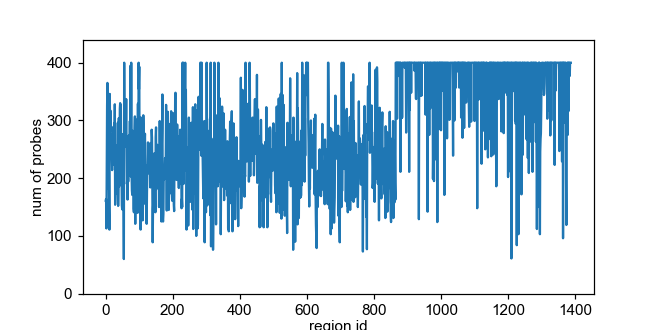

In [49]:
pb_num_dict = {_k:len(_v.kept_probes) for _k,_v in filtered_pb_dict.items()}

pb_nums = np.array(list(pb_num_dict.values()))
plt.figure(figsize=(6,3), dpi=100)
plt.plot(pb_nums)
#plt.plot(np.ones(len(pb_nums))*20)
plt.ylabel(f"num of probes", labelpad=1)
plt.xlabel(f"region id", labelpad=1)
plt.ylim([0, num_probes_kept*1.1])
plt.savefig(os.path.join(report_folder, 'nProbes_per_region.png'), transparent=True)
plt.show()

In [54]:
chr_2_region_savefile = os.path.join(library_folder, 'chr_2_final_region_num.pkl')
overwrite = False

filtered_reg_names = {}
for _reg, _pbde in filtered_pb_dict.items():
    if len(_pbde.kept_probes) > 0:
        filtered_reg_names[_reg] = list(_pbde.kept_probes.values())[0]['reg_name']

if not os.path.exists(chr_2_region_savefile) or overwrite:
    chr_2_region_num = {}
    for _reg, _info in filtered_reg_names.items():
        _chr = _info.split('_')[0].split(':')[0]
        if _chr not in chr_2_region_num:
            chr_2_region_num[_chr] = 1
        else:
            chr_2_region_num[_chr] += 1
    print(f"Saving into file: {chr_2_region_savefile}")

    pickle.dump(chr_2_region_num, open(chr_2_region_savefile, 'wb'))
else:
    print(f"loading from file: {chr_2_region_savefile}")
    chr_2_region_num = pickle.load(open(chr_2_region_savefile, 'rb'))

loading from file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\chr_2_final_region_num.pkl


In [52]:
print(chr_2_region_num)

{'17': 46, '4': 84, '15': 34, '20': 49, '10': 63, '8': 63, '5': 100, '1': 130, '14': 41, '6': 63, '2': 96, '13': 21, '11': 79, '12': 74, '18': 37, '3': 94, 'X': 12, '19': 38, '7': 112, '16': 51, '9': 60, '21': 17, '22': 24}


In [55]:
#
reg_2_start = {}

for _name, _info in filtered_reg_names.items():
    _locus = _info.split('_')[0]
    _start,_end = _locus.split(':')[1].split('-')
    reg_2_start[_name] = int(_start)
#    
chr_2_region_names = {}

for _reg, _info in filtered_reg_names.items():
    _chr = _info.split('_')[0].split(':')[0]
    if _chr not in chr_2_region_names:
        chr_2_region_names[_chr] = [_reg]
    else:
        chr_2_region_names[_chr].append(_reg)
# sort
for _chr, _regs in chr_2_region_names.items():
    _sorted_regs = sorted(_regs, key=lambda _r: reg_2_start[_r])
    chr_2_region_names[_chr] = _sorted_regs

In [56]:
chr_2_region_names['1']

['hSE-0',
 'PRDM16',
 'PRDM16_enhancer-0',
 'PRDM16_enhancer-1',
 'PRDM16_enhancer-2',
 'PRDM16_enhancer-3',
 'PRDM16_enhancer-4',
 'hSE-1',
 'hSE-2',
 'hSE-3',
 'hSE-4',
 'hSE-5',
 'hSE-6',
 'hSE-7',
 'SRARP',
 'hSE-8',
 'hSE-9',
 'hSE-10',
 'C1QC',
 'C1QC_enhancer-5',
 'hSE-11',
 'ID3',
 'hSE-13',
 'CD52',
 'hSE-14',
 'PTPRU',
 'hSE-15',
 'PTPRU_enhancer-6',
 'hSE-16',
 'LAPTM5',
 'MARCKSL1',
 'hSE-17',
 'hSE-18',
 'hSE-19',
 'hSE-20',
 'CSF3R',
 'RSPO1',
 'POU3F1',
 'COL9A2',
 'hSE-21',
 'hSE-22',
 'hSE-23',
 'TAL1',
 'RAB3B',
 'ROR1',
 'ROR1_enhancer-7',
 'PTGER3',
 'hSE-25',
 'SLC44A5',
 'ST6GALNAC5',
 'IFI44L',
 'hSE-26',
 'hSE-27',
 'hSE-28',
 'COL24A1_enhancer-8',
 'COL24A1',
 'LMO4_enhancer-9',
 'LMO4',
 'hSE-29',
 'hSE-30',
 'F3',
 'F3_enhancer-10',
 'F3_enhancer-11',
 'F3_enhancer-12',
 'OLFM3_enhancer-13',
 'OLFM3_enhancer-14',
 'OLFM3_enhancer-15',
 'OLFM3_enhancer-16',
 'OLFM3_enhancer-17',
 'OLFM3_enhancer-18',
 'OLFM3_enhancer-19',
 'OLFM3',
 'OLFM3_enhancer-20',
 'FNDC

In [152]:
chr_2_region_name_savefile = os.path.join(library_folder, 'chr_2_region_names.pkl')

if not os.path.exists(chr_2_region_name_savefile):
    print(chr_2_region_name_savefile)
    pickle.dump(chr_2_region_names, open(chr_2_region_name_savefile, 'wb'))

\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\chr_2_region_names.pkl


In [64]:
## specifically for this iteration, fix the bug in name
for _reg_name, _pbde in filtered_pb_dict.items():
    for _pb in _pbde.kept_probes:
        if '_enhancer' in _pbde.kept_probes[_pb]['reg_name']:
            _pbde.kept_probes[_pb]['reg_name'] = _pbde.kept_probes[_pb]['reg_name'].replace('_enhancer', '-enhancer')
            _pbde.kept_probes[_pb]['name'] = _pbde.kept_probes[_pb]['name'].replace('_enhancer', '-enhancer')

In [65]:
list(list(filtered_pb_dict.values())[51].kept_probes.values())[0]

{'name': '12:523332-543831_strand_+_gene_B4GALNT3-enhancer-323_reg_773_pb_32',
 'reg_index': 773,
 'reg_name': '12:523332-543831_strand_+_gene_B4GALNT3-enhancer-323',
 'pb_index': 32,
 'strand': '+',
 'gc': 0.35714285714285715,
 'tm': 73.24784499371253,
 'map_genome': 34,
 'map_transcriptome': 0,
 'map_rep_genome': 0,
 'map_self_sequences': 26,
 'map_ref_library': 0}

In [155]:
# clear memory
del(_pbde)
del(_pb_class)

<a id='3'></a>
# 3. Load and asssemble probes

<a id='3.1'></a>
## 3.1 design readout mapping dict (region_to_readout)

load directly from http://localhost:8888/notebooks/Chromatin_Analysis_Scripts/Library_design/CTP-14-human_brain_genome/Design_CTP14-promoter_enhancer_codebook.ipynb

In [66]:
# summarize total readout usage
region_2_readout_dict = pickle.load(open(os.path.join(library_folder, 'region_2_readout.pkl'), 'rb'))
len(region_2_readout_dict)

1388

In [67]:
region_2_readout_dict

{'hSE-0': ['c45', 'c88', 'c89'],
 'PRDM16': ['c34', 'c53', 'c56'],
 'PRDM16_enhancer-0': ['c4', 'c16', 'c21'],
 'PRDM16_enhancer-1': ['c46', 'c84', 'c87'],
 'PRDM16_enhancer-2': ['c25', 'c95', 'c113'],
 'PRDM16_enhancer-3': ['c36', 'c52', 'c57'],
 'PRDM16_enhancer-4': ['c28', 'c62', 'c83'],
 'hSE-1': ['c0', 'c37', 'c47'],
 'hSE-2': ['c54', 'c78', 'c104'],
 'hSE-3': ['c7', 'c55', 'c69'],
 'hSE-4': ['c2', 'c17', 'c20'],
 'hSE-5': ['c24', 'c80', 'c108'],
 'hSE-6': ['c9', 'c41', 'c49'],
 'hSE-7': ['c5', 'c60', 'c77'],
 'SRARP': ['c35', 'c61', 'c76'],
 'hSE-8': ['c40', 'c88', 'c111'],
 'hSE-9': ['c1', 'c8', 'c12'],
 'hSE-10': ['c48', 'c81', 'c106'],
 'C1QC': ['c30', 'c97', 'c105'],
 'C1QC_enhancer-5': ['c3', 'c71', 'c90'],
 'hSE-11': ['c14', 'c29', 'c34'],
 'ID3': ['c11', 'c63', 'c75'],
 'hSE-13': ['c27', 'c92', 'c107'],
 'CD52': ['c10', 'c53', 'c72'],
 'hSE-14': ['c4', 'c85', 'c109'],
 'PTPRU': ['c58', 'c77', 'c98'],
 'hSE-15': ['c21', 'c96', 'c100'],
 'PTPRU_enhancer-6': ['c31', 'c43', 'c

<a id='3.2'></a>
## 3.2 loading components

### primers
pick primer set 6,11

In [68]:
from ImageAnalysis3 import library_tools
primer_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Primers'
primers = library_tools.assemble.load_primers([6,11], _primer_folder=primer_folder)

- Picked primer: ID: W1A07_primer_6
Name: W1A07_primer_6
Description: W1A07_primer_6
Number of features: 0
Seq('CGCAAACTGGTGCGGAAGGC')
- Picked primer: ID: W1A12_primer_11
Name: W1A12_primer_11
Description: W1A12_primer_11
Number of features: 0
Seq('TAATACGACTCACTATAGGGCCATTGCCCGCGAGGTCGAG')


## Load readouts

In [69]:
# collect types from region_2_readout_dict
readout_usage_by_type = {}
for _region, _infos in region_2_readout_dict.items():
    for _info in _infos:
        if _info[0] not in readout_usage_by_type:
            readout_usage_by_type[_info[0]] = []
        if int(_info[1:]) not in readout_usage_by_type[_info[0]]:
            readout_usage_by_type[_info[0]].append(int(_info[1:]))

readout_usage_dict = {_type:len(_v) for _type,_v in readout_usage_by_type.items()}

In [70]:
from ImageAnalysis3.classes import _allowed_kwds

readout_dict ={}
overwrite_readout_usage = True
readout_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Readouts\selected_NDB_sets'


# combo
readout_type = 'combo'
# 
_type_char = _allowed_kwds[readout_type]
_readout_start = 0
_num_color = 3

readout_dict[_type_char] = library_tools.assemble.load_readouts(readout_usage_dict[_type_char], 
                                                       _type='highest_snr_before_630', 
                                                       _readout_folder=readout_folder, 
                                                       _num_colors=_num_color, # 750,647,561
                                                       _start_id=_readout_start,
                                                       )

In [72]:
# save
readout_usage_file = os.path.join(library_folder, 'readout_usage.pkl')
if not os.path.isfile(readout_usage_file) or overwrite_readout_usage:
    print(f'save to file: {readout_usage_file}')
    pickle.dump(readout_dict, open(readout_usage_file, 'wb'))

save to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\readout_usage.pkl


<a id='3.3'></a>
## 3.3 assemble probes

In [73]:
reload(library_tools.assemble)
from ImageAnalysis3.library_tools.assemble import Assemble_probes

# params
assemble_params = {
    'primer_len':20,
    'num_readout_per_probe':4, 
}

In [74]:
# run assembly
cand_probes, readout_summary = Assemble_probes(library_folder, filtered_pb_dict, 
                                               region_2_readout_dict, readout_dict, primers, 
                                               primer_len=assemble_params['primer_len'], 
                                               num_readout_per_probe=assemble_params['num_readout_per_probe'], 
                                               unique_readout_per_probe=True,
                                               rc_targets=False, overwrite=True)

- Assemble probes by given target sequences, readouts and primers.
-- included readout types: ['c']
--- assemblying 161 probes in region: ABCA8
--- assemblying 164 probes in region: ABCA8_enhancer-374
--- assemblying 113 probes in region: ABCG2
--- assemblying 231 probes in region: ACSBG1
--- assemblying 326 probes in region: ACSS1
--- assemblying 365 probes in region: ACSS1_enhancer-410
--- assemblying 243 probes in region: ACSS1_enhancer-411
--- assemblying 182 probes in region: ACSS1_enhancer-412
--- assemblying 250 probes in region: ACSS1_enhancer-413
--- assemblying 240 probes in region: ACTA2
--- assemblying 152 probes in region: ADAM28
--- assemblying 111 probes in region: ADAM3A
--- assemblying 346 probes in region: ADAMTS2
--- assemblying 281 probes in region: ADAMTS4
--- assemblying 317 probes in region: ADCY4
--- assemblying 278 probes in region: ADGRF5
--- assemblying 269 probes in region: ADRA1B
--- assemblying 247 probes in region: AGT
--- assemblying 242 probes in region

--- assemblying 224 probes in region: COL14A1
--- assemblying 299 probes in region: COL15A1
--- assemblying 244 probes in region: COL1A2
--- assemblying 176 probes in region: COL21A1
--- assemblying 253 probes in region: COL23A1
--- assemblying 173 probes in region: COL24A1
--- assemblying 125 probes in region: COL24A1_enhancer-8
--- assemblying 247 probes in region: COL25A1
--- assemblying 284 probes in region: COL25A1_enhancer-107
--- assemblying 345 probes in region: COL25A1_enhancer-108
--- assemblying 129 probes in region: COL25A1_enhancer-109
--- assemblying 125 probes in region: COL25A1_enhancer-110
--- assemblying 138 probes in region: COL25A1_enhancer-111
--- assemblying 211 probes in region: COL4A5
--- assemblying 198 probes in region: COL6A2
--- assemblying 218 probes in region: COL9A2
--- assemblying 217 probes in region: COLEC12
--- assemblying 235 probes in region: COLEC12_enhancer-377
--- assemblying 217 probes in region: CORIN
--- assemblying 225 probes in region: CPED1

--- assemblying 244 probes in region: GLI3_enhancer-199
--- assemblying 230 probes in region: GLI3_enhancer-200
--- assemblying 120 probes in region: GLI3_enhancer-201
--- assemblying 276 probes in region: GLRA1
--- assemblying 211 probes in region: GNG11
--- assemblying 309 probes in region: GRIA1
--- assemblying 245 probes in region: GRIK1
--- assemblying 186 probes in region: GRIK1_enhancer-415
--- assemblying 189 probes in region: GRIK1_enhancer-416
--- assemblying 400 probes in region: GRIK1_enhancer-417
--- assemblying 289 probes in region: GRIK1_enhancer-418
--- assemblying 194 probes in region: GRIK1_enhancer-419
--- assemblying 339 probes in region: GRIN2C
--- assemblying 258 probes in region: GRIN2C_enhancer-375
--- assemblying 286 probes in region: GRIN2C_enhancer-376
--- assemblying 266 probes in region: GRIN3A
--- assemblying 103 probes in region: GRIN3A_enhancer-265
--- assemblying 187 probes in region: GRIN3A_enhancer-266
--- assemblying 191 probes in region: GRIN3A_enha

--- assemblying 218 probes in region: NPNT
--- assemblying 239 probes in region: NPSR1
--- assemblying 222 probes in region: NPSR1_enhancer-188
--- assemblying 250 probes in region: NPTX1
--- assemblying 213 probes in region: NPY
--- assemblying 238 probes in region: NPY2R
--- assemblying 295 probes in region: NR2F2
--- assemblying 229 probes in region: NR2F2_enhancer-358
--- assemblying 241 probes in region: NR2F2_enhancer-359
--- assemblying 278 probes in region: NR4A1
--- assemblying 266 probes in region: NR4A2
--- assemblying 188 probes in region: NR4A2_enhancer-48
--- assemblying 174 probes in region: NR4A2_enhancer-49
--- assemblying 185 probes in region: NR4A2_enhancer-50
--- assemblying 176 probes in region: NR4A2_enhancer-51
--- assemblying 141 probes in region: NR4A2_enhancer-52
--- assemblying 324 probes in region: NRGN
--- assemblying 158 probes in region: NRGN_enhancer-315
--- assemblying 233 probes in region: NRGN_enhancer-316
--- assemblying 156 probes in region: NRGN_en

--- assemblying 208 probes in region: ROR1_enhancer-7
--- assemblying 228 probes in region: RORB
--- assemblying 193 probes in region: RORB_enhancer-255
--- assemblying 155 probes in region: RORB_enhancer-256
--- assemblying 400 probes in region: RORB_enhancer-257
--- assemblying 400 probes in region: RORB_enhancer-258
--- assemblying 341 probes in region: RORB_enhancer-259
--- assemblying 234 probes in region: RPRML
--- assemblying 288 probes in region: RSPO1
--- assemblying 147 probes in region: RXFP1
--- assemblying 202 probes in region: RXFP2
--- assemblying 279 probes in region: S100A4
--- assemblying 103 probes in region: SAMSN1
--- assemblying 286 probes in region: SATB2
--- assemblying 154 probes in region: SCD5
--- assemblying 113 probes in region: SCDP1
--- assemblying 255 probes in region: SCGN
--- assemblying 280 probes in region: SDC4
--- assemblying 240 probes in region: SELENOP
--- assemblying 277 probes in region: SELPLG
--- assemblying 210 probes in region: SEMA3E
--- 

--- assemblying 314 probes in region: TUNAR
--- assemblying 190 probes in region: TYROBP
--- assemblying 214 probes in region: UBASH3B
--- assemblying 233 probes in region: UGT8
--- assemblying 206 probes in region: UGT8_enhancer-112
--- assemblying 251 probes in region: UGT8_enhancer-113
--- assemblying 192 probes in region: UGT8_enhancer-114
--- assemblying 172 probes in region: UGT8_enhancer-115
--- assemblying 231 probes in region: UNC13C
--- assemblying 131 probes in region: UNC13C_enhancer-355
--- assemblying 290 probes in region: UNC5B
--- assemblying 216 probes in region: UST
--- assemblying 270 probes in region: VAT1L
--- assemblying 206 probes in region: VIP
--- assemblying 280 probes in region: VIPR2
--- assemblying 142 probes in region: VIP_enhancer-169
--- assemblying 150 probes in region: VIP_enhancer-170
--- assemblying 159 probes in region: VIP_enhancer-171
--- assemblying 277 probes in region: VTN
--- assemblying 270 probes in region: VWC2
--- assemblying 241 probes in

--- assemblying 283 probes in region: hSE-23
--- assemblying 400 probes in region: hSE-230
--- assemblying 400 probes in region: hSE-231
--- assemblying 362 probes in region: hSE-232
--- assemblying 400 probes in region: hSE-233
--- assemblying 400 probes in region: hSE-234
--- assemblying 351 probes in region: hSE-235
--- assemblying 400 probes in region: hSE-236
--- assemblying 400 probes in region: hSE-238
--- assemblying 369 probes in region: hSE-239
--- assemblying 171 probes in region: hSE-240
--- assemblying 400 probes in region: hSE-241
--- assemblying 285 probes in region: hSE-242
--- assemblying 400 probes in region: hSE-243
--- assemblying 400 probes in region: hSE-244
--- assemblying 400 probes in region: hSE-245
--- assemblying 400 probes in region: hSE-246
--- assemblying 400 probes in region: hSE-247
--- assemblying 269 probes in region: hSE-248
--- assemblying 400 probes in region: hSE-249
--- assemblying 400 probes in region: hSE-25
--- assemblying 400 probes in region

--- assemblying 346 probes in region: hSE-402
--- assemblying 281 probes in region: hSE-403
--- assemblying 344 probes in region: hSE-404
--- assemblying 400 probes in region: hSE-405
--- assemblying 400 probes in region: hSE-406
--- assemblying 400 probes in region: hSE-407
--- assemblying 400 probes in region: hSE-408
--- assemblying 400 probes in region: hSE-41
--- assemblying 278 probes in region: hSE-410
--- assemblying 400 probes in region: hSE-411
--- assemblying 347 probes in region: hSE-412
--- assemblying 400 probes in region: hSE-413
--- assemblying 390 probes in region: hSE-414
--- assemblying 400 probes in region: hSE-415
--- assemblying 400 probes in region: hSE-416
--- assemblying 400 probes in region: hSE-417
--- assemblying 400 probes in region: hSE-418
--- assemblying 400 probes in region: hSE-419
--- assemblying 400 probes in region: hSE-42
--- assemblying 344 probes in region: hSE-421
--- assemblying 400 probes in region: hSE-422
--- assemblying 202 probes in region

--- assemblying 400 probes in region: hSE-71
--- assemblying 229 probes in region: hSE-72
--- assemblying 400 probes in region: hSE-73
--- assemblying 400 probes in region: hSE-74
--- assemblying 96 probes in region: hSE-75
--- assemblying 400 probes in region: hSE-76
--- assemblying 330 probes in region: hSE-77
--- assemblying 400 probes in region: hSE-78
--- assemblying 400 probes in region: hSE-79
--- assemblying 400 probes in region: hSE-8
--- assemblying 296 probes in region: hSE-80
--- assemblying 400 probes in region: hSE-81
--- assemblying 400 probes in region: hSE-82
--- assemblying 199 probes in region: hSE-83
--- assemblying 119 probes in region: hSE-84
--- assemblying 341 probes in region: hSE-85
--- assemblying 291 probes in region: hSE-86
--- assemblying 400 probes in region: hSE-87
--- assemblying 275 probes in region: hSE-88
--- assemblying 400 probes in region: hSE-89
--- assemblying 316 probes in region: hSE-9
--- assemblying 400 probes in region: hSE-90
--- assemblyi

# 4.Check quality


## 4.1 Load probes

Checking procedures could restart from here

In [75]:
# folder for this library
# candidate full-length probe filename
candidate_basename = 'candidate_probes.fasta' # old version
# load full probes
full_records = []
with open(os.path.join(library_folder, candidate_basename), 'r') as handle:
    for record in SeqIO.parse(handle, "fasta"):
        full_records.append(record)

print(f"Total probe loaded: {len(full_records)}")

Total probe loaded: 392198


### Manually input the following info to double check!

In [76]:
from ImageAnalysis3 import library_tools

num_readout_per_probe = 4
primer_len=20
target_len=42
min_num_probes = 40
# merfish related
num_on_bits = 3 ### Manually input the following info to double check!

primer_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Primers'
primers = library_tools.assemble.load_primers([6,11], _primer_folder=primer_folder)

- Picked primer: ID: W1A07_primer_6
Name: W1A07_primer_6
Description: W1A07_primer_6
Number of features: 0
Seq('CGCAAACTGGTGCGGAAGGC')
- Picked primer: ID: W1A12_primer_11
Name: W1A12_primer_11
Description: W1A12_primer_11
Number of features: 0
Seq('TAATACGACTCACTATAGGGCCATTGCCCGCGAGGTCGAG')


### 4.1.1 check primer usage

In [77]:
import ImageAnalysis3.library_tools.quality_check as check
reload(check)
primer_check = check._check_primer_usage(full_records, primers[0], primers[1], primer_len=primer_len)
print(primer_check)

-- Checking primer usage, total probes: 392198
True


### 4.1.2 check region probe number

In [78]:
reload(check)
reg_size_dic, len_check = check._check_region_size(full_records, 
                                                   min_size=min_num_probes)
print(len_check)

gene: ABCA8 -> 161
gene: ABCA8-enhancer-374 -> 164
gene: ABCG2 -> 113
gene: ACSBG1 -> 231
gene: ACSS1 -> 326
gene: ACSS1-enhancer-410 -> 365
gene: ACSS1-enhancer-411 -> 243
gene: ACSS1-enhancer-412 -> 182
gene: ACSS1-enhancer-413 -> 250
gene: ACTA2 -> 240
gene: ADAM28 -> 152
gene: ADAM3A -> 111
gene: ADAMTS2 -> 346
gene: ADAMTS4 -> 281
gene: ADCY4 -> 317
gene: ADGRF5 -> 278
gene: ADRA1B -> 269
gene: AGT -> 247
gene: AGT-enhancer-27 -> 242
gene: AGT-enhancer-28 -> 214
gene: ALK -> 271
gene: ALK-enhancer-31 -> 236
gene: ALOX5AP -> 282
gene: ANK1 -> 289
gene: ANK1-enhancer-233 -> 223
gene: ANK1-enhancer-234 -> 295
gene: ANK1-enhancer-235 -> 238
gene: ANK1-enhancer-236 -> 328
gene: ANK1-enhancer-237 -> 154
gene: ANKFN1 -> 177
gene: ANO3 -> 173
gene: ANO4 -> 242
gene: APBB1IP -> 215
gene: AQP4 -> 257
gene: AQP4-enhancer-381 -> 226
gene: AQP4-enhancer-382 -> 178
gene: AQP4-enhancer-383 -> 296
gene: AQP4-enhancer-384 -> 152
gene: AQP4-enhancer-385 -> 202
gene: ARL4C -> 304
gene: ARPP19 -> 186

<IPython.core.display.Javascript object>


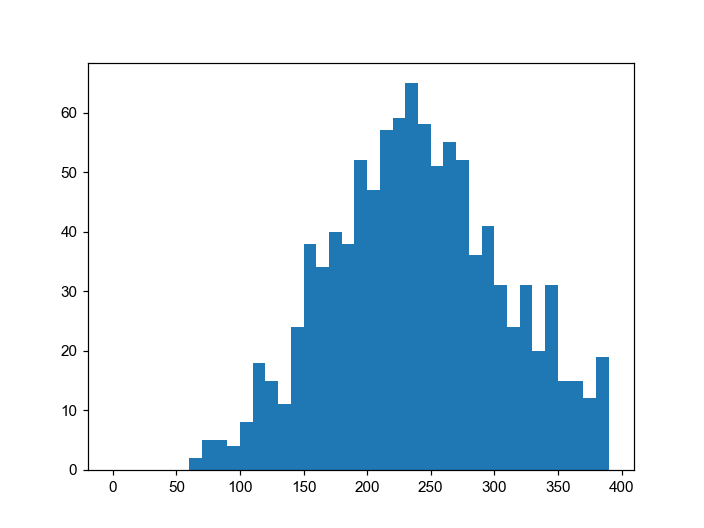

In [79]:
plt.figure()
plt.hist(list(reg_size_dic.values()), bins=np.arange(0,400,10))
plt.show()

### 4.1.3 check readout usage for each gene

In [80]:
reload(check)
check_readout_dict = pickle.load(open(os.path.join(library_folder, 'readout_usage.pkl'), 'rb'))

reg_readout_dic, reg2readout_check = check._check_region_to_readouts(full_records, check_readout_dict, 
                                                                     total_readout_num=num_on_bits)
print(reg2readout_check)

ABCA8 -> ['NDB_466', 'NDB_618', 'NDB_421']
ABCA8-enhancer-374 -> ['NDB_511', 'NDB_396', 'NDB_459']
ABCG2 -> ['NDB_456', 'NDB_459', 'NDB_519']
ACSBG1 -> ['NDB_433', 'NDB_614', 'NDB_625']
ACSS1 -> ['NDB_508', 'NDB_397', 'NDB_445']
ACSS1-enhancer-410 -> ['NDB_536', 'NDB_459', 'NDB_628']
ACSS1-enhancer-411 -> ['NDB_456', 'NDB_618', 'NDB_372']
ACSS1-enhancer-412 -> ['NDB_431', 'NDB_482', 'NDB_505']
ACSS1-enhancer-413 -> ['NDB_405', 'NDB_491', 'NDB_401']
ACTA2 -> ['NDB_482', 'NDB_519', 'NDB_513']
ADAM28 -> ['NDB_618', 'NDB_606', 'NDB_371']
ADAM3A -> ['NDB_487', 'NDB_536', 'NDB_390']
ADAMTS2 -> ['NDB_516', 'NDB_384', 'NDB_439']
ADAMTS4 -> ['NDB_403', 'NDB_628', 'NDB_395']
ADCY4 -> ['NDB_529', 'NDB_396', 'NDB_594']
ADGRF5 -> ['NDB_446', 'NDB_513', 'NDB_585']
ADRA1B -> ['NDB_385', 'NDB_622', 'NDB_517']
AGT -> ['NDB_533', 'NDB_397', 'NDB_628']
AGT-enhancer-27 -> ['NDB_487', 'NDB_405', 'NDB_616']
AGT-enhancer-28 -> ['NDB_568', 'NDB_432', 'NDB_443']
ALK -> ['NDB_615', 'NDB_379', 'NDB_495']
ALK-enh

### 4.1.4 check readout usage in the library

In [82]:
reload(check)
readout_reg_dic, readout2reg_check = check._check_readout_to_region(reg_readout_dic, full_records, 
                                                                    check_readout_dict, primer_len=primer_len, 
                                                                    target_len=target_len,
                                                                    probe_readout_num=num_readout_per_probe)
print(readout2reg_check)

-- extracting probes from >region:ABCA8, region:ABCA8-enhancer-374, region:ABCG2, region:ACSBG1, region:ACSS1, region:ACSS1-enhancer-410, region:ACSS1-enhancer-411, region:ACSS1-enhancer-412, region:ACSS1-enhancer-413, region:ACTA2, region:ADAM28, region:ADAM3A, region:ADAMTS2, region:ADAMTS4, region:ADCY4, region:ADGRF5, region:ADRA1B, region:AGT, region:AGT-enhancer-27, region:AGT-enhancer-28, region:ALK, region:ALK-enhancer-31, region:ALOX5AP, region:ANK1, region:ANK1-enhancer-233, region:ANK1-enhancer-234, region:ANK1-enhancer-235, region:ANK1-enhancer-236, region:ANK1-enhancer-237, region:ANKFN1, region:ANO3, region:ANO4, region:APBB1IP, region:AQP4, region:AQP4-enhancer-381, region:AQP4-enhancer-382, region:AQP4-enhancer-383, region:AQP4-enhancer-384, region:AQP4-enhancer-385, region:ARL4C, region:ARPP19, region:ARPP21, region:ARPP21-enhancer-66, region:ARPP21-enhancer-67, region:ARX, region:ASIC4, region:ATP1B2, region:ATP2B1, region:ATP2B1-enhancer-325, region:B4GALNT2, region:

region:LDB2-enhancer-96, region:LDB2-enhancer-97, region:LDB2-enhancer-98, region:LDB2-enhancer-99, region:LEF1, region:LGI2, region:LHX6, region:LHX6-enhancer-269, region:LHX6-enhancer-270, region:LHX6-enhancer-271, region:LHX6-enhancer-272, region:LHX6-enhancer-273, region:LHX6-enhancer-274, region:LHX6-enhancer-275, region:LMO1, region:LMO3, region:LMO4, region:LMO4-enhancer-9, region:LPAR5, region:LRATD2, region:LSP1, region:LTF, region:LY86, region:LYPD1, region:LYPD1-enhancer-35, region:LYZL4, region:MAF, region:MAFB, region:MAF-enhancer-367, region:MAF-enhancer-368, region:MAF-enhancer-369, region:MAF-enhancer-370, region:MAG, region:MAG-enhancer-400, region:MAG-enhancer-401, region:MAG-enhancer-402, region:MAL, region:MAP6D1, region:MAP6D1-enhancer-84, region:MARCKSL1, region:MCTP1, region:MCTP1-enhancer-141, region:MCTP1-enhancer-142, region:MCTP1-enhancer-143, region:MCTP1-enhancer-144, region:MEIS2, region:MEIS2-enhancer-352, region:MEIS2-enhancer-353, region:MEIS2-enhancer-

region:WNT7B, region:ZDHHC23, region:ZDHHC23-enhancer-72, region:ZDHHC23-enhancer-73, region:ZDHHC23-enhancer-74, region:ZDHHC23-enhancer-75, region:ZDHHC23-enhancer-76, region:ZFHX3, region:ZFP36L1, region:ZNF385D, region:ZNF536, region:ZNF536-enhancer-394, region:ZNF536-enhancer-395, region:ZNF536-enhancer-396, region:ZNF536-enhancer-397, region:ZNF536-enhancer-398, region:ZNF536-enhancer-399, region:hSE-0, region:hSE-1, region:hSE-10, region:hSE-100, region:hSE-101, region:hSE-102, region:hSE-103, region:hSE-104, region:hSE-105, region:hSE-106, region:hSE-107, region:hSE-108, region:hSE-109, region:hSE-11, region:hSE-110, region:hSE-111, region:hSE-112, region:hSE-113, region:hSE-114, region:hSE-115, region:hSE-116, region:hSE-117, region:hSE-118, region:hSE-119, region:hSE-120, region:hSE-121, region:hSE-122, region:hSE-123, region:hSE-124, region:hSE-125, region:hSE-126, region:hSE-127, region:hSE-129, region:hSE-13, region:hSE-130, region:hSE-131, region:hSE-132, region:hSE-133, 

region:hSE-74, region:hSE-75, region:hSE-76, region:hSE-77, region:hSE-78, region:hSE-79, region:hSE-8, region:hSE-80, region:hSE-81, region:hSE-82, region:hSE-83, region:hSE-84, region:hSE-85, region:hSE-86, region:hSE-87, region:hSE-88, region:hSE-89, region:hSE-9, region:hSE-90, region:hSE-91, region:hSE-93, region:hSE-94, region:hSE-96, region:hSE-98, region:hSE-99, {'NDB_466': ['ABCA8', 'ABCA8', 'ABCA8', 'ABCA8', 'ANK1-enhancer-234', 'ANK1-enhancer-234', 'ANK1-enhancer-234', 'ANK1-enhancer-234', 'BDNF', 'BDNF', 'BDNF', 'BDNF', 'BTBD11', 'BTBD11', 'BTBD11', 'BTBD11', 'COL14A1', 'COL14A1', 'COL14A1', 'COL14A1', 'DMKN', 'DMKN', 'DMKN', 'DMKN', 'EGFR-enhancer-204', 'EGFR-enhancer-204', 'EGFR-enhancer-204', 'EGFR-enhancer-204', 'FA2H-enhancer-365', 'FA2H-enhancer-365', 'FA2H-enhancer-365', 'FA2H-enhancer-365', 'FBXW7-enhancer-116', 'FBXW7-enhancer-116', 'FBXW7-enhancer-116', 'FBXW7-enhancer-116', 'FGFR3-enhancer-90', 'FGFR3-enhancer-90', 'FGFR3-enhancer-90', 'FGFR3-enhancer-90', 'FST',

### 4.1.5 check bewteen probes

In [83]:
# construct internal map
reload(check)
int_map = check._construct_internal_map(full_records, library_folder, save=False) 

In [84]:
# internal check probes
readout_count_dic, readout_count_check = check._check_readout_in_probes(readout_reg_dic, reg_size_dic, int_map, readout_dict)
print(readout_count_check)

True


In [85]:
# check between probes
kept_records, removed_count = check._check_between_probes(full_records, int_map, 
                                                          primer_len=primer_len, 
                                                          target_len=target_len)

--- Sequence:loc_20:25126438-25146937_gene_ACSS1-enhancer-411_pb_36_pos_3869_strand_-_readouts_[NDB_456_c,NDB_456_c,NDB_456_c,NDB_456_c]_primers_[W1A07_primer_6,W1A12_primer_11] got hits:94, dumped
--- Sequence:loc_20:25126438-25146937_gene_ACSS1-enhancer-411_pb_37_pos_3914_strand_+_readouts_[NDB_618_c,NDB_618_c,NDB_618_c,NDB_618_c]_primers_[W1A07_primer_6,W1A12_primer_11] got hits:80, dumped
--- Sequence:loc_20:25126438-25146937_gene_ACSS1-enhancer-411_pb_41_pos_4124_strand_+_readouts_[NDB_372_c,NDB_372_c,NDB_372_c,NDB_372_c]_primers_[W1A07_primer_6,W1A12_primer_11] got hits:73, dumped
--- Sequence:loc_10:88978839-89003839_gene_ACTA2_pb_142_pos_17135_strand_-_readouts_[NDB_519_c,NDB_519_c,NDB_519_c,NDB_519_c]_primers_[W1A07_primer_6,W1A12_primer_11] got hits:65, dumped
--- Sequence:loc_8:41655630-41681691_gene_ANK1-enhancer-234_pb_201_pos_16200_strand_-_readouts_[NDB_466_c,NDB_466_c,NDB_466_c,NDB_466_c]_primers_[W1A07_primer_6,W1A12_primer_11] got hits:55, dumped
--- Sequence:loc_8:41

--- Sequence:loc_2:170495808-170516307_gene_GAD1-enhancer-53_pb_78_pos_7661_strand_+_readouts_[NDB_539_c,NDB_539_c,NDB_539_c,NDB_539_c]_primers_[W1A07_primer_6,W1A12_primer_11] got hits:51, dumped
--- Sequence:loc_7:150735228-150760228_gene_GIMAP3P_pb_116_pos_12706_strand_+_readouts_[NDB_445_c,NDB_445_c,NDB_445_c,NDB_445_c]_primers_[W1A07_primer_6,W1A12_primer_11] got hits:51, dumped
--- Sequence:loc_7:93909235-93934235_gene_GNG11_pb_12_pos_1859_strand_+_readouts_[NDB_456_c,NDB_456_c,NDB_456_c,NDB_456_c]_primers_[W1A07_primer_6,W1A12_primer_11] got hits:52, dumped
--- Sequence:loc_7:93909235-93934235_gene_GNG11_pb_44_pos_6053_strand_+_readouts_[NDB_390_c,NDB_390_c,NDB_390_c,NDB_390_c]_primers_[W1A07_primer_6,W1A12_primer_11] got hits:52, dumped
--- Sequence:loc_17:74797919-74818418_gene_GRIN2C-enhancer-376_pb_227_pos_16325_strand_+_readouts_[NDB_409_c,NDB_409_c,NDB_409_c,NDB_409_c]_primers_[W1A07_primer_6,W1A12_primer_11] got hits:52, dumped
--- Sequence:loc_17:74797919-74818418_gene_G

--- Sequence:loc_14:73224997-73249997_gene_PAPLN_pb_256_pos_22489_strand_+_readouts_[NDB_506_c,NDB_506_c,NDB_506_c,NDB_506_c]_primers_[W1A07_primer_6,W1A12_primer_11] got hits:75, dumped
--- Sequence:loc_14:73224997-73249997_gene_PAPLN_pb_260_pos_22858_strand_+_readouts_[NDB_507_c,NDB_507_c,NDB_507_c,NDB_507_c]_primers_[W1A07_primer_6,W1A12_primer_11] got hits:73, dumped
--- Sequence:loc_14:73224997-73249997_gene_PAPLN_pb_262_pos_23042_strand_+_readouts_[NDB_506_c,NDB_506_c,NDB_506_c,NDB_506_c]_primers_[W1A07_primer_6,W1A12_primer_11] got hits:88, dumped
--- Sequence:loc_14:73224997-73249997_gene_PAPLN_pb_263_pos_23139_strand_-_readouts_[NDB_507_c,NDB_507_c,NDB_507_c,NDB_507_c]_primers_[W1A07_primer_6,W1A12_primer_11] got hits:89, dumped
--- Sequence:loc_14:73224997-73249997_gene_PAPLN_pb_264_pos_23220_strand_+_readouts_[NDB_431_c,NDB_431_c,NDB_431_c,NDB_431_c]_primers_[W1A07_primer_6,W1A12_primer_11] got hits:82, dumped
--- Sequence:loc_11:276626-301626_gene_PGGHG_pb_121_pos_10769_str

--- Sequence:loc_1:75598614-75623614_gene_SLC44A5_pb_120_pos_13270_strand_-_readouts_[NDB_396_c,NDB_396_c,NDB_396_c,NDB_396_c]_primers_[W1A07_primer_6,W1A12_primer_11] got hits:51, dumped
--- Sequence:loc_11:16577626-16618126_gene_SOX6-enhancer-308_pb_360_pos_39608_strand_+_readouts_[NDB_446_c,NDB_446_c,NDB_446_c,NDB_446_c]_primers_[W1A07_primer_6,W1A12_primer_11] got hits:98, dumped
--- Sequence:loc_6:169241550-169266550_gene_THBS2_pb_46_pos_3333_strand_-_readouts_[NDB_450_c,NDB_450_c,NDB_450_c,NDB_450_c]_primers_[W1A07_primer_6,W1A12_primer_11] got hits:78, dumped
--- Sequence:loc_6:169241550-169266550_gene_THBS2_pb_48_pos_3553_strand_-_readouts_[NDB_398_c,NDB_398_c,NDB_398_c,NDB_398_c]_primers_[W1A07_primer_6,W1A12_primer_11] got hits:100, dumped
--- Sequence:loc_6:169241550-169266550_gene_THBS2_pb_49_pos_3615_strand_-_readouts_[NDB_450_c,NDB_450_c,NDB_450_c,NDB_450_c]_primers_[W1A07_primer_6,W1A12_primer_11] got hits:106, dumped
--- Sequence:loc_6:169241550-169266550_gene_THBS2_pb_

--- Sequence:loc_4:185710686-185748717_gene_hSE-166_pb_304_pos_29916_strand_+_readouts_[NDB_557_c,NDB_557_c,NDB_557_c,NDB_557_c]_primers_[W1A07_primer_6,W1A12_primer_11] got hits:70, dumped
--- Sequence:loc_4:185710686-185748717_gene_hSE-166_pb_305_pos_29965_strand_+_readouts_[NDB_439_c,NDB_439_c,NDB_439_c,NDB_439_c]_primers_[W1A07_primer_6,W1A12_primer_11] got hits:84, dumped
--- Sequence:loc_4:185710686-185748717_gene_hSE-166_pb_306_pos_30012_strand_+_readouts_[NDB_578_c,NDB_578_c,NDB_578_c,NDB_578_c]_primers_[W1A07_primer_6,W1A12_primer_11] got hits:66, dumped
--- Sequence:loc_5:1477224-1518269_gene_hSE-168_pb_28_pos_34261_strand_+_readouts_[NDB_622_c,NDB_622_c,NDB_622_c,NDB_622_c]_primers_[W1A07_primer_6,W1A12_primer_11] got hits:57, dumped
--- Sequence:loc_5:1477224-1518269_gene_hSE-168_pb_29_pos_34330_strand_+_readouts_[NDB_395_c,NDB_395_c,NDB_395_c,NDB_395_c]_primers_[W1A07_primer_6,W1A12_primer_11] got hits:57, dumped
--- Sequence:loc_5:1477224-1518269_gene_hSE-168_pb_61_pos_36

--- Sequence:loc_7:150962876-150989026_gene_hSE-263_pb_287_pos_23416_strand_+_readouts_[NDB_551_c,NDB_551_c,NDB_551_c,NDB_551_c]_primers_[W1A07_primer_6,W1A12_primer_11] got hits:51, dumped
--- Sequence:loc_8:28577689-28638791_gene_hSE-271_pb_227_pos_41451_strand_+_readouts_[NDB_611_c,NDB_611_c,NDB_611_c,NDB_611_c]_primers_[W1A07_primer_6,W1A12_primer_11] got hits:74, dumped
--- Sequence:loc_8:134531678-134582535_gene_hSE-286_pb_101_pos_11538_strand_+_readouts_[NDB_379_c,NDB_379_c,NDB_379_c,NDB_379_c]_primers_[W1A07_primer_6,W1A12_primer_11] got hits:56, dumped
--- Sequence:loc_8:143485762-143532562_gene_hSE-289_pb_13_pos_968_strand_+_readouts_[NDB_587_c,NDB_587_c,NDB_587_c,NDB_587_c]_primers_[W1A07_primer_6,W1A12_primer_11] got hits:107, dumped
--- Sequence:loc_8:143485762-143532562_gene_hSE-289_pb_14_pos_1019_strand_-_readouts_[NDB_384_c,NDB_384_c,NDB_384_c,NDB_384_c]_primers_[W1A07_primer_6,W1A12_primer_11] got hits:142, dumped
--- Sequence:loc_8:143485762-143532562_gene_hSE-289_pb_

--- Sequence:loc_11:132632559-132655729_gene_hSE-365_pb_254_pos_21946_strand_+_readouts_[NDB_350_c,NDB_350_c,NDB_350_c,NDB_350_c]_primers_[W1A07_primer_6,W1A12_primer_11] got hits:79, dumped
--- Sequence:loc_11:132632559-132655729_gene_hSE-365_pb_259_pos_22236_strand_+_readouts_[NDB_395_c,NDB_395_c,NDB_395_c,NDB_395_c]_primers_[W1A07_primer_6,W1A12_primer_11] got hits:51, dumped
--- Sequence:loc_12:27359843-27396889_gene_hSE-368_pb_32_pos_4258_strand_+_readouts_[NDB_495_c,NDB_495_c,NDB_495_c,NDB_495_c]_primers_[W1A07_primer_6,W1A12_primer_11] got hits:54, dumped
--- Sequence:loc_15:43929987-44041814_gene_hSE-434_pb_199_pos_80932_strand_+_readouts_[NDB_445_c,NDB_445_c,NDB_445_c,NDB_445_c]_primers_[W1A07_primer_6,W1A12_primer_11] got hits:82, dumped
--- Sequence:loc_16:12373787-12436634_gene_hSE-451_pb_309_pos_54877_strand_+_readouts_[NDB_487_c,NDB_487_c,NDB_487_c,NDB_487_c]_primers_[W1A07_primer_6,W1A12_primer_11] got hits:58, dumped
--- Sequence:loc_16:12373787-12436634_gene_hSE-451_pb

--- Sequence:loc_19:40539010-40571140_gene_hSE-521_pb_194_pos_28333_strand_-_readouts_[NDB_606_c,NDB_606_c,NDB_606_c,NDB_606_c]_primers_[W1A07_primer_6,W1A12_primer_11] got hits:51, dumped
--- Sequence:loc_20:16241799-16297292_gene_hSE-529_pb_303_pos_46605_strand_+_readouts_[NDB_448_c,NDB_448_c,NDB_448_c,NDB_448_c]_primers_[W1A07_primer_6,W1A12_primer_11] got hits:73, dumped
--- Sequence:loc_20:16241799-16297292_gene_hSE-529_pb_304_pos_46769_strand_+_readouts_[NDB_452_c,NDB_452_c,NDB_452_c,NDB_452_c]_primers_[W1A07_primer_6,W1A12_primer_11] got hits:52, dumped
--- Sequence:loc_20:16241799-16297292_gene_hSE-529_pb_305_pos_46854_strand_+_readouts_[NDB_526_c,NDB_526_c,NDB_526_c,NDB_526_c]_primers_[W1A07_primer_6,W1A12_primer_11] got hits:88, dumped
--- Sequence:loc_20:16241799-16297292_gene_hSE-529_pb_306_pos_46935_strand_-_readouts_[NDB_448_c,NDB_448_c,NDB_448_c,NDB_448_c]_primers_[W1A07_primer_6,W1A12_primer_11] got hits:86, dumped
--- Sequence:loc_20:16241799-16297292_gene_hSE-529_pb_3

In [87]:
# clear memory
del(int_map)

### 4.1.6 finish checking, save

In [88]:
print(len(kept_records), len(cand_probes))

391762 392198


In [86]:
# save kept records
with open(os.path.join(library_folder, 'filtered_full_probes.fasta'), 'w') as output_handle:
    SeqIO.write(kept_records, output_handle, "fasta")

## 4.2 BLAST screening of probes

create the local blast database by:
```bash
makeblastdb -in C:\Users\puzheng\Documents\Tools\lowercase_masked\Mus_musculus.GRCm38.dna_sm.merged.fa -dbtype nucl -parse_seqids -out GRCm38_ensembl -title "Mouse chromosomes soft masked" -blastdb_version 4![image.png](attachment:image.png)
```

The outputs are:
```bash
Building a new DB, current time: 03/30/2021 21:49:18
New DB name:   C:\Users\puzheng\Documents\Tools\GRCm38_ensembl
New DB title:  Mouse chromosomes soft masked
Sequence type: Nucleotide
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 66 sequences in 42.2668 seconds.
```

### could restart from here

In [89]:
import ImageAnalysis3.library_tools.quality_check as check
reload(check)

<module 'ImageAnalysis3.library_tools.quality_check' from 'E:\\Users\\puzheng_new\\Documents\\Chromatin_Analysis_Scripts\\Library_design\\CTP-14-human_brain_genome\\..\\..\\..\\..\\Documents\\ImageAnalysis3\\library_tools\\quality_check.py'>

In [90]:
if 'kept_records' not in locals() or len(kept_records) == 0:
    kept_records = []
    with open(os.path.join(library_folder, 'filtered_full_probes.fasta'), 'r') as handle:
        for record in SeqIO.parse(handle, "fasta"):
            kept_records.append(record)
print(len(kept_records))

391762


In [91]:
blast_database = os.path.join(reference_folder, 'blast_database', 'hg38')

check.Blast_probes(kept_records, library_folder, num_threads=66, 
                   blast_db=blast_database, blast_evalue=100, overwrite=False)

- Blast probe against \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\human\hg38\blast_database\hg38
-- number of probes loaded: 391762
-- processing region: ABCA8 with 161 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_ABCA8.fasta
--- *blasting region: ABCA8
--- total time for blast ABCA8: 16.923797845840454
-- processing region: ABCA8-enhancer-374 with 164 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_ABCA8-enhancer-374.fasta
--- *blasting region: ABCA8-enhancer-374
--- total time for blast ABCA8-enhancer-374: 10.263111352920532
-- processing region: ABCG2 with 113 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_ABCG2.fasta
--- *blasting region: ABCG2
--- total time for blast A

--- total time for blast ANK1-enhancer-236: 13.255807638168335
-- processing region: ANK1-enhancer-237 with 153 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_ANK1-enhancer-237.fasta
--- *blasting region: ANK1-enhancer-237
--- total time for blast ANK1-enhancer-237: 7.80127477645874
-- processing region: ANKFN1 with 177 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_ANKFN1.fasta
--- *blasting region: ANKFN1
--- total time for blast ANKFN1: 9.374420404434204
-- processing region: ANO3 with 173 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_ANO3.fasta
--- *blasting region: ANO3
--- total time for blast ANO3: 9.825329303741455
-- processing region: ANO4 with 242 probes
--- *writing file: \\10.2

--- total time for blast BARX2-enhancer-321: 16.158524751663208
-- processing region: BARX2-enhancer-322 with 278 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_BARX2-enhancer-322.fasta
--- *blasting region: BARX2-enhancer-322
--- total time for blast BARX2-enhancer-322: 15.018779754638672
-- processing region: BCAS1 with 249 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_BCAS1.fasta
--- *blasting region: BCAS1
--- total time for blast BCAS1: 13.590662002563477
-- processing region: BCL11B with 312 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_BCL11B.fasta
--- *blasting region: BCL11B
--- total time for blast BCL11B: 12.624397039413452
-- processing region: BCL11B-enhancer-351 with 267 prob

--- total time for blast C1QL3: 9.731016635894775
-- processing region: C1QL3-enhancer-282 with 147 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_C1QL3-enhancer-282.fasta
--- *blasting region: C1QL3-enhancer-282
--- total time for blast C1QL3-enhancer-282: 11.447828531265259
-- processing region: C1QL3-enhancer-283 with 141 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_C1QL3-enhancer-283.fasta
--- *blasting region: C1QL3-enhancer-283
--- total time for blast C1QL3-enhancer-283: 8.011459589004517
-- processing region: C1QTNF7 with 267 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_C1QTNF7.fasta
--- *blasting region: C1QTNF7
--- total time for blast C1QTNF7: 14.55643916130066
-- processing r

--- total time for blast CBLN2-enhancer-386: 11.742643117904663
-- processing region: CBLN2-enhancer-387 with 152 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_CBLN2-enhancer-387.fasta
--- *blasting region: CBLN2-enhancer-387
--- total time for blast CBLN2-enhancer-387: 10.948625326156616
-- processing region: CBLN2-enhancer-388 with 309 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_CBLN2-enhancer-388.fasta
--- *blasting region: CBLN2-enhancer-388
--- total time for blast CBLN2-enhancer-388: 12.646367073059082
-- processing region: CBLN2-enhancer-389 with 274 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_CBLN2-enhancer-389.fasta
--- *blasting region: CBLN2-enhancer-389
--- total time for 

--- total time for blast CEMIP: 11.297833442687988
-- processing region: CERCAM with 177 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_CERCAM.fasta
--- *blasting region: CERCAM
--- total time for blast CERCAM: 9.086753129959106
-- processing region: CERCAM-enhancer-276 with 89 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_CERCAM-enhancer-276.fasta
--- *blasting region: CERCAM-enhancer-276
--- total time for blast CERCAM-enhancer-276: 6.419450759887695
-- processing region: CERCAM-enhancer-277 with 147 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_CERCAM-enhancer-277.fasta
--- *blasting region: CERCAM-enhancer-277
--- total time for blast CERCAM-enhancer-277: 8.147734642028809
-- processin

--- total time for blast COL24A1-enhancer-8: 8.602447986602783
-- processing region: COL25A1 with 247 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_COL25A1.fasta
--- *blasting region: COL25A1
--- total time for blast COL25A1: 12.289913892745972
-- processing region: COL25A1-enhancer-107 with 284 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_COL25A1-enhancer-107.fasta
--- *blasting region: COL25A1-enhancer-107
--- total time for blast COL25A1-enhancer-107: 13.573304414749146
-- processing region: COL25A1-enhancer-108 with 345 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_COL25A1-enhancer-108.fasta
--- *blasting region: COL25A1-enhancer-108
--- total time for blast COL25A1-enhancer-108: 18.

--- total time for blast CX3CR1: 14.289100170135498
-- processing region: CYBA with 316 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_CYBA.fasta
--- *blasting region: CYBA
--- total time for blast CYBA: 11.724370241165161
-- processing region: DAAM2 with 274 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_DAAM2.fasta
--- *blasting region: DAAM2
--- total time for blast DAAM2: 10.762721538543701
-- processing region: DAAM2-enhancer-157 with 173 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_DAAM2-enhancer-157.fasta
--- *blasting region: DAAM2-enhancer-157
--- total time for blast DAAM2-enhancer-157: 8.076627016067505
-- processing region: DAAM2-enhancer-158 with 161 probes
--- *writing file: 

--- total time for blast EBF1: 11.299806833267212
-- processing region: ECE2 with 190 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_ECE2.fasta
--- *blasting region: ECE2
--- total time for blast ECE2: 9.889416217803955
-- processing region: ECSCR with 219 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_ECSCR.fasta
--- *blasting region: ECSCR
--- total time for blast ECSCR: 9.821003675460815
-- processing region: EGFR with 260 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_EGFR.fasta
--- *blasting region: EGFR
--- total time for blast EGFR: 13.396090269088745
-- processing region: EGFR-enhancer-202 with 148 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_h

--- total time for blast ERBB3: 8.357219457626343
-- processing region: ERBB4 with 242 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_ERBB4.fasta
--- *blasting region: ERBB4
--- total time for blast ERBB4: 9.401998281478882
-- processing region: ERBB4-enhancer-59 with 159 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_ERBB4-enhancer-59.fasta
--- *blasting region: ERBB4-enhancer-59
--- total time for blast ERBB4-enhancer-59: 9.059646606445312
-- processing region: ETNPPL with 180 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_ETNPPL.fasta
--- *blasting region: ETNPPL
--- total time for blast ETNPPL: 9.612677574157715
-- processing region: F3 with 287 probes
--- *writing file: \\10.245.74.212\

--- total time for blast FOXD1: 10.499907732009888
-- processing region: FREM2 with 269 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_FREM2.fasta
--- *blasting region: FREM2
--- total time for blast FREM2: 11.291499853134155
-- processing region: FST with 268 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_FST.fasta
--- *blasting region: FST
--- total time for blast FST: 9.962372064590454
-- processing region: FSTL4 with 249 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_FSTL4.fasta
--- *blasting region: FSTL4
--- total time for blast FSTL4: 11.081358194351196
-- processing region: FSTL4-enhancer-145 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-1

--- total time for blast GAP43: 12.59199333190918
-- processing region: GAP43-enhancer-77 with 194 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_GAP43-enhancer-77.fasta
--- *blasting region: GAP43-enhancer-77
--- total time for blast GAP43-enhancer-77: 14.644421339035034
-- processing region: GAP43-enhancer-78 with 201 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_GAP43-enhancer-78.fasta
--- *blasting region: GAP43-enhancer-78
--- total time for blast GAP43-enhancer-78: 11.329284429550171
-- processing region: GAP43-enhancer-79 with 282 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_GAP43-enhancer-79.fasta
--- *blasting region: GAP43-enhancer-79
--- total time for blast GAP43-enhancer-79: 

--- total time for blast GRIA1: 13.715469360351562
-- processing region: GRIK1 with 245 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_GRIK1.fasta
--- *blasting region: GRIK1
--- total time for blast GRIK1: 13.680440664291382
-- processing region: GRIK1-enhancer-415 with 186 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_GRIK1-enhancer-415.fasta
--- *blasting region: GRIK1-enhancer-415
--- total time for blast GRIK1-enhancer-415: 10.360023975372314
-- processing region: GRIK1-enhancer-416 with 189 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_GRIK1-enhancer-416.fasta
--- *blasting region: GRIK1-enhancer-416
--- total time for blast GRIK1-enhancer-416: 10.547672986984253
-- processing region

--- total time for blast HS3ST5-enhancer-163: 16.57414746284485
-- processing region: HS3ST5-enhancer-164 with 190 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_HS3ST5-enhancer-164.fasta
--- *blasting region: HS3ST5-enhancer-164
--- total time for blast HS3ST5-enhancer-164: 9.717649459838867
-- processing region: HS3ST5-enhancer-165 with 214 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_HS3ST5-enhancer-165.fasta
--- *blasting region: HS3ST5-enhancer-165
--- total time for blast HS3ST5-enhancer-165: 9.191493272781372
-- processing region: ICAM2 with 169 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_ICAM2.fasta
--- *blasting region: ICAM2
--- total time for blast ICAM2: 8.86337423324585
-- 

--- total time for blast ITGB8-enhancer-180: 8.510394811630249
-- processing region: ITIH5 with 228 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_ITIH5.fasta
--- *blasting region: ITIH5
--- total time for blast ITIH5: 13.899460077285767
-- processing region: KALRN with 233 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_KALRN.fasta
--- *blasting region: KALRN
--- total time for blast KALRN: 14.232784986495972
-- processing region: KCNG1 with 271 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_KCNG1.fasta
--- *blasting region: KCNG1
--- total time for blast KCNG1: 12.536641597747803
-- processing region: KCNG1-enhancer-414 with 224 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chro

--- total time for blast LDB2-enhancer-93: 11.581297874450684
-- processing region: LDB2-enhancer-94 with 203 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_LDB2-enhancer-94.fasta
--- *blasting region: LDB2-enhancer-94
--- total time for blast LDB2-enhancer-94: 13.815724849700928
-- processing region: LDB2-enhancer-95 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_LDB2-enhancer-95.fasta
--- *blasting region: LDB2-enhancer-95
--- total time for blast LDB2-enhancer-95: 18.2326717376709
-- processing region: LDB2-enhancer-96 with 230 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_LDB2-enhancer-96.fasta
--- *blasting region: LDB2-enhancer-96
--- total time for blast LDB2-enhancer-96: 9.

--- total time for blast LYZL4: 12.265787839889526
-- processing region: MAF with 307 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_MAF.fasta
--- *blasting region: MAF
--- total time for blast MAF: 10.630398511886597
-- processing region: MAF-enhancer-367 with 245 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_MAF-enhancer-367.fasta
--- *blasting region: MAF-enhancer-367
--- total time for blast MAF-enhancer-367: 11.949962139129639
-- processing region: MAF-enhancer-368 with 242 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_MAF-enhancer-368.fasta
--- *blasting region: MAF-enhancer-368
--- total time for blast MAF-enhancer-368: 11.588155269622803
-- processing region: MAF-enhancer-369 with 

--- total time for blast MLC1-enhancer-424: 33.20275020599365
-- processing region: MOXD1 with 213 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_MOXD1.fasta
--- *blasting region: MOXD1
--- total time for blast MOXD1: 11.50913691520691
-- processing region: MRC1 with 178 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_MRC1.fasta
--- *blasting region: MRC1
--- total time for blast MRC1: 9.82246208190918
-- processing region: MRGPRX2 with 171 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_MRGPRX2.fasta
--- *blasting region: MRGPRX2
--- total time for blast MRGPRX2: 12.486201047897339
-- processing region: MRTFB with 192 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Librari

--- total time for blast NR2F2: 12.05264401435852
-- processing region: NR2F2-enhancer-358 with 229 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_NR2F2-enhancer-358.fasta
--- *blasting region: NR2F2-enhancer-358
--- total time for blast NR2F2-enhancer-358: 11.584959506988525
-- processing region: NR2F2-enhancer-359 with 241 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_NR2F2-enhancer-359.fasta
--- *blasting region: NR2F2-enhancer-359
--- total time for blast NR2F2-enhancer-359: 12.912853717803955
-- processing region: NR4A1 with 278 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_NR4A1.fasta
--- *blasting region: NR4A1
--- total time for blast NR4A1: 12.756074905395508
-- processing region:

--- total time for blast NXPH2-enhancer-44: 10.724980354309082
-- processing region: NXPH2-enhancer-45 with 344 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_NXPH2-enhancer-45.fasta
--- *blasting region: NXPH2-enhancer-45
--- total time for blast NXPH2-enhancer-45: 19.283345699310303
-- processing region: NXPH2-enhancer-46 with 146 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_NXPH2-enhancer-46.fasta
--- *blasting region: NXPH2-enhancer-46
--- total time for blast NXPH2-enhancer-46: 11.102271795272827
-- processing region: NXPH2-enhancer-47 with 155 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_NXPH2-enhancer-47.fasta
--- *blasting region: NXPH2-enhancer-47
--- total time for blast NXPH2-

--- total time for blast PAPLN-enhancer-349: 13.195809841156006
-- processing region: PAPLN-enhancer-350 with 206 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_PAPLN-enhancer-350.fasta
--- *blasting region: PAPLN-enhancer-350
--- total time for blast PAPLN-enhancer-350: 9.16680097579956
-- processing region: PARD3B with 253 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_PARD3B.fasta
--- *blasting region: PARD3B
--- total time for blast PARD3B: 16.431234121322632
-- processing region: PARM1 with 235 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_PARM1.fasta
--- *blasting region: PARM1
--- total time for blast PARM1: 11.427507877349854
-- processing region: PART1 with 254 probes
--- *writing 

--- total time for blast PLD5-enhancer-29: 10.44678258895874
-- processing region: PLD5-enhancer-30 with 171 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_PLD5-enhancer-30.fasta
--- *blasting region: PLD5-enhancer-30
--- total time for blast PLD5-enhancer-30: 7.135304927825928
-- processing region: PLEKHG3 with 283 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_PLEKHG3.fasta
--- *blasting region: PLEKHG3
--- total time for blast PLEKHG3: 13.485063314437866
-- processing region: PLLP with 188 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_PLLP.fasta
--- *blasting region: PLLP
--- total time for blast PLLP: 9.647165060043335
-- processing region: PLLP-enhancer-363 with 400 probes
--- *writing

--- total time for blast PRKCB-enhancer-360: 14.189600944519043
-- processing region: PROK2 with 253 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_PROK2.fasta
--- *blasting region: PROK2
--- total time for blast PROK2: 11.384470701217651
-- processing region: PROKR2 with 245 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_PROKR2.fasta
--- *blasting region: PROKR2
--- total time for blast PROKR2: 14.132476806640625
-- processing region: PROX1 with 300 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_PROX1.fasta
--- *blasting region: PROX1
--- total time for blast PROX1: 16.269108772277832
-- processing region: PROX1-enhancer-22 with 222 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\

--- total time for blast RALYL-enhancer-248: 11.095262050628662
-- processing region: RALYL-enhancer-249 with 250 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_RALYL-enhancer-249.fasta
--- *blasting region: RALYL-enhancer-249
--- total time for blast RALYL-enhancer-249: 15.262381076812744
-- processing region: RALYL-enhancer-250 with 173 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_RALYL-enhancer-250.fasta
--- *blasting region: RALYL-enhancer-250
--- total time for blast RALYL-enhancer-250: 12.76948070526123
-- processing region: RAMP1 with 243 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_RAMP1.fasta
--- *blasting region: RAMP1
--- total time for blast RAMP1: 13.405977249145508
-- proce

--- total time for blast RORB-enhancer-259: 18.716936588287354
-- processing region: RPRML with 234 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_RPRML.fasta
--- *blasting region: RPRML
--- total time for blast RPRML: 14.898083686828613
-- processing region: RSPO1 with 288 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_RSPO1.fasta
--- *blasting region: RSPO1
--- total time for blast RSPO1: 13.59614896774292
-- processing region: RXFP1 with 147 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_RXFP1.fasta
--- *blasting region: RXFP1
--- total time for blast RXFP1: 16.50925850868225
-- processing region: RXFP2 with 202 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries

--- total time for blast SLC17A7-enhancer-403: 10.517832279205322
-- processing region: SLC17A8 with 248 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_SLC17A8.fasta
--- *blasting region: SLC17A8
--- total time for blast SLC17A8: 10.960153818130493
-- processing region: SLC1A3 with 273 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_SLC1A3.fasta
--- *blasting region: SLC1A3
--- total time for blast SLC1A3: 11.53893232345581
-- processing region: SLC1A3-enhancer-123 with 121 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_SLC1A3-enhancer-123.fasta
--- *blasting region: SLC1A3-enhancer-123
--- total time for blast SLC1A3-enhancer-123: 7.5660154819488525
-- processing region: SLC1A3-enhancer-124 

--- total time for blast SLCO1C1: 8.82642674446106
-- processing region: SLCO1C1-enhancer-324 with 141 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_SLCO1C1-enhancer-324.fasta
--- *blasting region: SLCO1C1-enhancer-324
--- total time for blast SLCO1C1-enhancer-324: 8.038022756576538
-- processing region: SLCO2B1 with 199 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_SLCO2B1.fasta
--- *blasting region: SLCO2B1
--- total time for blast SLCO2B1: 9.865329027175903
-- processing region: SLCO5A1 with 185 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_SLCO5A1.fasta
--- *blasting region: SLCO5A1
--- total time for blast SLCO5A1: 7.83880877494812
-- processing region: SMYD1 with 214 probes
--- *wri

--- total time for blast ST18: 18.630816221237183
-- processing region: ST6GALNAC5 with 239 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_ST6GALNAC5.fasta
--- *blasting region: ST6GALNAC5
--- total time for blast ST6GALNAC5: 13.661173343658447
-- processing region: ST8SIA6 with 222 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_ST8SIA6.fasta
--- *blasting region: ST8SIA6
--- total time for blast ST8SIA6: 13.159787893295288
-- processing region: STXBP5L with 150 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_STXBP5L.fasta
--- *blasting region: STXBP5L
--- total time for blast STXBP5L: 8.453293561935425
-- processing region: STXBP5L-enhancer-82 with 194 probes
--- *writing file: \\10.245.74.2

--- total time for blast TAC1-enhancer-216: 10.581822872161865
-- processing region: TAC1-enhancer-217 with 201 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_TAC1-enhancer-217.fasta
--- *blasting region: TAC1-enhancer-217
--- total time for blast TAC1-enhancer-217: 10.59388518333435
-- processing region: TAC1-enhancer-218 with 77 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_TAC1-enhancer-218.fasta
--- *blasting region: TAC1-enhancer-218
--- total time for blast TAC1-enhancer-218: 6.612932205200195
-- processing region: TAL1 with 294 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_TAL1.fasta
--- *blasting region: TAL1
--- total time for blast TAL1: 15.45349669456482
-- processing region: TB

--- total time for blast TNFAIP6: 14.010435581207275
-- processing region: TNFSF10 with 209 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_TNFSF10.fasta
--- *blasting region: TNFSF10
--- total time for blast TNFSF10: 11.506553411483765
-- processing region: TOX with 266 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_TOX.fasta
--- *blasting region: TOX
--- total time for blast TOX: 14.476736068725586
-- processing region: TOX-enhancer-240 with 392 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_TOX-enhancer-240.fasta
--- *blasting region: TOX-enhancer-240
--- total time for blast TOX-enhancer-240: 18.060442686080933
-- processing region: TOX-enhancer-241 with 368 probes
--- *writing file: \\10

--- total time for blast UNC13C-enhancer-355: 11.010195255279541
-- processing region: UNC5B with 290 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_UNC5B.fasta
--- *blasting region: UNC5B
--- total time for blast UNC5B: 16.16104292869568
-- processing region: UST with 216 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_UST.fasta
--- *blasting region: UST
--- total time for blast UST: 14.192601680755615
-- processing region: VAT1L with 270 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_VAT1L.fasta
--- *blasting region: VAT1L
--- total time for blast VAT1L: 14.312632083892822
-- processing region: VIP with 206 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14

--- total time for blast ZNF536-enhancer-398: 9.687206268310547
-- processing region: ZNF536-enhancer-399 with 189 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_ZNF536-enhancer-399.fasta
--- *blasting region: ZNF536-enhancer-399
--- total time for blast ZNF536-enhancer-399: 9.724241256713867
-- processing region: hSE-0 with 163 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-0.fasta
--- *blasting region: hSE-0
--- total time for blast hSE-0: 8.087055921554565
-- processing region: hSE-1 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-1.fasta
--- *blasting region: hSE-1
--- total time for blast hSE-1: 20.06889796257019
-- processing region: hSE-10 with 400 probes
--- *writing 

--- total time for blast hSE-123: 17.472005128860474
-- processing region: hSE-124 with 391 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-124.fasta
--- *blasting region: hSE-124
--- total time for blast hSE-124: 17.90633988380432
-- processing region: hSE-125 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-125.fasta
--- *blasting region: hSE-125
--- total time for blast hSE-125: 18.096457719802856
-- processing region: hSE-126 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-126.fasta
--- *blasting region: hSE-126
--- total time for blast hSE-126: 20.418222904205322
-- processing region: hSE-127 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Ch

--- total time for blast hSE-155: 17.00570058822632
-- processing region: hSE-156 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-156.fasta
--- *blasting region: hSE-156
--- total time for blast hSE-156: 29.601996898651123
-- processing region: hSE-157 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-157.fasta
--- *blasting region: hSE-157
--- total time for blast hSE-157: 23.043296813964844
-- processing region: hSE-158 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-158.fasta
--- *blasting region: hSE-158
--- total time for blast hSE-158: 20.17399001121521
-- processing region: hSE-159 with 338 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chr

--- total time for blast hSE-184: 25.56703209877014
-- processing region: hSE-185 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-185.fasta
--- *blasting region: hSE-185
--- total time for blast hSE-185: 18.67389750480652
-- processing region: hSE-186 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-186.fasta
--- *blasting region: hSE-186
--- total time for blast hSE-186: 20.04892325401306
-- processing region: hSE-187 with 310 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-187.fasta
--- *blasting region: hSE-187
--- total time for blast hSE-187: 17.854333639144897
-- processing region: hSE-188 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chro

--- total time for blast hSE-211: 17.44998860359192
-- processing region: hSE-212 with 343 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-212.fasta
--- *blasting region: hSE-212
--- total time for blast hSE-212: 21.229801893234253
-- processing region: hSE-213 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-213.fasta
--- *blasting region: hSE-213
--- total time for blast hSE-213: 27.122187614440918
-- processing region: hSE-214 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-214.fasta
--- *blasting region: hSE-214
--- total time for blast hSE-214: 20.483253479003906
-- processing region: hSE-215 with 254 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Ch

--- total time for blast hSE-240: 9.43702745437622
-- processing region: hSE-241 with 399 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-241.fasta
--- *blasting region: hSE-241
--- total time for blast hSE-241: 25.971327543258667
-- processing region: hSE-242 with 285 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-242.fasta
--- *blasting region: hSE-242
--- total time for blast hSE-242: 14.998173713684082
-- processing region: hSE-243 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-243.fasta
--- *blasting region: hSE-243
--- total time for blast hSE-243: 22.626831769943237
-- processing region: hSE-244 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chr

--- total time for blast hSE-270: 15.538564920425415
-- processing region: hSE-271 with 399 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-271.fasta
--- *blasting region: hSE-271
--- total time for blast hSE-271: 21.074684619903564
-- processing region: hSE-272 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-272.fasta
--- *blasting region: hSE-272
--- total time for blast hSE-272: 24.29909586906433
-- processing region: hSE-273 with 356 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-273.fasta
--- *blasting region: hSE-273
--- total time for blast hSE-273: 19.539535522460938
-- processing region: hSE-274 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Ch

--- total time for blast hSE-299: 21.414907693862915
-- processing region: hSE-3 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-3.fasta
--- *blasting region: hSE-3
--- total time for blast hSE-3: 18.999140977859497
-- processing region: hSE-30 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-30.fasta
--- *blasting region: hSE-30
--- total time for blast hSE-30: 17.99139165878296
-- processing region: hSE-300 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-300.fasta
--- *blasting region: hSE-300
--- total time for blast hSE-300: 24.518272399902344
-- processing region: hSE-301 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libr

--- total time for blast hSE-329: 14.079207181930542
-- processing region: hSE-33 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-33.fasta
--- *blasting region: hSE-33
--- total time for blast hSE-33: 15.738734245300293
-- processing region: hSE-330 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-330.fasta
--- *blasting region: hSE-330
--- total time for blast hSE-330: 16.612338304519653
-- processing region: hSE-331 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-331.fasta
--- *blasting region: hSE-331
--- total time for blast hSE-331: 16.296140909194946
-- processing region: hSE-332 with 354 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chrom

--- total time for blast hSE-358: 17.290623664855957
-- processing region: hSE-359 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-359.fasta
--- *blasting region: hSE-359
--- total time for blast hSE-359: 16.897286653518677
-- processing region: hSE-36 with 250 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-36.fasta
--- *blasting region: hSE-36
--- total time for blast hSE-36: 13.141639947891235
-- processing region: hSE-360 with 348 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-360.fasta
--- *blasting region: hSE-360
--- total time for blast hSE-360: 19.282082557678223
-- processing region: hSE-361 with 277 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chrom

--- total time for blast hSE-386: 24.234981298446655
-- processing region: hSE-387 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-387.fasta
--- *blasting region: hSE-387
--- total time for blast hSE-387: 17.358526706695557
-- processing region: hSE-388 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-388.fasta
--- *blasting region: hSE-388
--- total time for blast hSE-388: 17.419563055038452
-- processing region: hSE-389 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-389.fasta
--- *blasting region: hSE-389
--- total time for blast hSE-389: 18.145442724227905
-- processing region: hSE-39 with 260 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Ch

--- total time for blast hSE-413: 16.562519788742065
-- processing region: hSE-414 with 390 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-414.fasta
--- *blasting region: hSE-414
--- total time for blast hSE-414: 16.807878732681274
-- processing region: hSE-415 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-415.fasta
--- *blasting region: hSE-415
--- total time for blast hSE-415: 17.997733116149902
-- processing region: hSE-416 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-416.fasta
--- *blasting region: hSE-416
--- total time for blast hSE-416: 16.87983727455139
-- processing region: hSE-417 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Ch

--- total time for blast hSE-445: 16.05942988395691
-- processing region: hSE-446 with 299 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-446.fasta
--- *blasting region: hSE-446
--- total time for blast hSE-446: 9.72170615196228
-- processing region: hSE-447 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-447.fasta
--- *blasting region: hSE-447
--- total time for blast hSE-447: 17.422815084457397
-- processing region: hSE-448 with 294 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-448.fasta
--- *blasting region: hSE-448
--- total time for blast hSE-448: 13.313669919967651
-- processing region: hSE-449 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chro

--- total time for blast hSE-473: 12.96605634689331
-- processing region: hSE-474 with 396 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-474.fasta
--- *blasting region: hSE-474
--- total time for blast hSE-474: 16.99608087539673
-- processing region: hSE-477 with 332 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-477.fasta
--- *blasting region: hSE-477
--- total time for blast hSE-477: 17.054232835769653
-- processing region: hSE-478 with 396 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-478.fasta
--- *blasting region: hSE-478
--- total time for blast hSE-478: 16.60314393043518
-- processing region: hSE-479 with 268 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chro

--- total time for blast hSE-506: 20.697896242141724
-- processing region: hSE-507 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-507.fasta
--- *blasting region: hSE-507
--- total time for blast hSE-507: 14.252204656600952
-- processing region: hSE-509 with 385 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-509.fasta
--- *blasting region: hSE-509
--- total time for blast hSE-509: 13.855539083480835
-- processing region: hSE-51 with 263 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-51.fasta
--- *blasting region: hSE-51
--- total time for blast hSE-51: 12.411219835281372
-- processing region: hSE-510 with 380 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chrom

--- total time for blast hSE-534: 17.793832302093506
-- processing region: hSE-535 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-535.fasta
--- *blasting region: hSE-535
--- total time for blast hSE-535: 17.522215366363525
-- processing region: hSE-536 with 397 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-536.fasta
--- *blasting region: hSE-536
--- total time for blast hSE-536: 17.07489252090454
-- processing region: hSE-537 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-537.fasta
--- *blasting region: hSE-537
--- total time for blast hSE-537: 16.130155086517334
-- processing region: hSE-538 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Ch

--- total time for blast hSE-564: 17.582003831863403
-- processing region: hSE-565 with 351 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-565.fasta
--- *blasting region: hSE-565
--- total time for blast hSE-565: 13.763221502304077
-- processing region: hSE-566 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-566.fasta
--- *blasting region: hSE-566
--- total time for blast hSE-566: 16.359063863754272
-- processing region: hSE-567 with 396 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-567.fasta
--- *blasting region: hSE-567
--- total time for blast hSE-567: 15.972314357757568
-- processing region: hSE-57 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Ch

--- total time for blast hSE-80: 11.570307970046997
-- processing region: hSE-81 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-81.fasta
--- *blasting region: hSE-81
--- total time for blast hSE-81: 21.148335933685303
-- processing region: hSE-82 with 400 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-82.fasta
--- *blasting region: hSE-82
--- total time for blast hSE-82: 16.432387590408325
-- processing region: hSE-83 with 199 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\blast\probe_gene_hSE-83.fasta
--- *blasting region: hSE-83
--- total time for blast hSE-83: 8.464427471160889
-- processing region: hSE-84 with 119 probes
--- *writing file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Librar

### 4.2.1 screen probe by blast results

This step has 2 different cutoffs:

hard_cutoff: whether a probe has any ~40mer hit somewhere else, if so just dump the probe

soft_cutoff: whether a probe has a lot of ~20mer off-target hits, if exceed certain amount then dump the probe

In [92]:
# screen
target_len = 42
import ImageAnalysis3.library_tools.quality_check as check
reload(check)
num_probes_per_region = 120
kept_pbs, blast_keep_dic, hard_count_list, soft_count_list = check.Screening_Probes_by_Blast(library_folder, 
                                                                                             num_probes_per_region,
                                                                                             hard_thres=target_len,
                                                                                             soft_count_th=50,
                                                                                             )

- Number of probes loaded: 391762
- Number of regions in this library: 1388
-- checking probes in region: ABCA8
--- gene=ABCA8, id=0 removed by soft count = 530
--- gene=ABCA8, id=33 removed by soft count = 176
--- gene=ABCA8, id=56 removed by soft count = 307
--- gene=ABCA8, id=57 removed by soft count = 1108
--- gene=ABCA8, id=130 removed by soft count = 10108
--- number of probes: 161 , kept by blast: 156 , if remove dups: 155
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: ABCA8-enhancer-374
--- gene=ABCA8-enhancer-374, id=47 removed by soft count = 108
--- gene=ABCA8-enhancer-374, id=67 removed by soft count = 899
--- gene=ABCA8-enhancer-374, id=68 removed by soft count = 51
--- gene=ABCA8-enhancer-374, id=105 removed by soft count = 537
--- gene=ABCA8-enhancer-374, id=106 removed by soft count = 560
--- gene=ABCA8-enhancer-374, id=107 removed by soft count = 160
--- gene=ABCA8-enhancer-374, id=

--- gene=AGT-enhancer-27, id=10 removed by soft count = 302
--- gene=AGT-enhancer-27, id=77 removed by soft count = 256
--- gene=AGT-enhancer-27, id=241 removed by soft count = 57
--- number of probes: 242 , kept by blast: 239 , if remove dups: 239
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: AGT-enhancer-28
--- gene=AGT-enhancer-28, id=48 removed by soft count = 105
--- gene=AGT-enhancer-28, id=200 removed by soft count = 82
--- number of probes: 214 , kept by blast: 212 , if remove dups: 212
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: ALK
--- number of probes: 271 , kept by blast: 271 , if remove dups: 271
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: ALK-enhancer-31
--- gene=ALK-enhancer-31, id=0 removed by soft count

--- number of probes: 152 , kept by blast: 142 , if remove dups: 142
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: AQP4-enhancer-385
--- gene=AQP4-enhancer-385, id=149 removed by soft count = 176
--- gene=AQP4-enhancer-385, id=150 removed by soft count = 238
--- gene=AQP4-enhancer-385, id=175 removed by soft count = 1258
--- gene=AQP4-enhancer-385, id=186 removed by soft count = 122
--- number of probes: 202 , kept by blast: 198 , if remove dups: 197
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: ARL4C
--- gene=ARL4C, id=301 removed by soft count = 122
--- number of probes: 304 , kept by blast: 303 , if remove dups: 303
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: ARPP19
--- gene=ARPP19, id=49 removed by soft count = 53
---

--- gene=BARX2-enhancer-322, id=26 removed by soft count = 461
--- gene=BARX2-enhancer-322, id=97 removed by soft count = 60
--- number of probes: 278 , kept by blast: 270 , if remove dups: 268
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: BCAS1
--- gene=BCAS1, id=45 removed by soft count = 112
--- gene=BCAS1, id=80 removed by soft count = 58
--- gene=BCAS1, id=159 removed by soft count = 54
--- gene=BCAS1, id=231 removed by soft count = 56
--- gene=BCAS1, id=238 removed by soft count = 236
--- number of probes: 249 , kept by blast: 244 , if remove dups: 243
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: BCL11B
--- number of probes: 312 , kept by blast: 312 , if remove dups: 312
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: 

--- gene=C10orf90-enhancer-297, id=21 removed by soft count = 185
--- gene=C10orf90-enhancer-297, id=66 removed by soft count = 52
--- gene=C10orf90-enhancer-297, id=131 removed by soft count = 81
--- gene=C10orf90-enhancer-297, id=170 removed by soft count = 676
--- number of probes: 210 , kept by blast: 202 , if remove dups: 202
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: C10orf90-enhancer-298
--- gene=C10orf90-enhancer-298, id=0 removed by soft count = 54
--- gene=C10orf90-enhancer-298, id=65 removed by soft count = 156
--- gene=C10orf90-enhancer-298, id=76 removed by soft count = 58
--- gene=C10orf90-enhancer-298, id=77 removed by soft count = 69
--- number of probes: 179 , kept by blast: 175 , if remove dups: 175
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: C10orf90-enhancer-300
--- gene=C10orf90-enhanc

--- gene=CADPS2-enhancer-222, id=174 removed by soft count = 106
--- gene=CADPS2-enhancer-222, id=256 removed by soft count = 53
--- gene=CADPS2-enhancer-222, id=271 removed by soft count = 88
--- number of probes: 329 , kept by blast: 315 , if remove dups: 315
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: CADPS2-enhancer-223
--- number of probes: 169 , kept by blast: 169 , if remove dups: 169
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: CADPS2-enhancer-224
--- gene=CADPS2-enhancer-224, id=56 removed by soft count = 59
--- gene=CADPS2-enhancer-224, id=244 removed by soft count = 103
--- gene=CADPS2-enhancer-224, id=376 removed by soft count = 1608
--- gene=CADPS2-enhancer-224, id=377 removed by soft count = 745
--- gene=CADPS2-enhancer-224, id=378 removed by soft count = 239
--- gene=CADPS2-enhancer-224, id=37

--- gene=CBLN2-enhancer-389, id=3 removed by soft count = 2601
--- gene=CBLN2-enhancer-389, id=93 removed by soft count = 415
--- gene=CBLN2-enhancer-389, id=95 removed by soft count = 332
--- gene=CBLN2-enhancer-389, id=99 removed by soft count = 60
--- gene=CBLN2-enhancer-389, id=122 removed by soft count = 83
--- gene=CBLN2-enhancer-389, id=124 removed by soft count = 60
--- gene=CBLN2-enhancer-389, id=186 removed by soft count = 54
--- gene=CBLN2-enhancer-389, id=188 removed by soft count = 59
--- gene=CBLN2-enhancer-389, id=225 removed by soft count = 173
--- gene=CBLN2-enhancer-389, id=226 removed by soft count = 148
--- gene=CBLN2-enhancer-389, id=230 removed by soft count = 73
--- gene=CBLN2-enhancer-389, id=232 removed by soft count = 105
--- gene=CBLN2-enhancer-389, id=233 removed by soft count = 127
--- gene=CBLN2-enhancer-389, id=272 removed by soft count = 90
--- number of probes: 274 , kept by blast: 260 , if remove dups: 260
--- remove duplicated probes
--- keep probes i

--- gene=CDCA7, id=40 removed by soft count = 93
--- gene=CDCA7, id=41 removed by soft count = 140
--- gene=CDCA7, id=55 removed by soft count = 353
--- gene=CDCA7, id=56 removed by soft count = 735
--- gene=CDCA7, id=58 removed by soft count = 1386
--- gene=CDCA7, id=59 removed by soft count = 101
--- gene=CDCA7, id=62 removed by soft count = 65
--- gene=CDCA7, id=63 removed by soft count = 89
--- gene=CDCA7, id=154 removed by soft count = 87
--- gene=CDCA7, id=155 removed by soft count = 197
--- gene=CDCA7, id=193 removed by soft count = 3060
--- number of probes: 207 , kept by blast: 196 , if remove dups: 196
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: CDCA7-enhancer-56
--- number of probes: 254 , kept by blast: 254 , if remove dups: 254
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: CDCA7-enhancer-57
--- n

--- gene=CHRNA2, id=194 removed by soft count = 74
--- gene=CHRNA2, id=223 removed by soft count = 546
--- gene=CHRNA2, id=227 removed by soft count = 123
--- gene=CHRNA2, id=228 removed by soft count = 135
--- number of probes: 288 , kept by blast: 276 , if remove dups: 276
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: CHRNA2-enhancer-232
--- gene=CHRNA2-enhancer-232, id=14 removed by soft count = 326
--- gene=CHRNA2-enhancer-232, id=30 removed by soft count = 118
--- gene=CHRNA2-enhancer-232, id=65 removed by soft count = 60
--- gene=CHRNA2-enhancer-232, id=66 removed by soft count = 101
--- gene=CHRNA2-enhancer-232, id=101 removed by soft count = 509
--- number of probes: 181 , kept by blast: 176 , if remove dups: 175
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: CHST11
--- gene=CHST11, id=26 removed by soft

--- gene=COL25A1, id=5 removed by soft count = 60
--- gene=COL25A1, id=24 removed by soft count = 54
--- gene=COL25A1, id=29 removed by soft count = 773
--- gene=COL25A1, id=30 removed by soft count = 147
--- gene=COL25A1, id=36 removed by soft count = 78
--- gene=COL25A1, id=37 removed by soft count = 62
--- gene=COL25A1, id=38 removed by soft count = 53
--- gene=COL25A1, id=40 removed by soft count = 55
--- gene=COL25A1, id=41 removed by soft count = 151
--- gene=COL25A1, id=43 removed by soft count = 292
--- gene=COL25A1, id=93 removed by soft count = 203
--- number of probes: 247 , kept by blast: 236 , if remove dups: 236
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: COL25A1-enhancer-107
--- gene=COL25A1-enhancer-107, id=58 removed by soft count = 281
--- gene=COL25A1-enhancer-107, id=260 removed by soft count = 171
--- gene=COL25A1-enhancer-107, id=271 removed by soft count = 373
--- number of

--- gene=CRHR2, id=225 removed by soft count = 60
--- gene=CRHR2, id=226 removed by soft count = 64
--- number of probes: 298 , kept by blast: 290 , if remove dups: 289
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: CRISPLD2
--- gene=CRISPLD2, id=120 removed by soft count = 85
--- gene=CRISPLD2, id=186 removed by soft count = 108
--- number of probes: 279 , kept by blast: 277 , if remove dups: 277
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: CSF1R
--- gene=CSF1R, id=207 removed by soft count = 84
--- gene=CSF1R, id=209 removed by soft count = 73
--- number of probes: 315 , kept by blast: 313 , if remove dups: 313
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: CSF3R
--- gene=CSF3R, id=13 removed by soft count = 70
--- gene=CS

--- gene=DLGAP1-AS4, id=31 removed by soft count = 112
--- gene=DLGAP1-AS4, id=227 removed by soft count = 554
--- number of probes: 233 , kept by blast: 231 , if remove dups: 231
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: DLX1
--- number of probes: 336 , kept by blast: 336 , if remove dups: 336
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: DLX6-AS1
--- number of probes: 348 , kept by blast: 348 , if remove dups: 348
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: DMKN
--- number of probes: 246 , kept by blast: 246 , if remove dups: 246
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: DNER
--- gene=DNER, id=100 removed by soft count = 71


--- number of probes: 164 , kept by blast: 158 , if remove dups: 158
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: EGFR-enhancer-204
--- gene=EGFR-enhancer-204, id=19 removed by soft count = 427
--- gene=EGFR-enhancer-204, id=20 removed by soft count = 225
--- gene=EGFR-enhancer-204, id=21 removed by soft count = 237
--- gene=EGFR-enhancer-204, id=22 removed by soft count = 352
--- gene=EGFR-enhancer-204, id=23 removed by soft count = 233
--- gene=EGFR-enhancer-204, id=24 removed by soft count = 131
--- gene=EGFR-enhancer-204, id=25 removed by soft count = 379
--- gene=EGFR-enhancer-204, id=26 removed by soft count = 410
--- gene=EGFR-enhancer-204, id=27 removed by soft count = 377
--- gene=EGFR-enhancer-204, id=28 removed by soft count = 247
--- gene=EGFR-enhancer-204, id=138 removed by soft count = 57
--- number of probes: 149 , kept by blast: 138 , if remove dups: 138
--- remove duplicated probe

--- gene=ENPP2-enhancer-252, id=20 removed by soft count = 246
--- gene=ENPP2-enhancer-252, id=99 removed by soft count = 453
--- number of probes: 118 , kept by blast: 116 , if remove dups: 116
--- remove duplicated probes
-- number of probes kept for this region: 116
-- checking probes in region: ENPP6
--- gene=ENPP6, id=50 removed by soft count = 62
--- gene=ENPP6, id=55 removed by soft count = 58
--- gene=ENPP6, id=116 removed by soft count = 54
--- number of probes: 174 , kept by blast: 171 , if remove dups: 171
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: EPAS1
--- gene=EPAS1, id=1 removed by soft count = 966
--- gene=EPAS1, id=46 removed by soft count = 141
--- gene=EPAS1, id=166 removed by soft count = 653
--- number of probes: 305 , kept by blast: 302 , if remove dups: 302
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking 

--- number of probes: 316 , kept by blast: 316 , if remove dups: 316
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: FGFR3
--- gene=FGFR3, id=121 removed by soft count = 115
--- number of probes: 328 , kept by blast: 327 , if remove dups: 327
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: FGFR3-enhancer-88
--- gene=FGFR3-enhancer-88, id=171 removed by hard count = 3
--- gene=FGFR3-enhancer-88, id=183 removed by soft count = 837
--- gene=FGFR3-enhancer-88, id=213 removed by soft count = 136
--- number of probes: 220 , kept by blast: 217 , if remove dups: 217
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: FGFR3-enhancer-89
--- gene=FGFR3-enhancer-89, id=176 removed by soft count = 346
--- number of probes: 215 , kept by blast: 21

--- gene=FSTL4-enhancer-153, id=184 removed by soft count = 51
--- number of probes: 185 , kept by blast: 184 , if remove dups: 184
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: FYB1
--- gene=FYB1, id=45 removed by soft count = 492
--- gene=FYB1, id=56 removed by soft count = 66
--- gene=FYB1, id=70 removed by soft count = 111
--- gene=FYB1, id=133 removed by soft count = 85
--- number of probes: 165 , kept by blast: 161 , if remove dups: 161
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: GAD1
--- gene=GAD1, id=44 removed by soft count = 289
--- gene=GAD1, id=95 removed by hard count = 0
--- number of probes: 290 , kept by blast: 288 , if remove dups: 288
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: GAD1-enhancer-53
--- gen

--- gene=GAP43-enhancer-78, id=65 removed by soft count = 513
--- gene=GAP43-enhancer-78, id=67 removed by soft count = 106
--- number of probes: 201 , kept by blast: 199 , if remove dups: 199
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: GAP43-enhancer-79
--- gene=GAP43-enhancer-79, id=63 removed by soft count = 402
--- gene=GAP43-enhancer-79, id=64 removed by soft count = 84
--- gene=GAP43-enhancer-79, id=65 removed by soft count = 402
--- gene=GAP43-enhancer-79, id=155 removed by soft count = 839
--- gene=GAP43-enhancer-79, id=156 removed by soft count = 4300
--- gene=GAP43-enhancer-79, id=157 removed by soft count = 501
--- gene=GAP43-enhancer-79, id=158 removed by soft count = 14002
--- gene=GAP43-enhancer-79, id=160 removed by soft count = 586
--- gene=GAP43-enhancer-79, id=161 removed by soft count = 325
--- gene=GAP43-enhancer-79, id=162 removed by soft count = 115
--- gene=GAP43-enhancer-7

--- number of probes: 206 , kept by blast: 203 , if remove dups: 203
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: GLI3-enhancer-196
--- gene=GLI3-enhancer-196, id=59 removed by soft count = 73
--- gene=GLI3-enhancer-196, id=185 removed by soft count = 1945
--- number of probes: 400 , kept by blast: 398 , if remove dups: 398
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: GLI3-enhancer-197
--- number of probes: 241 , kept by blast: 241 , if remove dups: 241
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: GLI3-enhancer-198
--- gene=GLI3-enhancer-198, id=76 removed by soft count = 54
--- gene=GLI3-enhancer-198, id=153 removed by soft count = 91
--- gene=GLI3-enhancer-198, id=154 removed by soft count = 874
--- gene=GLI3-enhancer-

--- number of probes: 324 , kept by blast: 324 , if remove dups: 324
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: GRIP2-enhancer-62
--- gene=GRIP2-enhancer-62, id=7 removed by soft count = 250
--- gene=GRIP2-enhancer-62, id=151 removed by soft count = 104
--- gene=GRIP2-enhancer-62, id=152 removed by soft count = 199
--- gene=GRIP2-enhancer-62, id=154 removed by soft count = 195
--- gene=GRIP2-enhancer-62, id=197 removed by soft count = 66
--- gene=GRIP2-enhancer-62, id=204 removed by soft count = 64
--- number of probes: 219 , kept by blast: 213 , if remove dups: 213
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: GRM1
--- number of probes: 216 , kept by blast: 216 , if remove dups: 216
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in

--- number of probes: 108 , kept by blast: 101 , if remove dups: 101
--- remove duplicated probes
-- number of probes kept for this region: 101
-- checking probes in region: IGF1
--- gene=IGF1, id=12 removed by soft count = 62
--- gene=IGF1, id=40 removed by soft count = 78
--- number of probes: 229 , kept by blast: 227 , if remove dups: 227
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: IGF1-enhancer-328
--- number of probes: 156 , kept by blast: 156 , if remove dups: 156
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: IGFBP4
--- gene=IGFBP4, id=94 removed by soft count = 320
--- number of probes: 266 , kept by blast: 265 , if remove dups: 265
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: IGFBP5
--- gene=IGFBP5, id=43 removed

--- number of probes: 233 , kept by blast: 232 , if remove dups: 232
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: KCNG1
--- gene=KCNG1, id=17 removed by soft count = 72
--- gene=KCNG1, id=21 removed by soft count = 77
--- gene=KCNG1, id=106 removed by soft count = 242
--- gene=KCNG1, id=212 removed by soft count = 63
--- gene=KCNG1, id=269 removed by soft count = 86
--- number of probes: 271 , kept by blast: 266 , if remove dups: 266
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: KCNG1-enhancer-414
--- gene=KCNG1-enhancer-414, id=142 removed by soft count = 270
--- gene=KCNG1-enhancer-414, id=165 removed by soft count = 121
--- number of probes: 224 , kept by blast: 222 , if remove dups: 222
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking prob

--- number of probes: 276 , kept by blast: 273 , if remove dups: 273
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: LAMP5-enhancer-404
--- gene=LAMP5-enhancer-404, id=158 removed by soft count = 51
--- gene=LAMP5-enhancer-404, id=180 removed by soft count = 95
--- gene=LAMP5-enhancer-404, id=315 removed by soft count = 70
--- gene=LAMP5-enhancer-404, id=318 removed by soft count = 58
--- number of probes: 353 , kept by blast: 349 , if remove dups: 348
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: LAMP5-enhancer-405
--- number of probes: 248 , kept by blast: 248 , if remove dups: 248
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: LAPTM5
--- gene=LAPTM5, id=198 removed by soft count = 136
--- gene=LAPTM5, id=230 removed by soft

--- number of probes: 235 , kept by blast: 235 , if remove dups: 235
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: LHX6-enhancer-273
--- gene=LHX6-enhancer-273, id=102 removed by soft count = 342
--- gene=LHX6-enhancer-273, id=103 removed by soft count = 95
--- gene=LHX6-enhancer-273, id=222 removed by soft count = 3160
--- number of probes: 397 , kept by blast: 394 , if remove dups: 394
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: LHX6-enhancer-274
--- gene=LHX6-enhancer-274, id=14 removed by soft count = 82
--- gene=LHX6-enhancer-274, id=272 removed by soft count = 184
--- gene=LHX6-enhancer-274, id=276 removed by soft count = 359
--- number of probes: 349 , kept by blast: 346 , if remove dups: 345
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- che

--- number of probes: 245 , kept by blast: 237 , if remove dups: 235
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: MAG-enhancer-400
--- gene=MAG-enhancer-400, id=44 removed by soft count = 424
--- gene=MAG-enhancer-400, id=118 removed by soft count = 52
--- gene=MAG-enhancer-400, id=139 removed by soft count = 935
--- gene=MAG-enhancer-400, id=224 removed by soft count = 76
--- gene=MAG-enhancer-400, id=292 removed by soft count = 301
--- gene=MAG-enhancer-400, id=323 removed by soft count = 316
--- gene=MAG-enhancer-400, id=324 removed by soft count = 54
--- gene=MAG-enhancer-400, id=325 removed by soft count = 240
--- number of probes: 379 , kept by blast: 371 , if remove dups: 371
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: MAG-enhancer-401
--- number of probes: 192 , kept by blast: 192 , if remove dups: 1

--- gene=MLC1-enhancer-423, id=0 removed by soft count = 71
--- gene=MLC1-enhancer-423, id=9 removed by hard count = 3
--- gene=MLC1-enhancer-423, id=206 removed by soft count = 58
--- number of probes: 212 , kept by blast: 209 , if remove dups: 209
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: MLC1-enhancer-424
--- gene=MLC1-enhancer-424, id=2 removed by soft count = 223
--- gene=MLC1-enhancer-424, id=8 removed by soft count = 55
--- gene=MLC1-enhancer-424, id=12 removed by soft count = 187
--- gene=MLC1-enhancer-424, id=16 removed by soft count = 57
--- gene=MLC1-enhancer-424, id=17 removed by soft count = 58209
--- gene=MLC1-enhancer-424, id=20 removed by soft count = 928
--- gene=MLC1-enhancer-424, id=25 removed by soft count = 78
--- gene=MLC1-enhancer-424, id=26 removed by soft count = 61
--- gene=MLC1-enhancer-424, id=101 removed by soft count = 226
--- gene=MLC1-enhancer-424, id=102 removed

--- number of probes: 202 , kept by blast: 202 , if remove dups: 202
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: NNMT
--- gene=NNMT, id=208 removed by soft count = 14877
--- gene=NNMT, id=237 removed by soft count = 183
--- gene=NNMT, id=238 removed by soft count = 60
--- gene=NNMT, id=239 removed by soft count = 268
--- gene=NNMT, id=240 removed by soft count = 62
--- gene=NNMT, id=242 removed by soft count = 85
--- number of probes: 288 , kept by blast: 282 , if remove dups: 282
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: NOS1
--- gene=NOS1, id=16 removed by soft count = 64
--- gene=NOS1, id=88 removed by soft count = 218
--- gene=NOS1, id=229 removed by soft count = 51
--- number of probes: 282 , kept by blast: 279 , if remove dups: 278
--- remove duplicated probes
--- keep probes in the center
-- number

--- gene=NRGN-enhancer-316, id=54 removed by soft count = 67
--- gene=NRGN-enhancer-316, id=62 removed by soft count = 340
--- gene=NRGN-enhancer-316, id=110 removed by soft count = 422
--- number of probes: 233 , kept by blast: 230 , if remove dups: 230
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: NRGN-enhancer-317
--- gene=NRGN-enhancer-317, id=20 removed by soft count = 109
--- gene=NRGN-enhancer-317, id=21 removed by soft count = 125
--- gene=NRGN-enhancer-317, id=28 removed by soft count = 115
--- gene=NRGN-enhancer-317, id=37 removed by soft count = 53
--- number of probes: 156 , kept by blast: 152 , if remove dups: 152
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: NRGN-enhancer-318
--- gene=NRGN-enhancer-318, id=197 removed by soft count = 245
--- number of probes: 213 , kept by blast: 212 , if remove d

--- number of probes: 344 , kept by blast: 329 , if remove dups: 329
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: NXPH2-enhancer-46
--- gene=NXPH2-enhancer-46, id=110 removed by soft count = 62
--- gene=NXPH2-enhancer-46, id=111 removed by soft count = 107
--- gene=NXPH2-enhancer-46, id=112 removed by soft count = 597
--- gene=NXPH2-enhancer-46, id=113 removed by soft count = 207
--- gene=NXPH2-enhancer-46, id=114 removed by soft count = 231
--- gene=NXPH2-enhancer-46, id=115 removed by soft count = 196
--- gene=NXPH2-enhancer-46, id=117 removed by soft count = 191
--- gene=NXPH2-enhancer-46, id=137 removed by soft count = 94
--- gene=NXPH2-enhancer-46, id=140 removed by soft count = 107
--- gene=NXPH2-enhancer-46, id=144 removed by soft count = 120
--- number of probes: 146 , kept by blast: 136 , if remove dups: 136
--- remove duplicated probes
--- keep probes in the center
-- number of probes ke

--- gene=OLIG1-enhancer-420, id=4 removed by soft count = 355
--- gene=OLIG1-enhancer-420, id=30 removed by soft count = 164
--- gene=OLIG1-enhancer-420, id=214 removed by soft count = 95
--- number of probes: 220 , kept by blast: 217 , if remove dups: 217
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: OLIG1-enhancer-421
--- gene=OLIG1-enhancer-421, id=0 removed by soft count = 103
--- gene=OLIG1-enhancer-421, id=151 removed by soft count = 1610
--- gene=OLIG1-enhancer-421, id=153 removed by soft count = 66
--- gene=OLIG1-enhancer-421, id=187 removed by soft count = 496
--- gene=OLIG1-enhancer-421, id=191 removed by soft count = 154
--- number of probes: 197 , kept by blast: 192 , if remove dups: 192
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: OLIG1-enhancer-422
--- gene=OLIG1-enhancer-422, id=24 removed by so

--- gene=PDGFC-enhancer-120, id=70 removed by soft count = 57
--- number of probes: 90 , kept by blast: 89 , if remove dups: 89
-- number of probes kept for this region: 89
-- checking probes in region: PDGFRA
--- gene=PDGFRA, id=29 removed by soft count = 1428
--- gene=PDGFRA, id=123 removed by hard count = 0
--- gene=PDGFRA, id=242 removed by soft count = 565
--- number of probes: 256 , kept by blast: 253 , if remove dups: 253
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: PDGFRA-enhancer-103
--- gene=PDGFRA-enhancer-103, id=180 removed by soft count = 86
--- gene=PDGFRA-enhancer-103, id=184 removed by soft count = 169
--- gene=PDGFRA-enhancer-103, id=185 removed by soft count = 375
--- gene=PDGFRA-enhancer-103, id=186 removed by soft count = 408
--- gene=PDGFRA-enhancer-103, id=187 removed by soft count = 103
--- gene=PDGFRA-enhancer-103, id=189 removed by soft count = 141
--- gene=PDGFRA-enhance

--- gene=PLD5, id=128 removed by hard count = 0
--- gene=PLD5, id=228 removed by soft count = 51
--- gene=PLD5, id=230 removed by soft count = 117
--- number of probes: 264 , kept by blast: 261 , if remove dups: 261
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: PLD5-enhancer-29
--- gene=PLD5-enhancer-29, id=62 removed by soft count = 1242
--- gene=PLD5-enhancer-29, id=158 removed by soft count = 85
--- number of probes: 168 , kept by blast: 166 , if remove dups: 166
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: PLD5-enhancer-30
--- gene=PLD5-enhancer-30, id=128 removed by soft count = 158
--- number of probes: 171 , kept by blast: 170 , if remove dups: 170
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: PLEKHG3
--- gene=PLEKH

--- gene=PRDM16-enhancer-4, id=216 removed by hard count = 3
--- gene=PRDM16-enhancer-4, id=292 removed by hard count = 4
--- gene=PRDM16-enhancer-4, id=293 removed by hard count = 4
--- number of probes: 296 , kept by blast: 293 , if remove dups: 293
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: PRDM8
--- gene=PRDM8, id=8 removed by soft count = 246
--- gene=PRDM8, id=9 removed by soft count = 431
--- gene=PRDM8, id=19 removed by soft count = 704
--- gene=PRDM8, id=34 removed by soft count = 370
--- gene=PRDM8, id=35 removed by soft count = 79
--- gene=PRDM8, id=36 removed by soft count = 378
--- gene=PRDM8, id=37 removed by soft count = 198
--- gene=PRDM8, id=38 removed by soft count = 343
--- gene=PRDM8, id=39 removed by soft count = 516
--- gene=PRDM8, id=41 removed by soft count = 62
--- gene=PRDM8, id=42 removed by soft count = 370
--- gene=PRDM8, id=43 removed by soft count = 223
--- gene=PR

--- gene=PTPRU-enhancer-6, id=1 removed by soft count = 144
--- gene=PTPRU-enhancer-6, id=3 removed by soft count = 51
--- gene=PTPRU-enhancer-6, id=7 removed by soft count = 83
--- gene=PTPRU-enhancer-6, id=10 removed by soft count = 93
--- number of probes: 172 , kept by blast: 168 , if remove dups: 168
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: PXDC1
--- gene=PXDC1, id=21 removed by soft count = 259
--- gene=PXDC1, id=23 removed by soft count = 439
--- gene=PXDC1, id=25 removed by soft count = 970
--- gene=PXDC1, id=27 removed by soft count = 503
--- gene=PXDC1, id=28 removed by soft count = 316
--- gene=PXDC1, id=29 removed by soft count = 279
--- gene=PXDC1, id=31 removed by soft count = 58
--- gene=PXDC1, id=51 removed by soft count = 278
--- gene=PXDC1, id=53 removed by soft count = 839
--- gene=PXDC1, id=54 removed by soft count = 737
--- gene=PXDC1, id=55 removed by soft count = 300
---

--- gene=RALYL-enhancer-250, id=134 removed by soft count = 78
--- gene=RALYL-enhancer-250, id=137 removed by soft count = 95
--- gene=RALYL-enhancer-250, id=139 removed by soft count = 56
--- gene=RALYL-enhancer-250, id=154 removed by soft count = 594
--- gene=RALYL-enhancer-250, id=168 removed by soft count = 96
--- gene=RALYL-enhancer-250, id=171 removed by soft count = 186
--- gene=RALYL-enhancer-250, id=172 removed by soft count = 59
--- number of probes: 173 , kept by blast: 166 , if remove dups: 166
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: RAMP1
--- gene=RAMP1, id=0 removed by soft count = 3015
--- gene=RAMP1, id=53 removed by soft count = 200
--- gene=RAMP1, id=193 removed by soft count = 477
--- number of probes: 243 , kept by blast: 240 , if remove dups: 240
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in 

--- gene=ROBO4, id=0 removed by soft count = 152
--- gene=ROBO4, id=1 removed by soft count = 63
--- gene=ROBO4, id=2 removed by soft count = 322
--- gene=ROBO4, id=3 removed by soft count = 232
--- gene=ROBO4, id=4 removed by soft count = 288
--- gene=ROBO4, id=5 removed by soft count = 240
--- gene=ROBO4, id=6 removed by soft count = 290
--- gene=ROBO4, id=7 removed by soft count = 249
--- gene=ROBO4, id=9 removed by soft count = 828
--- gene=ROBO4, id=84 removed by soft count = 64
--- gene=ROBO4, id=227 removed by hard count = 0
--- number of probes: 240 , kept by blast: 229 , if remove dups: 229
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: ROR1
--- gene=ROR1, id=2 removed by soft count = 94
--- number of probes: 244 , kept by blast: 243 , if remove dups: 243
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: RO

--- gene=SEMA3E, id=26 removed by soft count = 216
--- number of probes: 210 , kept by blast: 209 , if remove dups: 209
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: SEMA3E-enhancer-208
--- gene=SEMA3E-enhancer-208, id=153 removed by soft count = 51
--- number of probes: 157 , kept by blast: 156 , if remove dups: 156
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: SEMA3E-enhancer-209
--- gene=SEMA3E-enhancer-209, id=122 removed by soft count = 511
--- number of probes: 123 , kept by blast: 122 , if remove dups: 122
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: SEMA3E-enhancer-210
--- gene=SEMA3E-enhancer-210, id=121 removed by soft count = 136
--- number of probes: 148 , kept by blast: 147 , if remove dups: 147
--- remove dup

--- gene=SLC1A3-enhancer-125, id=57 removed by soft count = 79
--- gene=SLC1A3-enhancer-125, id=67 removed by soft count = 115
--- gene=SLC1A3-enhancer-125, id=78 removed by soft count = 79
--- gene=SLC1A3-enhancer-125, id=79 removed by soft count = 196
--- gene=SLC1A3-enhancer-125, id=81 removed by soft count = 83
--- number of probes: 225 , kept by blast: 220 , if remove dups: 219
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: SLC1A3-enhancer-126
--- gene=SLC1A3-enhancer-126, id=13 removed by soft count = 306
--- gene=SLC1A3-enhancer-126, id=67 removed by soft count = 70
--- gene=SLC1A3-enhancer-126, id=140 removed by soft count = 213
--- gene=SLC1A3-enhancer-126, id=143 removed by soft count = 25749
--- gene=SLC1A3-enhancer-126, id=145 removed by soft count = 202
--- gene=SLC1A3-enhancer-126, id=148 removed by soft count = 96
--- gene=SLC1A3-enhancer-126, id=151 removed by soft count = 99
--- gen

--- gene=SLC39A12-enhancer-284, id=70 removed by soft count = 491
--- gene=SLC39A12-enhancer-284, id=98 removed by soft count = 268
--- gene=SLC39A12-enhancer-284, id=101 removed by soft count = 164
--- gene=SLC39A12-enhancer-284, id=102 removed by soft count = 1531
--- gene=SLC39A12-enhancer-284, id=126 removed by soft count = 705
--- gene=SLC39A12-enhancer-284, id=139 removed by soft count = 65
--- gene=SLC39A12-enhancer-284, id=140 removed by soft count = 105
--- gene=SLC39A12-enhancer-284, id=155 removed by soft count = 59
--- gene=SLC39A12-enhancer-284, id=157 removed by soft count = 168
--- number of probes: 160 , kept by blast: 150 , if remove dups: 150
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: SLC44A5
--- gene=SLC44A5, id=162 removed by soft count = 271
--- gene=SLC44A5, id=163 removed by soft count = 554
--- gene=SLC44A5, id=164 removed by soft count = 111
--- gene=SLC44A5, id=183 remo

--- gene=SOX6-enhancer-309, id=1 removed by soft count = 167
--- number of probes: 222 , kept by blast: 221 , if remove dups: 221
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: SP8
--- number of probes: 306 , kept by blast: 306 , if remove dups: 306
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: SP8-enhancer-181
--- gene=SP8-enhancer-181, id=1 removed by soft count = 123
--- gene=SP8-enhancer-181, id=15 removed by soft count = 67
--- gene=SP8-enhancer-181, id=91 removed by soft count = 968
--- gene=SP8-enhancer-181, id=107 removed by soft count = 52
--- number of probes: 162 , kept by blast: 158 , if remove dups: 156
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: SP8-enhancer-182
--- gene=SP8-enhancer-182, id=71 removed by sof

--- number of probes: 222 , kept by blast: 219 , if remove dups: 219
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: STXBP5L
--- gene=STXBP5L, id=21 removed by soft count = 359
--- gene=STXBP5L, id=132 removed by soft count = 186
--- number of probes: 150 , kept by blast: 148 , if remove dups: 148
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: STXBP5L-enhancer-82
--- gene=STXBP5L-enhancer-82, id=188 removed by soft count = 149
--- gene=STXBP5L-enhancer-82, id=192 removed by soft count = 69
--- number of probes: 194 , kept by blast: 192 , if remove dups: 192
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: SULF1
--- number of probes: 248 , kept by blast: 248 , if remove dups: 248
--- remove duplicated probes
--- keep probes in the

--- gene=TAC1-enhancer-213, id=44 removed by soft count = 66
--- gene=TAC1-enhancer-213, id=120 removed by soft count = 63
--- number of probes: 164 , kept by blast: 162 , if remove dups: 162
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: TAC1-enhancer-214
--- gene=TAC1-enhancer-214, id=45 removed by soft count = 171
--- number of probes: 206 , kept by blast: 205 , if remove dups: 205
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: TAC1-enhancer-215
--- gene=TAC1-enhancer-215, id=89 removed by soft count = 191
--- gene=TAC1-enhancer-215, id=155 removed by soft count = 138
--- gene=TAC1-enhancer-215, id=157 removed by soft count = 175
--- gene=TAC1-enhancer-215, id=160 removed by soft count = 84
--- number of probes: 201 , kept by blast: 197 , if remove dups: 197
--- remove duplicated probes
--- keep probes in the 

--- gene=TM4SF1, id=5 removed by soft count = 100
--- gene=TM4SF1, id=51 removed by soft count = 63
--- gene=TM4SF1, id=52 removed by soft count = 95
--- gene=TM4SF1, id=105 removed by soft count = 168
--- number of probes: 254 , kept by blast: 250 , if remove dups: 250
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: TM4SF18
--- gene=TM4SF18, id=3 removed by soft count = 75
--- gene=TM4SF18, id=71 removed by soft count = 125
--- gene=TM4SF18, id=158 removed by soft count = 70
--- gene=TM4SF18, id=159 removed by soft count = 72
--- number of probes: 222 , kept by blast: 218 , if remove dups: 218
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: TMEM144
--- gene=TMEM144, id=126 removed by soft count = 291
--- gene=TMEM144, id=147 removed by soft count = 63
--- gene=TMEM144, id=162 removed by soft count = 94
--- gene=TM

--- gene=TREM2-enhancer-162, id=130 removed by soft count = 219
--- gene=TREM2-enhancer-162, id=244 removed by soft count = 54
--- number of probes: 252 , kept by blast: 250 , if remove dups: 250
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: TRIM59
--- gene=TRIM59, id=75 removed by soft count = 799
--- gene=TRIM59, id=76 removed by soft count = 137
--- gene=TRIM59, id=77 removed by soft count = 256
--- gene=TRIM59, id=112 removed by soft count = 101
--- gene=TRIM59, id=141 removed by soft count = 124
--- number of probes: 194 , kept by blast: 189 , if remove dups: 189
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: TRPC4
--- gene=TRPC4, id=51 removed by soft count = 73
--- gene=TRPC4, id=196 removed by soft count = 396
--- number of probes: 198 , kept by blast: 196 , if remove dups: 196
--- remove duplicated prob

--- gene=VIPR2, id=254 removed by soft count = 91
--- gene=VIPR2, id=262 removed by soft count = 56
--- number of probes: 274 , kept by blast: 269 , if remove dups: 269
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: VIP-enhancer-169
--- gene=VIP-enhancer-169, id=33 removed by soft count = 97
--- gene=VIP-enhancer-169, id=34 removed by soft count = 106
--- gene=VIP-enhancer-169, id=39 removed by soft count = 70
--- gene=VIP-enhancer-169, id=140 removed by soft count = 130
--- number of probes: 142 , kept by blast: 138 , if remove dups: 138
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: VIP-enhancer-170
--- gene=VIP-enhancer-170, id=0 removed by soft count = 87
--- gene=VIP-enhancer-170, id=102 removed by soft count = 85
--- gene=VIP-enhancer-170, id=149 removed by soft count = 302
--- number of probes: 150 , kept 

--- gene=ZNF536, id=10 removed by soft count = 54
--- gene=ZNF536, id=11 removed by soft count = 60
--- number of probes: 299 , kept by blast: 297 , if remove dups: 297
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: ZNF536-enhancer-394
--- gene=ZNF536-enhancer-394, id=7 removed by soft count = 89
--- gene=ZNF536-enhancer-394, id=12 removed by soft count = 61
--- gene=ZNF536-enhancer-394, id=20 removed by soft count = 100
--- gene=ZNF536-enhancer-394, id=67 removed by soft count = 102
--- number of probes: 131 , kept by blast: 127 , if remove dups: 127
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: ZNF536-enhancer-395
--- gene=ZNF536-enhancer-395, id=158 removed by soft count = 187
--- gene=ZNF536-enhancer-395, id=209 removed by soft count = 1914
--- number of probes: 234 , kept by blast: 232 , if remove dups: 232

--- gene=hSE-110, id=127 removed by soft count = 162
--- gene=hSE-110, id=397 removed by soft count = 57
--- gene=hSE-110, id=398 removed by soft count = 551
--- gene=hSE-110, id=399 removed by soft count = 172
--- number of probes: 400 , kept by blast: 384 , if remove dups: 384
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-111
--- number of probes: 211 , kept by blast: 211 , if remove dups: 211
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-112
--- number of probes: 400 , kept by blast: 400 , if remove dups: 397
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-113
--- number of probes: 341 , kept by blast: 341 , if remove dups: 341
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept 

--- gene=hSE-130, id=151 removed by soft count = 80
--- gene=hSE-130, id=237 removed by soft count = 84
--- gene=hSE-130, id=241 removed by soft count = 73
--- gene=hSE-130, id=246 removed by soft count = 235
--- gene=hSE-130, id=249 removed by soft count = 629
--- gene=hSE-130, id=250 removed by soft count = 137
--- gene=hSE-130, id=251 removed by soft count = 117
--- gene=hSE-130, id=252 removed by soft count = 140
--- number of probes: 400 , kept by blast: 376 , if remove dups: 376
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-131
--- gene=hSE-131, id=153 removed by soft count = 109
--- gene=hSE-131, id=206 removed by soft count = 261
--- gene=hSE-131, id=287 removed by soft count = 66
--- gene=hSE-131, id=290 removed by soft count = 56
--- gene=hSE-131, id=291 removed by soft count = 88
--- gene=hSE-131, id=293 removed by soft count = 58
--- gene=hSE-131, id=294 removed by soft count = 71
-

--- gene=hSE-15, id=86 removed by soft count = 378
--- gene=hSE-15, id=346 removed by soft count = 93
--- number of probes: 400 , kept by blast: 398 , if remove dups: 398
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-150
--- gene=hSE-150, id=149 removed by soft count = 1733
--- gene=hSE-150, id=151 removed by soft count = 216
--- gene=hSE-150, id=226 removed by soft count = 200
--- gene=hSE-150, id=345 removed by soft count = 58
--- number of probes: 400 , kept by blast: 396 , if remove dups: 396
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-151
--- gene=hSE-151, id=281 removed by soft count = 155
--- number of probes: 400 , kept by blast: 399 , if remove dups: 399
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-1

--- gene=hSE-164, id=352 removed by soft count = 181
--- gene=hSE-164, id=353 removed by soft count = 54
--- gene=hSE-164, id=386 removed by soft count = 62
--- number of probes: 400 , kept by blast: 379 , if remove dups: 379
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-165
--- gene=hSE-165, id=51 removed by soft count = 138
--- gene=hSE-165, id=52 removed by soft count = 1214
--- gene=hSE-165, id=53 removed by soft count = 337
--- gene=hSE-165, id=54 removed by soft count = 298
--- gene=hSE-165, id=55 removed by soft count = 2337
--- gene=hSE-165, id=76 removed by soft count = 2000
--- gene=hSE-165, id=169 removed by soft count = 4945
--- gene=hSE-165, id=173 removed by soft count = 62
--- gene=hSE-165, id=174 removed by soft count = 130
--- gene=hSE-165, id=289 removed by soft count = 85
--- number of probes: 400 , kept by blast: 390 , if remove dups: 390
--- remove duplicated probes
--- kee

--- gene=hSE-182, id=88 removed by soft count = 128
--- gene=hSE-182, id=176 removed by soft count = 143
--- gene=hSE-182, id=178 removed by soft count = 219
--- number of probes: 400 , kept by blast: 397 , if remove dups: 397
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-183
--- gene=hSE-183, id=175 removed by soft count = 230
--- gene=hSE-183, id=268 removed by soft count = 435
--- gene=hSE-183, id=371 removed by soft count = 139
--- number of probes: 400 , kept by blast: 397 , if remove dups: 397
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-184
--- gene=hSE-184, id=0 removed by soft count = 1266
--- gene=hSE-184, id=226 removed by soft count = 68
--- gene=hSE-184, id=295 removed by soft count = 75
--- gene=hSE-184, id=302 removed by soft count = 54
--- gene=hSE-184, id=333 removed by soft count = 47

--- gene=hSE-200, id=119 removed by soft count = 86
--- gene=hSE-200, id=247 removed by soft count = 57
--- number of probes: 400 , kept by blast: 396 , if remove dups: 396
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-201
--- gene=hSE-201, id=20 removed by soft count = 65
--- gene=hSE-201, id=361 removed by soft count = 52
--- number of probes: 400 , kept by blast: 398 , if remove dups: 398
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-202
--- gene=hSE-202, id=63 removed by soft count = 76
--- gene=hSE-202, id=124 removed by soft count = 140
--- gene=hSE-202, id=242 removed by soft count = 601
--- number of probes: 400 , kept by blast: 397 , if remove dups: 397
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-203


--- number of probes: 124 , kept by blast: 124 , if remove dups: 124
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-220
--- gene=hSE-220, id=115 removed by soft count = 1771
--- gene=hSE-220, id=126 removed by soft count = 123
--- gene=hSE-220, id=261 removed by soft count = 56
--- gene=hSE-220, id=368 removed by soft count = 66
--- number of probes: 400 , kept by blast: 396 , if remove dups: 396
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-221
--- gene=hSE-221, id=202 removed by soft count = 1005
--- gene=hSE-221, id=272 removed by soft count = 108
--- number of probes: 400 , kept by blast: 398 , if remove dups: 397
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-222
--- gene=hSE-222, id=149 removed by soft count

--- gene=hSE-238, id=106 removed by soft count = 87
--- gene=hSE-238, id=117 removed by soft count = 151
--- gene=hSE-238, id=201 removed by soft count = 551
--- gene=hSE-238, id=236 removed by soft count = 70
--- gene=hSE-238, id=282 removed by soft count = 58
--- gene=hSE-238, id=322 removed by soft count = 134
--- number of probes: 351 , kept by blast: 338 , if remove dups: 338
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-239
--- gene=hSE-239, id=140 removed by soft count = 52
--- number of probes: 369 , kept by blast: 368 , if remove dups: 368
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-240
--- gene=hSE-240, id=41 removed by soft count = 131
--- gene=hSE-240, id=91 removed by soft count = 70
--- gene=hSE-240, id=144 removed by soft count = 104
--- gene=hSE-240, id=146 removed by soft count = 269


--- gene=hSE-256, id=168 removed by soft count = 76
--- gene=hSE-256, id=260 removed by soft count = 90
--- number of probes: 400 , kept by blast: 398 , if remove dups: 397
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-257
--- gene=hSE-257, id=143 removed by soft count = 56
--- gene=hSE-257, id=147 removed by soft count = 245
--- gene=hSE-257, id=150 removed by soft count = 119
--- gene=hSE-257, id=173 removed by soft count = 1643
--- gene=hSE-257, id=176 removed by soft count = 417
--- gene=hSE-257, id=177 removed by soft count = 98
--- gene=hSE-257, id=243 removed by soft count = 323
--- gene=hSE-257, id=353 removed by soft count = 71
--- gene=hSE-257, id=358 removed by soft count = 112
--- number of probes: 400 , kept by blast: 391 , if remove dups: 390
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-2

--- gene=hSE-274, id=396 removed by soft count = 565
--- gene=hSE-274, id=397 removed by soft count = 10389
--- gene=hSE-274, id=398 removed by soft count = 331
--- gene=hSE-274, id=399 removed by soft count = 66
--- number of probes: 400 , kept by blast: 393 , if remove dups: 393
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-275
--- gene=hSE-275, id=214 removed by soft count = 137
--- gene=hSE-275, id=264 removed by soft count = 68
--- gene=hSE-275, id=392 removed by soft count = 109
--- number of probes: 400 , kept by blast: 397 , if remove dups: 397
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-276
--- gene=hSE-276, id=74 removed by soft count = 96
--- gene=hSE-276, id=120 removed by soft count = 230
--- gene=hSE-276, id=161 removed by soft count = 182
--- gene=hSE-276, id=180 removed by soft count =

--- gene=hSE-288, id=391 removed by soft count = 172
--- number of probes: 400 , kept by blast: 396 , if remove dups: 396
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-289
--- gene=hSE-289, id=11 removed by soft count = 82
--- gene=hSE-289, id=71 removed by hard count = 7
--- number of probes: 287 , kept by blast: 285 , if remove dups: 285
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-29
--- number of probes: 400 , kept by blast: 400 , if remove dups: 400
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-290
--- gene=hSE-290, id=300 removed by soft count = 1423
--- gene=hSE-290, id=305 removed by soft count = 284
--- gene=hSE-290, id=347 removed by soft count = 1120
--- number of probes: 400 , kept by blast: 397 , i

--- number of probes: 400 , kept by blast: 397 , if remove dups: 397
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-309
--- number of probes: 380 , kept by blast: 380 , if remove dups: 380
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-31
--- gene=hSE-31, id=11 removed by soft count = 54
--- gene=hSE-31, id=130 removed by soft count = 210
--- number of probes: 400 , kept by blast: 398 , if remove dups: 398
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-310
--- gene=hSE-310, id=311 removed by soft count = 86
--- number of probes: 313 , kept by blast: 312 , if remove dups: 310
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-311

--- gene=hSE-327, id=148 removed by soft count = 7095
--- gene=hSE-327, id=209 removed by soft count = 129
--- gene=hSE-327, id=210 removed by soft count = 78
--- gene=hSE-327, id=215 removed by soft count = 463
--- gene=hSE-327, id=217 removed by soft count = 163
--- gene=hSE-327, id=218 removed by soft count = 66
--- gene=hSE-327, id=249 removed by soft count = 65
--- gene=hSE-327, id=312 removed by soft count = 63
--- gene=hSE-327, id=375 removed by soft count = 112
--- gene=hSE-327, id=377 removed by soft count = 106
--- gene=hSE-327, id=378 removed by soft count = 52
--- number of probes: 400 , kept by blast: 387 , if remove dups: 387
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-328
--- gene=hSE-328, id=103 removed by soft count = 82
--- gene=hSE-328, id=104 removed by soft count = 73
--- number of probes: 400 , kept by blast: 398 , if remove dups: 398
--- remove duplicated probes
--- kee

--- gene=hSE-348, id=0 removed by soft count = 559
--- gene=hSE-348, id=142 removed by soft count = 136
--- number of probes: 225 , kept by blast: 223 , if remove dups: 223
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-349
--- gene=hSE-349, id=55 removed by soft count = 57
--- gene=hSE-349, id=146 removed by soft count = 93
--- gene=hSE-349, id=147 removed by soft count = 122
--- gene=hSE-349, id=335 removed by soft count = 100
--- number of probes: 400 , kept by blast: 396 , if remove dups: 396
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-35
--- gene=hSE-35, id=112 removed by soft count = 227
--- gene=hSE-35, id=113 removed by soft count = 167
--- gene=hSE-35, id=114 removed by soft count = 54
--- gene=hSE-35, id=147 removed by soft count = 174
--- gene=hSE-35, id=309 removed by soft count = 1143
--- 

--- gene=hSE-369, id=173 removed by soft count = 58
--- gene=hSE-369, id=226 removed by soft count = 67
--- gene=hSE-369, id=247 removed by soft count = 90
--- gene=hSE-369, id=251 removed by soft count = 205
--- gene=hSE-369, id=253 removed by soft count = 117
--- gene=hSE-369, id=262 removed by soft count = 69
--- number of probes: 324 , kept by blast: 315 , if remove dups: 315
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-37
--- gene=hSE-37, id=269 removed by soft count = 406
--- number of probes: 329 , kept by blast: 328 , if remove dups: 328
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-370
--- number of probes: 400 , kept by blast: 400 , if remove dups: 400
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-371

--- number of probes: 186 , kept by blast: 186 , if remove dups: 186
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-391
--- gene=hSE-391, id=173 removed by hard count = 0
--- gene=hSE-391, id=203 removed by soft count = 73
--- number of probes: 250 , kept by blast: 248 , if remove dups: 248
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-392
--- gene=hSE-392, id=192 removed by soft count = 77
--- gene=hSE-392, id=378 removed by soft count = 871
--- number of probes: 400 , kept by blast: 398 , if remove dups: 398
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-393
--- gene=hSE-393, id=170 removed by soft count = 63
--- gene=hSE-393, id=175 removed by soft count = 79
--- gene=hSE-393, id=362 removed by soft count = 475

--- gene=hSE-406, id=393 removed by soft count = 67
--- number of probes: 400 , kept by blast: 391 , if remove dups: 391
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-407
--- gene=hSE-407, id=24 removed by soft count = 57
--- gene=hSE-407, id=35 removed by soft count = 94
--- gene=hSE-407, id=129 removed by soft count = 232
--- gene=hSE-407, id=130 removed by soft count = 546
--- gene=hSE-407, id=132 removed by soft count = 75
--- gene=hSE-407, id=134 removed by soft count = 318
--- gene=hSE-407, id=136 removed by soft count = 147
--- gene=hSE-407, id=140 removed by soft count = 58
--- gene=hSE-407, id=143 removed by soft count = 63
--- gene=hSE-407, id=144 removed by soft count = 306
--- gene=hSE-407, id=145 removed by soft count = 53
--- gene=hSE-407, id=344 removed by soft count = 79
--- number of probes: 400 , kept by blast: 388 , if remove dups: 388
--- remove duplicated probes
--- keep pr

--- gene=hSE-424, id=380 removed by soft count = 63
--- gene=hSE-424, id=389 removed by hard count = 0
--- number of probes: 400 , kept by blast: 398 , if remove dups: 398
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-425
--- gene=hSE-425, id=91 removed by soft count = 82
--- gene=hSE-425, id=93 removed by soft count = 257
--- gene=hSE-425, id=104 removed by soft count = 67
--- gene=hSE-425, id=304 removed by soft count = 66
--- gene=hSE-425, id=307 removed by soft count = 312
--- number of probes: 400 , kept by blast: 395 , if remove dups: 395
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-426
--- gene=hSE-426, id=69 removed by soft count = 94
--- gene=hSE-426, id=83 removed by soft count = 62
--- gene=hSE-426, id=88 removed by soft count = 55
--- number of probes: 212 , kept by blast: 209 , if remove d

--- gene=hSE-447, id=47 removed by soft count = 233
--- gene=hSE-447, id=179 removed by soft count = 247
--- gene=hSE-447, id=225 removed by soft count = 708
--- gene=hSE-447, id=371 removed by soft count = 64
--- number of probes: 400 , kept by blast: 396 , if remove dups: 396
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-448
--- gene=hSE-448, id=1 removed by soft count = 107
--- gene=hSE-448, id=2 removed by soft count = 204
--- gene=hSE-448, id=3 removed by soft count = 215
--- gene=hSE-448, id=5 removed by soft count = 145
--- gene=hSE-448, id=6 removed by soft count = 326
--- gene=hSE-448, id=7 removed by soft count = 67
--- gene=hSE-448, id=229 removed by hard count = 0
--- number of probes: 294 , kept by blast: 287 , if remove dups: 287
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-449
--- gene=h

--- gene=hSE-464, id=83 removed by soft count = 66
--- gene=hSE-464, id=120 removed by soft count = 125
--- gene=hSE-464, id=171 removed by soft count = 780
--- number of probes: 306 , kept by blast: 303 , if remove dups: 303
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-465
--- gene=hSE-465, id=30 removed by soft count = 58
--- gene=hSE-465, id=91 removed by soft count = 84
--- gene=hSE-465, id=95 removed by soft count = 65
--- gene=hSE-465, id=183 removed by soft count = 271
--- gene=hSE-465, id=186 removed by soft count = 579
--- gene=hSE-465, id=187 removed by soft count = 77
--- gene=hSE-465, id=190 removed by soft count = 199
--- gene=hSE-465, id=191 removed by soft count = 60
--- gene=hSE-465, id=268 removed by soft count = 535
--- gene=hSE-465, id=340 removed by soft count = 661
--- number of probes: 400 , kept by blast: 390 , if remove dups: 390
--- remove duplicated probes
--- keep pr

--- gene=hSE-484, id=16 removed by soft count = 213
--- gene=hSE-484, id=58 removed by soft count = 58
--- gene=hSE-484, id=353 removed by soft count = 102
--- gene=hSE-484, id=370 removed by soft count = 222
--- number of probes: 400 , kept by blast: 396 , if remove dups: 396
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-485
--- gene=hSE-485, id=165 removed by soft count = 177
--- gene=hSE-485, id=202 removed by soft count = 65
--- gene=hSE-485, id=341 removed by soft count = 55
--- number of probes: 400 , kept by blast: 397 , if remove dups: 397
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-486
--- gene=hSE-486, id=53 removed by soft count = 800
--- number of probes: 209 , kept by blast: 208 , if remove dups: 208
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for t

--- number of probes: 400 , kept by blast: 400 , if remove dups: 400
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-509
--- gene=hSE-509, id=362 removed by soft count = 202
--- number of probes: 385 , kept by blast: 384 , if remove dups: 382
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-51
--- gene=hSE-51, id=25 removed by soft count = 59
--- gene=hSE-51, id=27 removed by soft count = 72
--- gene=hSE-51, id=233 removed by soft count = 52
--- number of probes: 263 , kept by blast: 260 , if remove dups: 259
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-510
--- gene=hSE-510, id=116 removed by soft count = 57
--- gene=hSE-510, id=155 removed by hard count = 0
--- gene=hSE-510, id=166 removed by soft count = 89
--- ge

--- gene=hSE-529, id=12 removed by soft count = 63
--- gene=hSE-529, id=68 removed by soft count = 136
--- gene=hSE-529, id=79 removed by soft count = 136
--- gene=hSE-529, id=80 removed by soft count = 228
--- gene=hSE-529, id=392 removed by soft count = 86
--- number of probes: 394 , kept by blast: 389 , if remove dups: 389
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-53
--- gene=hSE-53, id=227 removed by soft count = 78
--- number of probes: 400 , kept by blast: 399 , if remove dups: 399
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-530
--- gene=hSE-530, id=308 removed by soft count = 79
--- number of probes: 364 , kept by blast: 363 , if remove dups: 363
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-531
---

--- number of probes: 391 , kept by blast: 385 , if remove dups: 385
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-548
--- gene=hSE-548, id=64 removed by soft count = 51
--- gene=hSE-548, id=106 removed by soft count = 86
--- gene=hSE-548, id=222 removed by soft count = 60
--- gene=hSE-548, id=249 removed by soft count = 75
--- gene=hSE-548, id=367 removed by soft count = 62
--- gene=hSE-548, id=373 removed by soft count = 66
--- number of probes: 400 , kept by blast: 394 , if remove dups: 394
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-549
--- gene=hSE-549, id=26 removed by soft count = 112
--- gene=hSE-549, id=29 removed by soft count = 80
--- gene=hSE-549, id=30 removed by soft count = 207
--- gene=hSE-549, id=32 removed by soft count = 112
--- gene=hSE-549, id=34 removed by soft count = 57
--- gen

--- gene=hSE-57, id=25 removed by soft count = 87
--- gene=hSE-57, id=64 removed by soft count = 52
--- gene=hSE-57, id=105 removed by soft count = 160
--- gene=hSE-57, id=111 removed by soft count = 167
--- gene=hSE-57, id=119 removed by soft count = 753
--- gene=hSE-57, id=142 removed by soft count = 149
--- gene=hSE-57, id=147 removed by soft count = 55
--- gene=hSE-57, id=161 removed by soft count = 88
--- gene=hSE-57, id=229 removed by soft count = 69
--- gene=hSE-57, id=251 removed by soft count = 56
--- gene=hSE-57, id=272 removed by soft count = 67
--- gene=hSE-57, id=278 removed by soft count = 101
--- gene=hSE-57, id=303 removed by soft count = 204
--- gene=hSE-57, id=312 removed by soft count = 2525
--- gene=hSE-57, id=396 removed by soft count = 351
--- gene=hSE-57, id=397 removed by soft count = 919
--- gene=hSE-57, id=398 removed by soft count = 593
--- gene=hSE-57, id=399 removed by soft count = 171
--- number of probes: 400 , kept by blast: 382 , if remove dups: 382
---

--- gene=hSE-68, id=245 removed by soft count = 58
--- number of probes: 344 , kept by blast: 336 , if remove dups: 336
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-69
--- number of probes: 400 , kept by blast: 400 , if remove dups: 400
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-7
--- gene=hSE-7, id=35 removed by soft count = 677
--- gene=hSE-7, id=47 removed by soft count = 68
--- gene=hSE-7, id=101 removed by soft count = 56
--- gene=hSE-7, id=236 removed by soft count = 60
--- gene=hSE-7, id=330 removed by soft count = 67
--- gene=hSE-7, id=356 removed by soft count = 244
--- number of probes: 374 , kept by blast: 368 , if remove dups: 368
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-70
--- gene=hSE-70, 

--- gene=hSE-89, id=113 removed by soft count = 116
--- gene=hSE-89, id=162 removed by soft count = 141
--- number of probes: 400 , kept by blast: 398 , if remove dups: 398
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-9
--- gene=hSE-9, id=173 removed by soft count = 242
--- number of probes: 316 , kept by blast: 315 , if remove dups: 315
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-90
--- gene=hSE-90, id=64 removed by soft count = 221
--- gene=hSE-90, id=298 removed by soft count = 1492
--- number of probes: 400 , kept by blast: 398 , if remove dups: 398
--- remove duplicated probes
--- keep probes in the center
-- number of probes kept for this region: 120
-- checking probes in region: hSE-91
--- gene=hSE-91, id=3 removed by soft count = 89
--- gene=hSE-91, id=16 removed by soft count = 74
--- gene=h

# 5. Summary Table and plots

In [12]:
blasted_records = []
with open(os.path.join(library_folder, 'blast_full_probes.fasta'), 'r') as handle:
    for record in SeqIO.parse(handle, "fasta"):
        blasted_records.append(record)
print(len(blasted_records))

165445


In [15]:
## Save csv version to fit SureDesign in Agilent
import pandas as pd

library_dict = {
    'SequenceName': [],
    'Sequence': [],
    'Replication': [],
}
for _record in blasted_records:
    library_dict['SequenceName'].append(_record.id)
    library_dict['Sequence'].append(str(_record.seq))
    library_dict['Replication'].append(1)
# 
library_df = pd.DataFrame(library_dict)

# resave into a csv
library_txt_filename = os.path.join(library_folder, 'final_probes_info.txt')
print(library_txt_filename)
library_df.to_csv(library_txt_filename, index=False, sep='\t')
# save seq only
library_sequence_df = library_df.loc[:,'Sequence'].copy()

library_sequence_filename = os.path.join(library_folder, 'final_probe_sequences.csv')
print(library_sequence_filename)
library_sequence_df.to_csv(library_sequence_filename, index=False, sep='\t')

\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\final_probes_info.txt
\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-14_human_brain\human_brain_promoter_enhancer_v2\final_probe_sequences.csv


In [111]:
import re

region_info_dict = {
    'gene_name':[],
    'locus_info':[],
    'chr':[],
    #'chr_order':[],
    'num_probes':[],
    'readouts': [],
    #'type':[],
}

probe_name_re_string = r'loc_(?P<loc>.+)_gene_(?P<gene>.+)_pb_(?P<pb>[0-9]+)_pos_(?P<pos>[0-9]+)(.+)_readouts_\[(?P<readouts>.+?)\]_primers_\[(?P<fwd_primers>.+?),(?P<rev_primers>.+?)\]'

for _pb in blasted_records:
    
    _match = re.match(probe_name_re_string, _pb.id, )
    # append all if not exist
    if _match.groupdict()['gene'] not in region_info_dict['gene_name']:
        # append new
        region_info_dict['gene_name'].append(_match.groupdict()['gene'])
        region_info_dict['locus_info'].append(_match.groupdict()['loc'])
        region_info_dict['chr'].append(_match.groupdict()['loc'].split(':')[0])
        region_info_dict['num_probes'].append(1)
        region_info_dict['readouts'].append(list(np.unique(_match.groupdict()['readouts'].split(','))))
    else:
        _ind = region_info_dict['gene_name'].index(_match.groupdict()['gene'])
        region_info_dict['num_probes'][_ind] += 1
        for _rd in np.unique(_match.groupdict()['readouts'].split(',')):
            if _rd not in region_info_dict['readouts'][_ind]:
                region_info_dict['readouts'][_ind].append(_rd)
        
    #break

In [112]:
region_info_df = pd.DataFrame(region_info_dict)
region_info_df

gene_name             locus_info chr  num_probes  \
0                  ABCA8   17:68942892-68967892  17         120   
1     ABCA8-enhancer-374   17:68783840-68805152  17         120   
2                  ABCG2    4:88219128-88244128   4         101   
3                 ACSBG1   15:78233188-78258188  15         120   
4                  ACSS1   20:25046480-25071480  20         120   
...                  ...                    ...  ..         ...   
1383              hSE-93  2:172667041-172743591   2         120   
1384              hSE-94  2:216004762-216045454   2         120   
1385              hSE-96  2:219261532-219299142   2         120   
1386              hSE-98  2:219642387-219690095   2         120   
1387              hSE-99  2:229633545-229675837   2         120   

                               readouts  
0     [NDB_421_c, NDB_466_c, NDB_618_c]  
1     [NDB_396_c, NDB_459_c, NDB_511_c]  
2     [NDB_456_c, NDB_459_c, NDB_519_c]  
3     [NDB_625_c, NDB_433_c, NDB_614_c]  
4     [NDB_445_c, NDB_508_c, NDB_397_c]  
...                                 ...  
1383  [NDB_379_c, NDB_371_c, NDB_630_c]  
1384  [NDB_539_c, NDB_517_c, NDB_581_c]  
1385  [NDB_396_c, NDB_372_c, NDB_461_c]  
1386  [NDB_600_c, NDB_453_c, NDB_513_c]  
1387  [NDB_390_c, NDB_533_c, NDB_391_c]  

[1388 rows x 5 columns]

In [124]:
# Add additional information
_types = []
for _g in region_info_df['gene_name']:
    if 'hSE-' in _g:
        _types.append('SE')
    elif 'enhancer-' in _g:
        _types.append('enhancer')
    else:
        _types.append('gene')
# add to this df
region_info_df['type'] = _types

region_info_df['chr_order'] = -1
for _chr in np.unique(region_info_df['chr']):
    _reg_starts = [int(_info.split(':')[1].split('-')[0])
                   for _info in region_info_df.loc[region_info_df['chr']==_chr,
                                                   'locus_info']
                  ]
    _reg_orders = np.array(_reg_starts).argsort().argsort().astype(np.int32)
    region_info_df.loc[region_info_df['chr']==_chr,'chr_order'] = _reg_orders

In [126]:
region_info_df

gene_name             locus_info chr  num_probes  \
0                  ABCA8   17:68942892-68967892  17         120   
1     ABCA8-enhancer-374   17:68783840-68805152  17         120   
2                  ABCG2    4:88219128-88244128   4         101   
3                 ACSBG1   15:78233188-78258188  15         120   
4                  ACSS1   20:25046480-25071480  20         120   
...                  ...                    ...  ..         ...   
1383              hSE-93  2:172667041-172743591   2         120   
1384              hSE-94  2:216004762-216045454   2         120   
1385              hSE-96  2:219261532-219299142   2         120   
1386              hSE-98  2:219642387-219690095   2         120   
1387              hSE-99  2:229633545-229675837   2         120   

                               readouts      type  chr_order  
0     [NDB_421_c, NDB_466_c, NDB_618_c]      gene         33  
1     [NDB_396_c, NDB_459_c, NDB_511_c]  enhancer         32  
2     [NDB_456_c, NDB_459_c, NDB_519_c]      gene         39  
3     [NDB_625_c, NDB_433_c, NDB_614_c]      gene         22  
4     [NDB_445_c, NDB_508_c, NDB_397_c]      gene         18  
...                                 ...       ...        ...  
1383  [NDB_379_c, NDB_371_c, NDB_630_c]        SE         70  
1384  [NDB_539_c, NDB_517_c, NDB_581_c]        SE         82  
1385  [NDB_396_c, NDB_372_c, NDB_461_c]        SE         84  
1386  [NDB_600_c, NDB_453_c, NDB_513_c]        SE         86  
1387  [NDB_390_c, NDB_533_c, NDB_391_c]        SE         89  

[1388 rows x 7 columns]

In [127]:
overwrite_region_info = True
region_info_filename = os.path.join(library_folder, r'summary_region_info.csv')

if not os.path.exists(region_info_filename) or overwrite_region_info:
    print(f"saving region info to file: {region_info_filename}")
    region_info_df.to_csv(region_info_filename, index=False)

## Generate summary plots

In [128]:
# get region size dict
min_num_probes = 50
reg_size_dic, len_check = check._check_region_size(blasted_records, 
                                                   min_size=min_num_probes)
print(len_check)

gene: ABCA8 -> 120
gene: ABCA8-enhancer-374 -> 120
gene: ABCG2 -> 101
gene: ACSBG1 -> 120
gene: ACSS1 -> 120
gene: ACSS1-enhancer-410 -> 120
gene: ACSS1-enhancer-411 -> 120
gene: ACSS1-enhancer-412 -> 120
gene: ACSS1-enhancer-413 -> 120
gene: ACTA2 -> 120
gene: ADAM28 -> 120
gene: ADAM3A -> 107
gene: ADAMTS2 -> 120
gene: ADAMTS4 -> 120
gene: ADCY4 -> 120
gene: ADGRF5 -> 120
gene: ADRA1B -> 120
gene: AGT -> 120
gene: AGT-enhancer-27 -> 120
gene: AGT-enhancer-28 -> 120
gene: ALK -> 120
gene: ALK-enhancer-31 -> 120
gene: ALOX5AP -> 120
gene: ANK1 -> 120
gene: ANK1-enhancer-233 -> 120
gene: ANK1-enhancer-234 -> 120
gene: ANK1-enhancer-235 -> 120
gene: ANK1-enhancer-236 -> 120
gene: ANK1-enhancer-237 -> 120
gene: ANKFN1 -> 120
gene: ANO3 -> 120
gene: ANO4 -> 120
gene: APBB1IP -> 120
gene: AQP4 -> 120
gene: AQP4-enhancer-381 -> 120
gene: AQP4-enhancer-382 -> 120
gene: AQP4-enhancer-383 -> 120
gene: AQP4-enhancer-384 -> 120
gene: AQP4-enhancer-385 -> 120
gene: ARL4C -> 120
gene: ARPP19 -> 120

## number of probes in each region

<IPython.core.display.Javascript object>


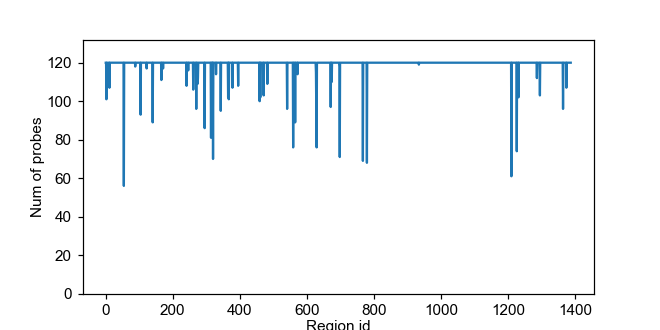

In [130]:
# Plot number of probes per region
plt.figure(figsize=(6,3), dpi=100)
plt.plot(list(reg_size_dic.values()))
#plt.plot(np.ones(len(pb_nums))*20)
plt.ylabel(f"Num of probes", labelpad=1)
plt.xlabel(f"Region id", labelpad=1)
plt.ylim([0, np.max(list(reg_size_dic.values()))*1.1])
plt.savefig(os.path.join(report_folder, 'afterblast_nProbes_per_region.png'), 
            transparent=True, dpi=300)
plt.show()

## number and location on each chr

In [143]:
chrs = []
chr_2_centers = {}
chr_2_types = {}
for _loc_name, _type in zip(region_info_df['locus_info'], region_info_df['type']):
    _chr = _loc_name.split(':')[0]
    _start, _end = _loc_name.split(':')[1].split('-')
    _center = (int(_start)+int(_end))/2
    if _chr not in chrs:
        chrs.append(_chr)
    # create
    if _chr not in chr_2_centers:
        chr_2_centers[_chr] = []
        chr_2_types[_chr] = []
    # append
    if _center not in chr_2_centers[_chr]:
        chr_2_centers[_chr].append(_center)
        chr_2_types[_chr].append(_type)
# region number
chr_2_region_num = {_chr:len(cts) for _chr, cts in chr_2_centers.items()}

In [139]:
# Load chromosome sizes
import pandas as pd
from ImageAnalysis3.structure_tools.distance import sort_chr

sorted_chrs = sorted(chrs, key=lambda _c: sort_chr(_c))

chrom_size_df = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\human\hg38\hg38.chrom.sizes',
            delimiter='\t', header=None)

chr_2_len = {}
for _chr in chrs:
    chr_2_len[_chr] = chrom_size_df.loc[chrom_size_df[0]==f'chr{_chr}', 1].values[0]


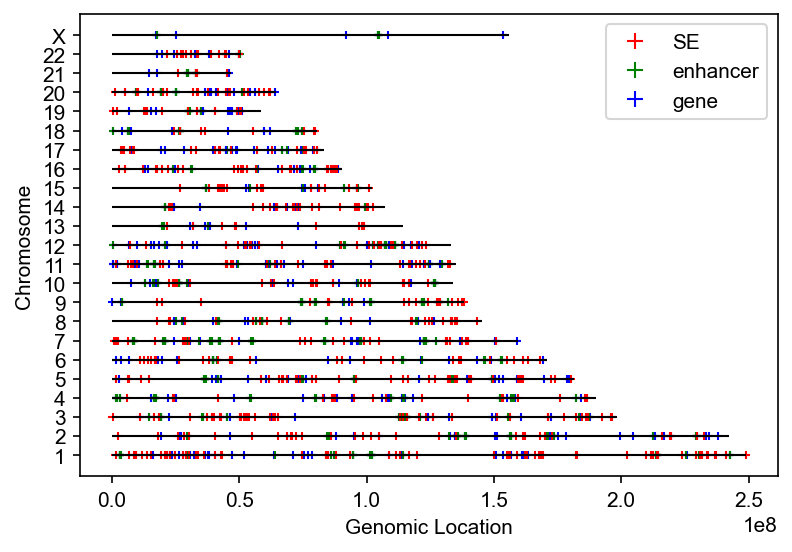

In [216]:
%matplotlib inline
color_map = {
    'SE':'red',
    'enhancer':'green',
    'gene':'blue',
}
#plt.style.use('dark_background')
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(6,4),dpi=150)
for _i, _chr in enumerate(sorted_chrs):
    ax.hlines(_i, 0, chr_2_len[_chr], color='black', linewidth=1)
    ax.scatter(chr_2_centers[_chr], 
               np.ones(len(chr_2_centers[_chr]))* _i, 
               marker='+', linewidth=1,
               s=15, c=[color_map[_t] for _t in chr_2_types[_chr]],
               )
# create legend patch
legend_element = [Line2D([0],[0], color=[0,0,0,0], 
                         label=_type, marker='+', markersize=8,
                         markeredgecolor=_c, markerfacecolor=_c,)
                  for _type,_c in color_map.items()]
ax.legend(handles=legend_element)
ax.set_yticks(np.arange(len(sorted_chrs)))
ax.set_yticklabels(sorted_chrs)
#ax.set_xlim([0, chr_2_len['1']])
ax.set_xlabel("Genomic Location")
ax.set_ylabel("Chromosome")
#ax.legend([_sc])
plt.savefig(os.path.join(report_folder, 'target_location_summary.png'), 
            dpi=300, transparent=True)
plt.show()

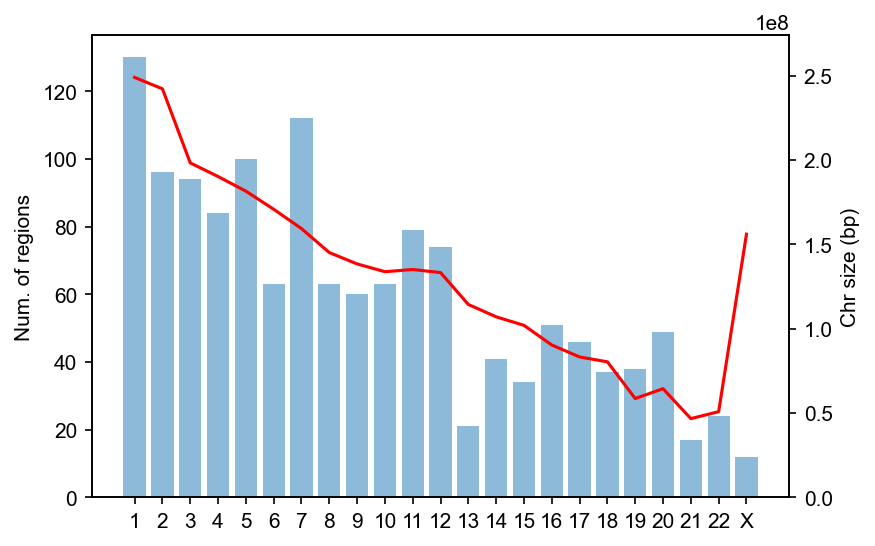

In [199]:
fig, ax1 = plt.subplots(figsize=(6,4),dpi=150)
ax2 = ax1.twinx()
_bar_p = ax1.bar(sorted_chrs, 
                 [chr_2_region_num[_c] for _c in sorted_chrs], alpha=0.5)
ax1.set_ylabel("Num. of regions")
ax2.plot(sorted_chrs, [chr_2_len[_c] for _c in sorted_chrs], color='r')
ax2.set_ylim([0, np.max(list(chr_2_len.values()))*1.1])
ax2.set_ylabel("Chr size (bp)")
plt.savefig(os.path.join(report_folder, 'target_chr_stat_summary.png'), 
            dpi=300, transparent=True)
plt.show()

# Expand count table

In [16]:
from ImageAnalysis3 import library_tools
from tqdm import tqdm
# library
genome_library_table_file = os.path.join(reference_folder, 'ctp14-human_genome_library_17w.npy')

# class
ct = library_tools.design.countTable(
        word=17,save_file=genome_library_table_file, 
        sparse=False)
# load 
ct.load()

In [10]:
# append new
ctp14_human_full_table_file = os.path.join(reference_folder, 'ctp14-human_full_17w.npy')
# 
if not os.path.exists(ctp14_human_full_table_file) or overwrite_table:
    # library
    _library_filenames = [os.path.join(library_folder, 'blast_full_probes.fasta')]
    print(len(_library_filenames))
    # update params
    ct.verbose=True
    ct.save_file = ctp14_human_full_table_file

    ct.read(_library_filenames) # read sequences from fasta files

    ct.consume_loaded(num_threads=44) # convert sequences into integers

    ct.complete(verbose=True)
    # save
    ct.save()
else:
    print(f"reference table: {library_table_file} already exist, skip.")

1
- Start multi-processing comsume 165445 sequences 44 threads, finish in 62.610s
- Total sequences loaded: 24154970
Time to compute unique and clip: 8.159064054489136
Time to update matrix: 15.98088812828064


- start saving to file: \\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\human\hg38\ctp14-human_full_17w.npy


In [206]:
aire_df = pd.read_csv(r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-10_Aire\Gene_list\uniqued_clustered_genes_for_yuan_2021-04-22.txt', 
            delimiter='\t', header=None, names=['type', 'gene'])

In [207]:
aire_df

type    gene
0    Immature MEC  Ccl21a
1    Immature MEC   Krt14
2    Immature MEC    Krt5
3    Immature MEC  Col6a1
4    Immature MEC    Lifr
..            ...     ...
204    Aire-stage     Ltf
205    Aire-stage    Clps
206    Aire-stage  Col1a1
207    Aire-stage    Gpx6
208    Aire-stage   Plvap

[209 rows x 2 columns]

In [208]:
np.unique(aire_df['type'])

array(['Aire-stage', 'Ciliated', 'Gut/Liver', 'Immature MEC', 'Lung',
       'Mcell', 'Muscle', 'Neuroendocrine', 'Skin', 'Tuft1', 'Tuft2'],
      dtype=object)